In [1]:
import os
import geopandas
import pandas
import zipfile
import numpy as np
import matplotlib.pyplot as plot

In [2]:
if not os.path.exists('LANDSAT_MSS_C2_L1.csv.gz'):
    !curl -L -o LANDSAT_MSS_C2_L1.csv.gz https://landsat.usgs.gov/landsat/metadata_service/bulk_metadata_files/LANDSAT_MSS_C2_L1.csv.gz
mss_c2 = pandas.read_csv('LANDSAT_MSS_C2_L1.csv.gz') 


C:\Users\Simon\AppData\Local\Temp\ipykernel_58400\1413014868.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  mss_c2 = pandas.read_csv('LANDSAT_MSS_C2_L1.csv.gz')


In [3]:
if not os.path.exists('WRS1_descending_0.zip'):
    !curl -L -o WRS1_descending_0.zip https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/WRS1_descending_0.zip
wrs1desc = geopandas.GeoDataFrame.from_file('WRS1_descending_0.zip') 

In [4]:
if not os.path.exists('WRS2_descending_0.zip'):
    !curl -L -o WRS2_descending_0.zip https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/WRS2_descending_0.zip
wrs2desc = geopandas.GeoDataFrame.from_file('WRS2_descending_0.zip') 

In [5]:
mss_c2['PR'] = mss_c2['WRS Path'].map(str).str.pad(3,fillchar='0') + mss_c2['WRS Row'].map(str).str.pad(3,fillchar='0')

In [6]:
if not os.path.exists('TM_WORLD_BORDERS_SIMPL-0.3.zip'):
    !curl -L -o TM_WORLD_BORDERS_SIMPL-0.3.zip http://thematicmapping.org/downloads/TM_WORLD_BORDERS_SIMPL-0.3.zip

Australia = geopandas.GeoDataFrame.from_file('zip://TM_WORLD_BORDERS_SIMPL-0.3.zip')
Australia = Australia[Australia.NAME.isin(['Australia'])]

In [7]:
Australia.reset_index(inplace = True)
wrs1desc.reset_index(inplace = True)
wrs2desc.reset_index(inplace = True)

In [8]:
wrs1desc.set_index('PR', inplace = True)
wrs2desc.set_index('PR', inplace = True)

wrs1desc_intersect = wrs1desc.intersection(Australia)
wrs2desc_intersect = wrs2desc.intersection(Australia)

C:\Users\Simon\anaconda3\lib\site-packages\geopandas\base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")
C:\Users\Simon\anaconda3\lib\site-packages\geopandas\base.py:31: UserWarning: The indices of the two GeoSeries are different.
  warn("The indices of the two GeoSeries are different.")


C:\Users\Simon\anaconda3\lib\site-packages\geopandas\geodataframe.py:1470: FutureWarning: Passing 'suffixes' which cause duplicate columns {'index_left', 'index_right'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


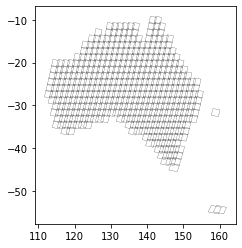

In [9]:
Australia_wrs1desc = geopandas.sjoin(wrs1desc, Australia)
Australia_wrs1desc.to_crs('EPSG:4326').plot( facecolor='none', edgecolor='black', lw=0.2)

Australia_wrs1desc['PR'] = Australia_wrs1desc['PATH'].map(str).str.pad(3,fillchar='0') + Australia_wrs1desc['ROW_'].map(str).str.pad(3,fillchar='0')

Australia_wrs1desc.set_index('PR', inplace = True)

C:\Users\Simon\anaconda3\lib\site-packages\geopandas\geodataframe.py:1470: FutureWarning: Passing 'suffixes' which cause duplicate columns {'index_left', 'index_right'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


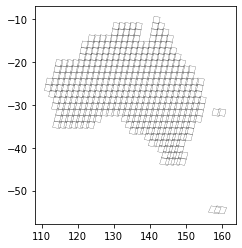

In [10]:
Australia_wrs2desc = geopandas.sjoin(wrs2desc, Australia)
Australia_wrs2desc.to_crs('EPSG:4326').plot( facecolor='none', edgecolor='black', lw=0.2)

Australia_wrs2desc['PR'] = Australia_wrs2desc['PATH'].map(str).str.pad(3,fillchar='0') + Australia_wrs2desc['ROW'].map(str).str.pad(3,fillchar='0')

Australia_wrs2desc.set_index('PR', inplace = True)

In [11]:
mss_c2['count'] = 1

In [12]:
mss_c2_wrs2 = mss_c2[mss_c2['WRS Type'] == 2]
mss_c2_wrs1 = mss_c2[mss_c2['WRS Type'] == 1]

In [13]:
mss_c2_Australia_wrs1 = mss_c2_wrs1[mss_c2_wrs1['PR'].isin(Australia_wrs1desc.index)]
mss_c2_Australia_wrs2 = mss_c2_wrs2[mss_c2_wrs2['PR'].isin(Australia_wrs2desc.index)]

In [16]:
mss_c2_Australia_wrs1_pivot = mss_c2_Australia_wrs1.pivot_table(index='PR', aggfunc={"count": np.sum})

In [17]:
mss_c2_Australia_wrs2_pivot = mss_c2_Australia_wrs2.pivot_table(index='PR', aggfunc={"count": np.sum})

In [18]:
mss_c2_Australia_wrs1desc = Australia_wrs1desc.join(mss_c2_Australia_wrs1_pivot, on ='PR')

In [19]:
mss_c2_Australia_wrs2desc = Australia_wrs2desc.join(mss_c2_Australia_wrs2_pivot, on ='PR')

<AxesSubplot:title={'center':'MSS WRS1 All Years - max count = 150'}>

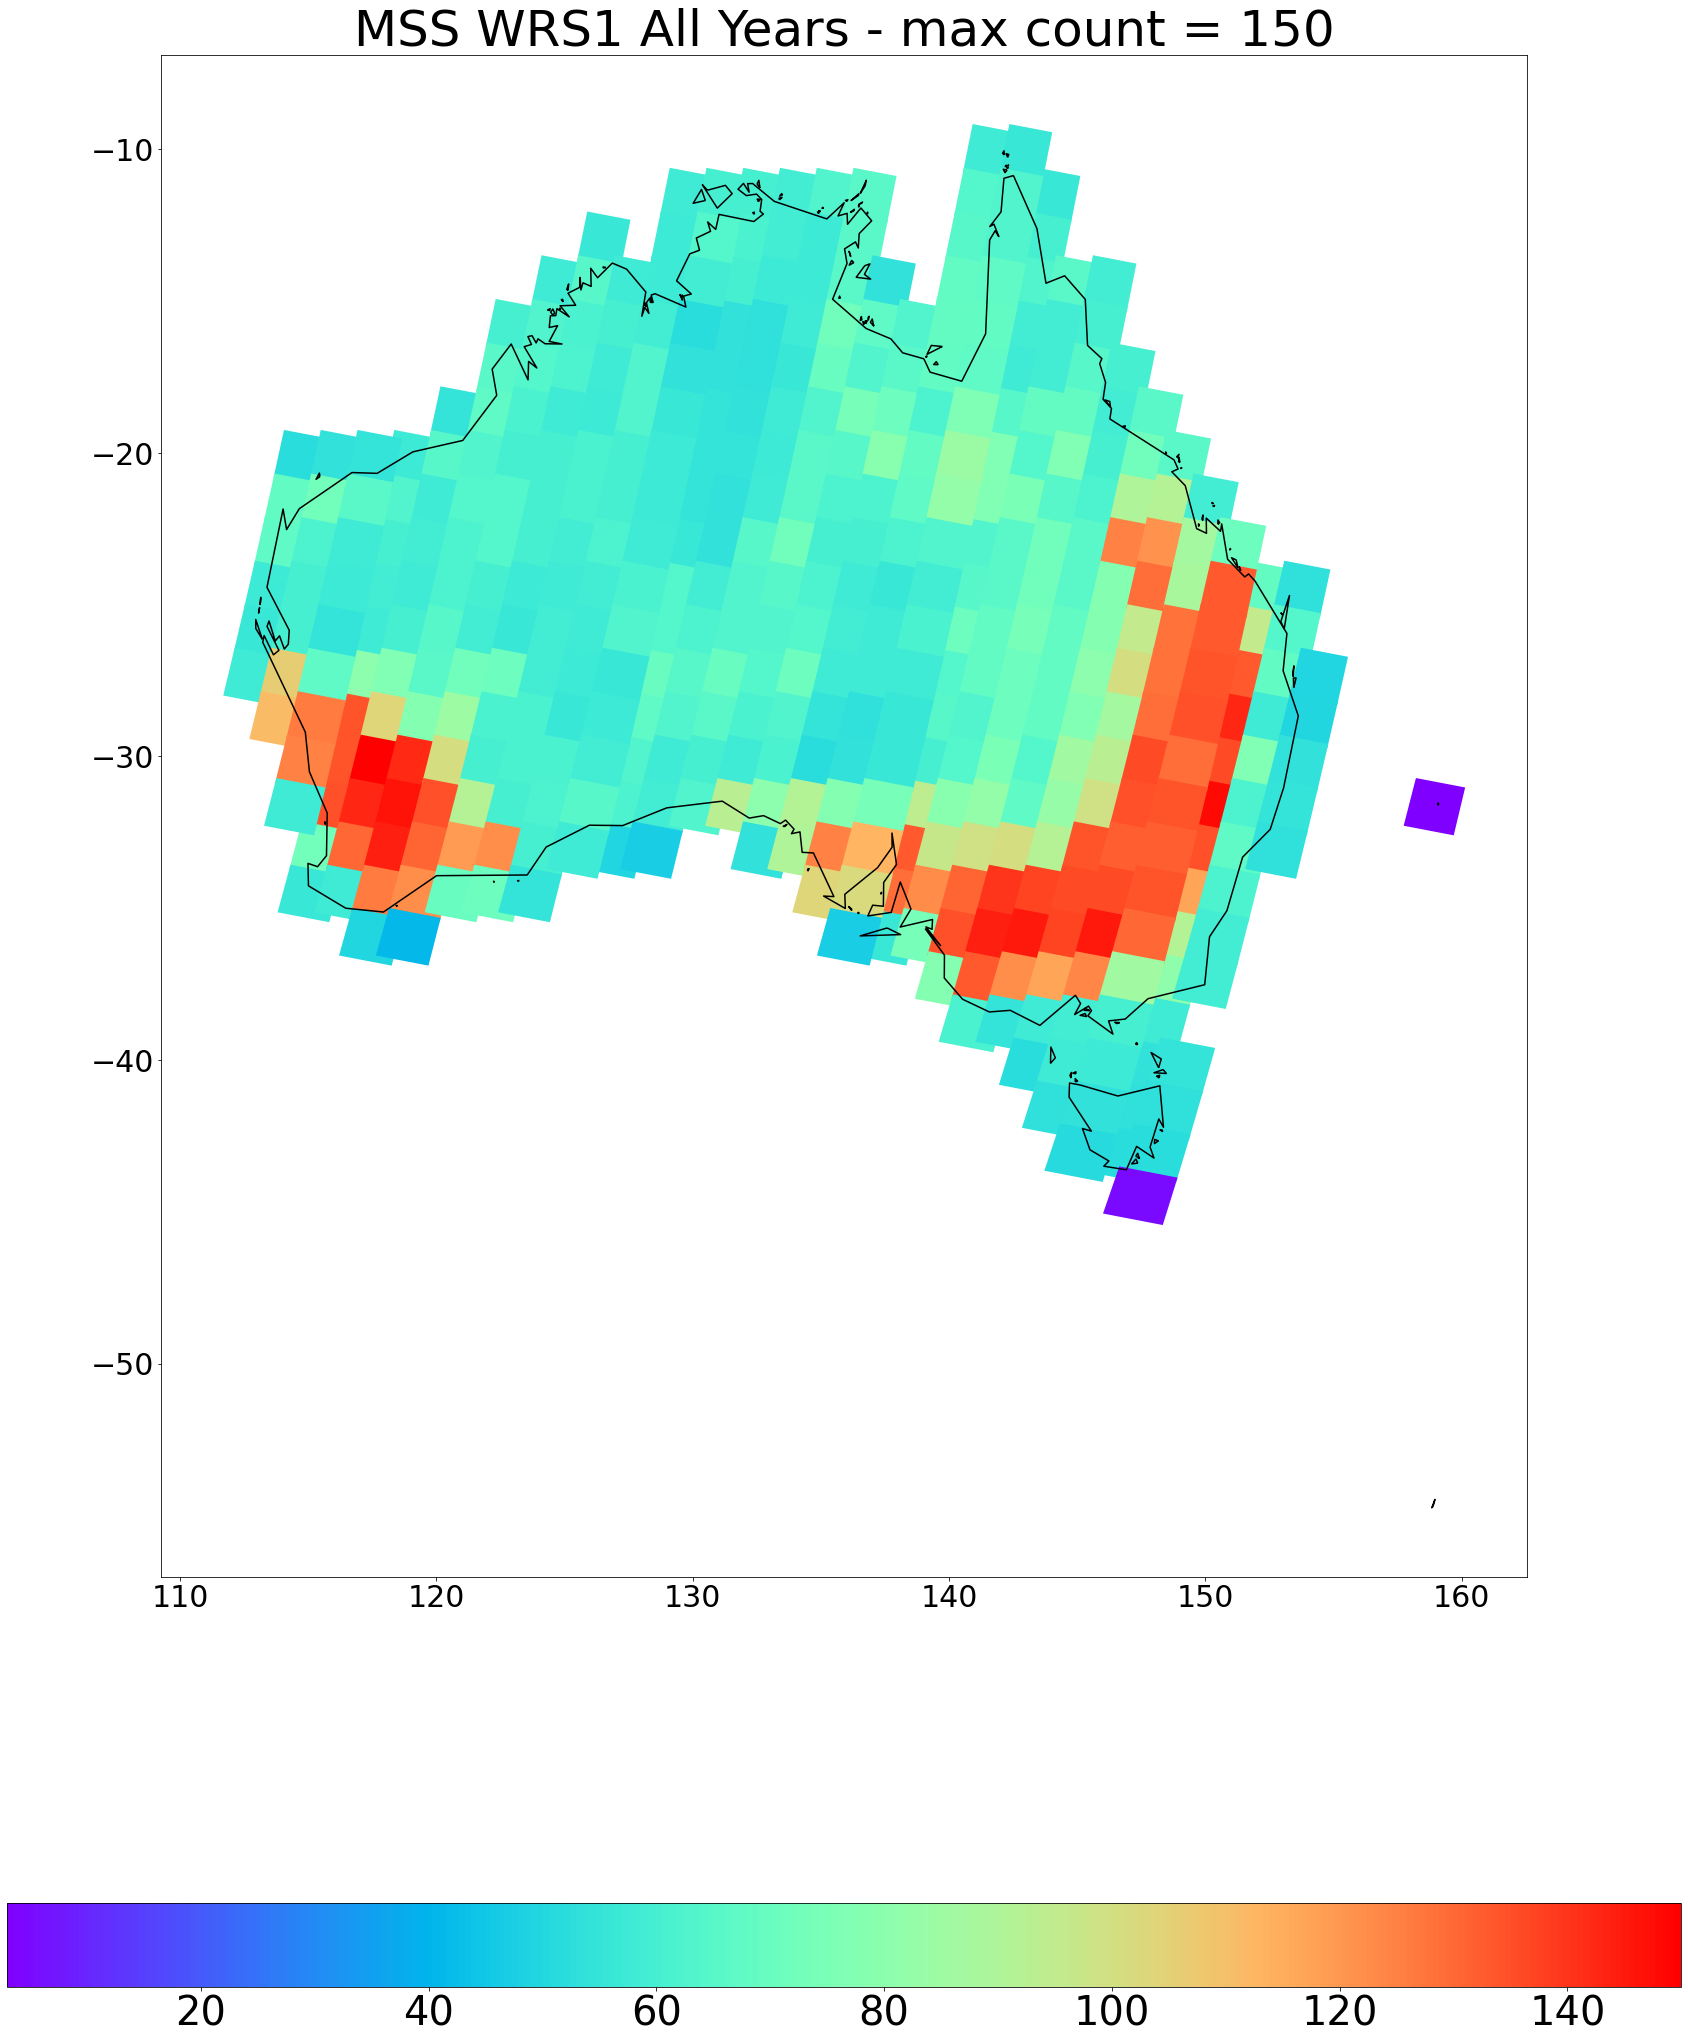

In [98]:
max = mss_c2_Australia_wrs1desc['count'].max()
ax = mss_c2_Australia_wrs1desc.to_crs('EPSG:4326').plot("count", cmap='rainbow', vmax=max, legend=True, figsize=(30, 40), legend_kwds={'orientation': "horizontal"})
ax.set_title('MSS WRS1 All Years - max count = '+str(int(max)))
ax.figure.axes[0].title.set_fontsize(50)
ax.figure.axes[1].tick_params(labelsize=40)
ax.figure.axes[0].tick_params(labelsize=30)
Australia.boundary.to_crs('EPSG:4326').plot(ax=ax,  edgecolor='black')

<AxesSubplot:title={'center':'MSS WRS2 All Years - max count = 342'}>

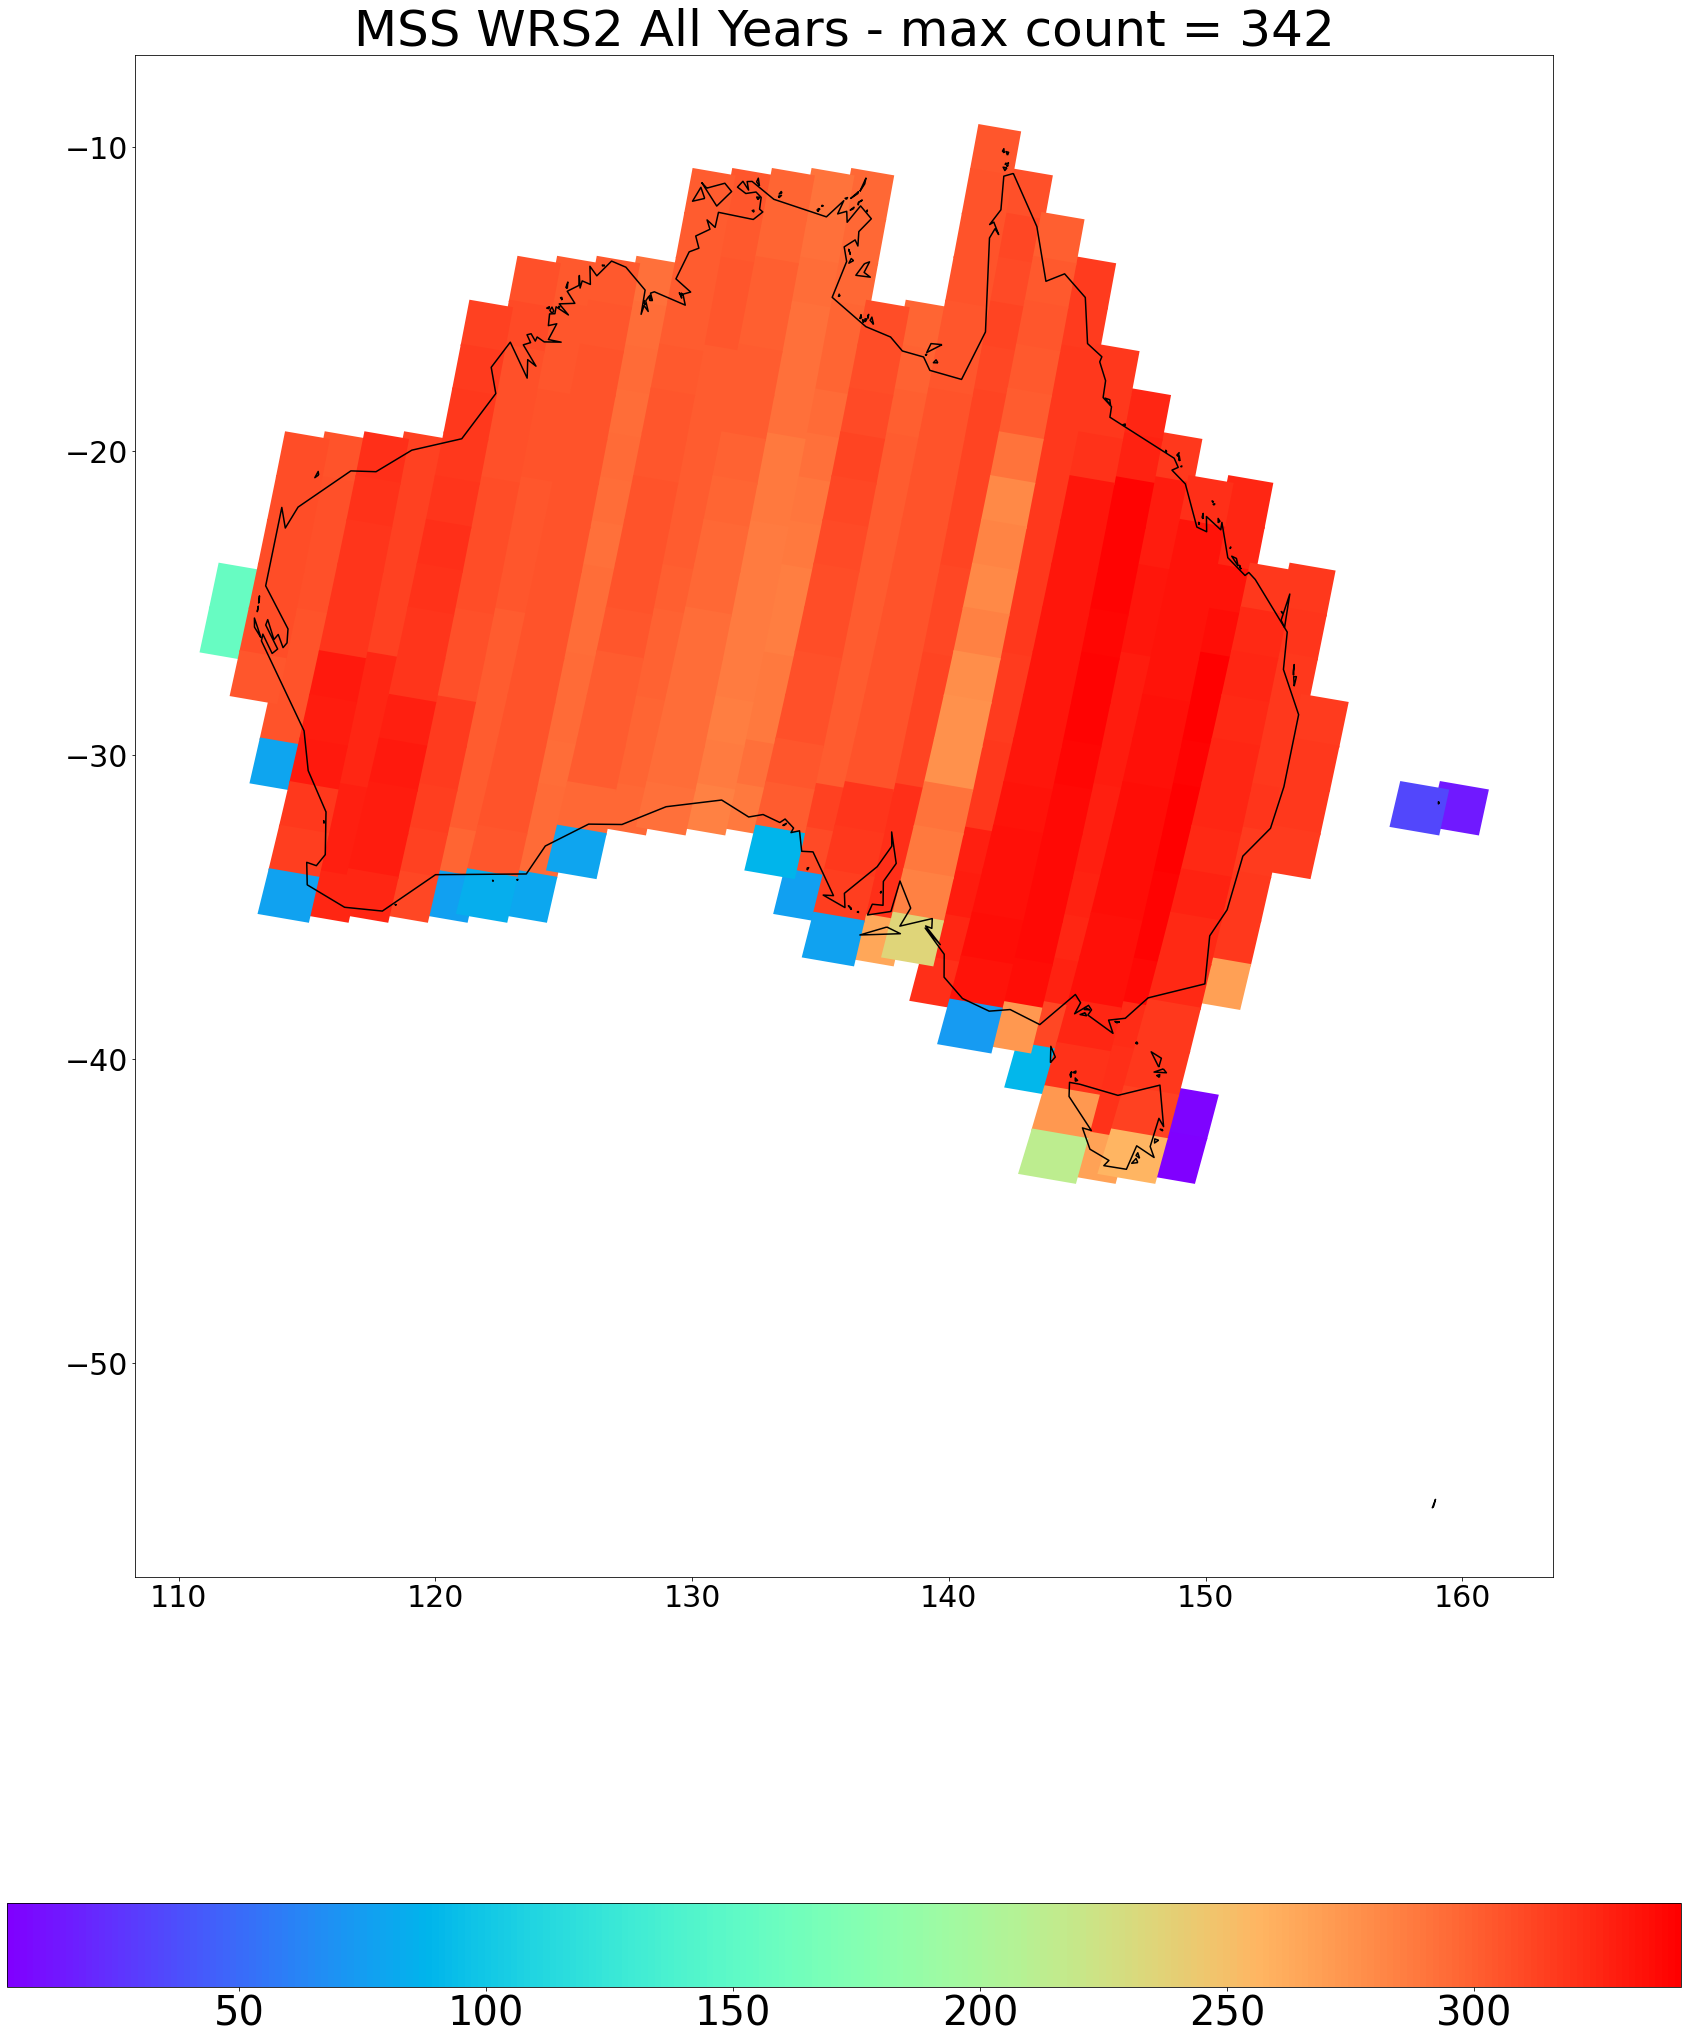

In [96]:
max = mss_c2_Australia_wrs2desc['count'].max()

ax = mss_c2_Australia_wrs2desc.to_crs('EPSG:4326').plot("count", cmap='rainbow', vmax=max, legend=True, figsize=(30, 40), legend_kwds={'orientation': "horizontal"})
ax.set_title('MSS WRS2 All Years - max count = '+str(int(max)))
ax.figure.axes[0].title.set_fontsize(50)
ax.figure.axes[1].tick_params(labelsize=40)
ax.figure.axes[0].tick_params(labelsize=30)
Australia.boundary.to_crs('EPSG:4326').plot(ax=ax, edgecolor='black')

In [22]:
mss_c2_Australia_wrs1desc['count'].sum().astype(int)

31670

In [23]:
mss_c2_Australia_wrs2desc['count'].sum().astype(int)

118769

In [39]:
mss_c2_Australia_wrs1['Date Acquired'] = pandas.to_datetime(mss_c2_Australia_wrs1['Date Acquired'], format='%Y/%m/%d')
mss_c2_Australia_wrs1_yearcount = mss_c2_Australia_wrs1.groupby(mss_c2_Australia_wrs1['Date Acquired'].dt.year).sum()

C:\Users\Simon\AppData\Local\Temp\ipykernel_58400\3682424778.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mss_c2_Australia_wrs1['Date Acquired'] = pandas.to_datetime(mss_c2_Australia_wrs1['Date Acquired'], format='%Y/%m/%d')


In [38]:
mss_c2_Australia_wrs2['Date Acquired'] = pandas.to_datetime(mss_c2_Australia_wrs2['Date Acquired'], format='%Y/%m/%d')
mss_c2_Australia_wrs2_yearcount = mss_c2_Australia_wrs2.groupby(mss_c2_Australia_wrs2['Date Acquired'].dt.year).sum()

C:\Users\Simon\AppData\Local\Temp\ipykernel_58400\3253507282.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mss_c2_Australia_wrs2['Date Acquired'] = pandas.to_datetime(mss_c2_Australia_wrs2['Date Acquired'], format='%Y/%m/%d')


<AxesSubplot:title={'center':'MSS WRS1 count by year'}, xlabel='Date Acquired'>

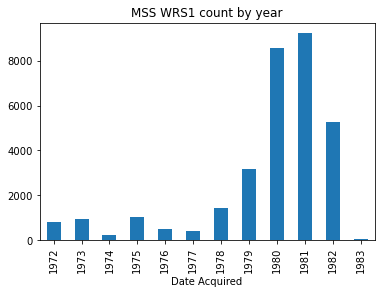

In [55]:
mss_c2_Australia_wrs1_yearcount['count'].plot(kind = 'bar', title='MSS WRS1 count by year')

<AxesSubplot:title={'center':'MSS WRS2 count by year'}, xlabel='Date Acquired'>

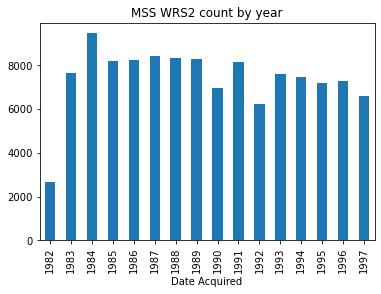

In [56]:
mss_c2_Australia_wrs2_yearcount['count'].plot(kind = 'bar', title='MSS WRS2 count by year')

C:\Users\Simon\anaconda3\lib\site-packages\geopandas\plotting.py:673: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


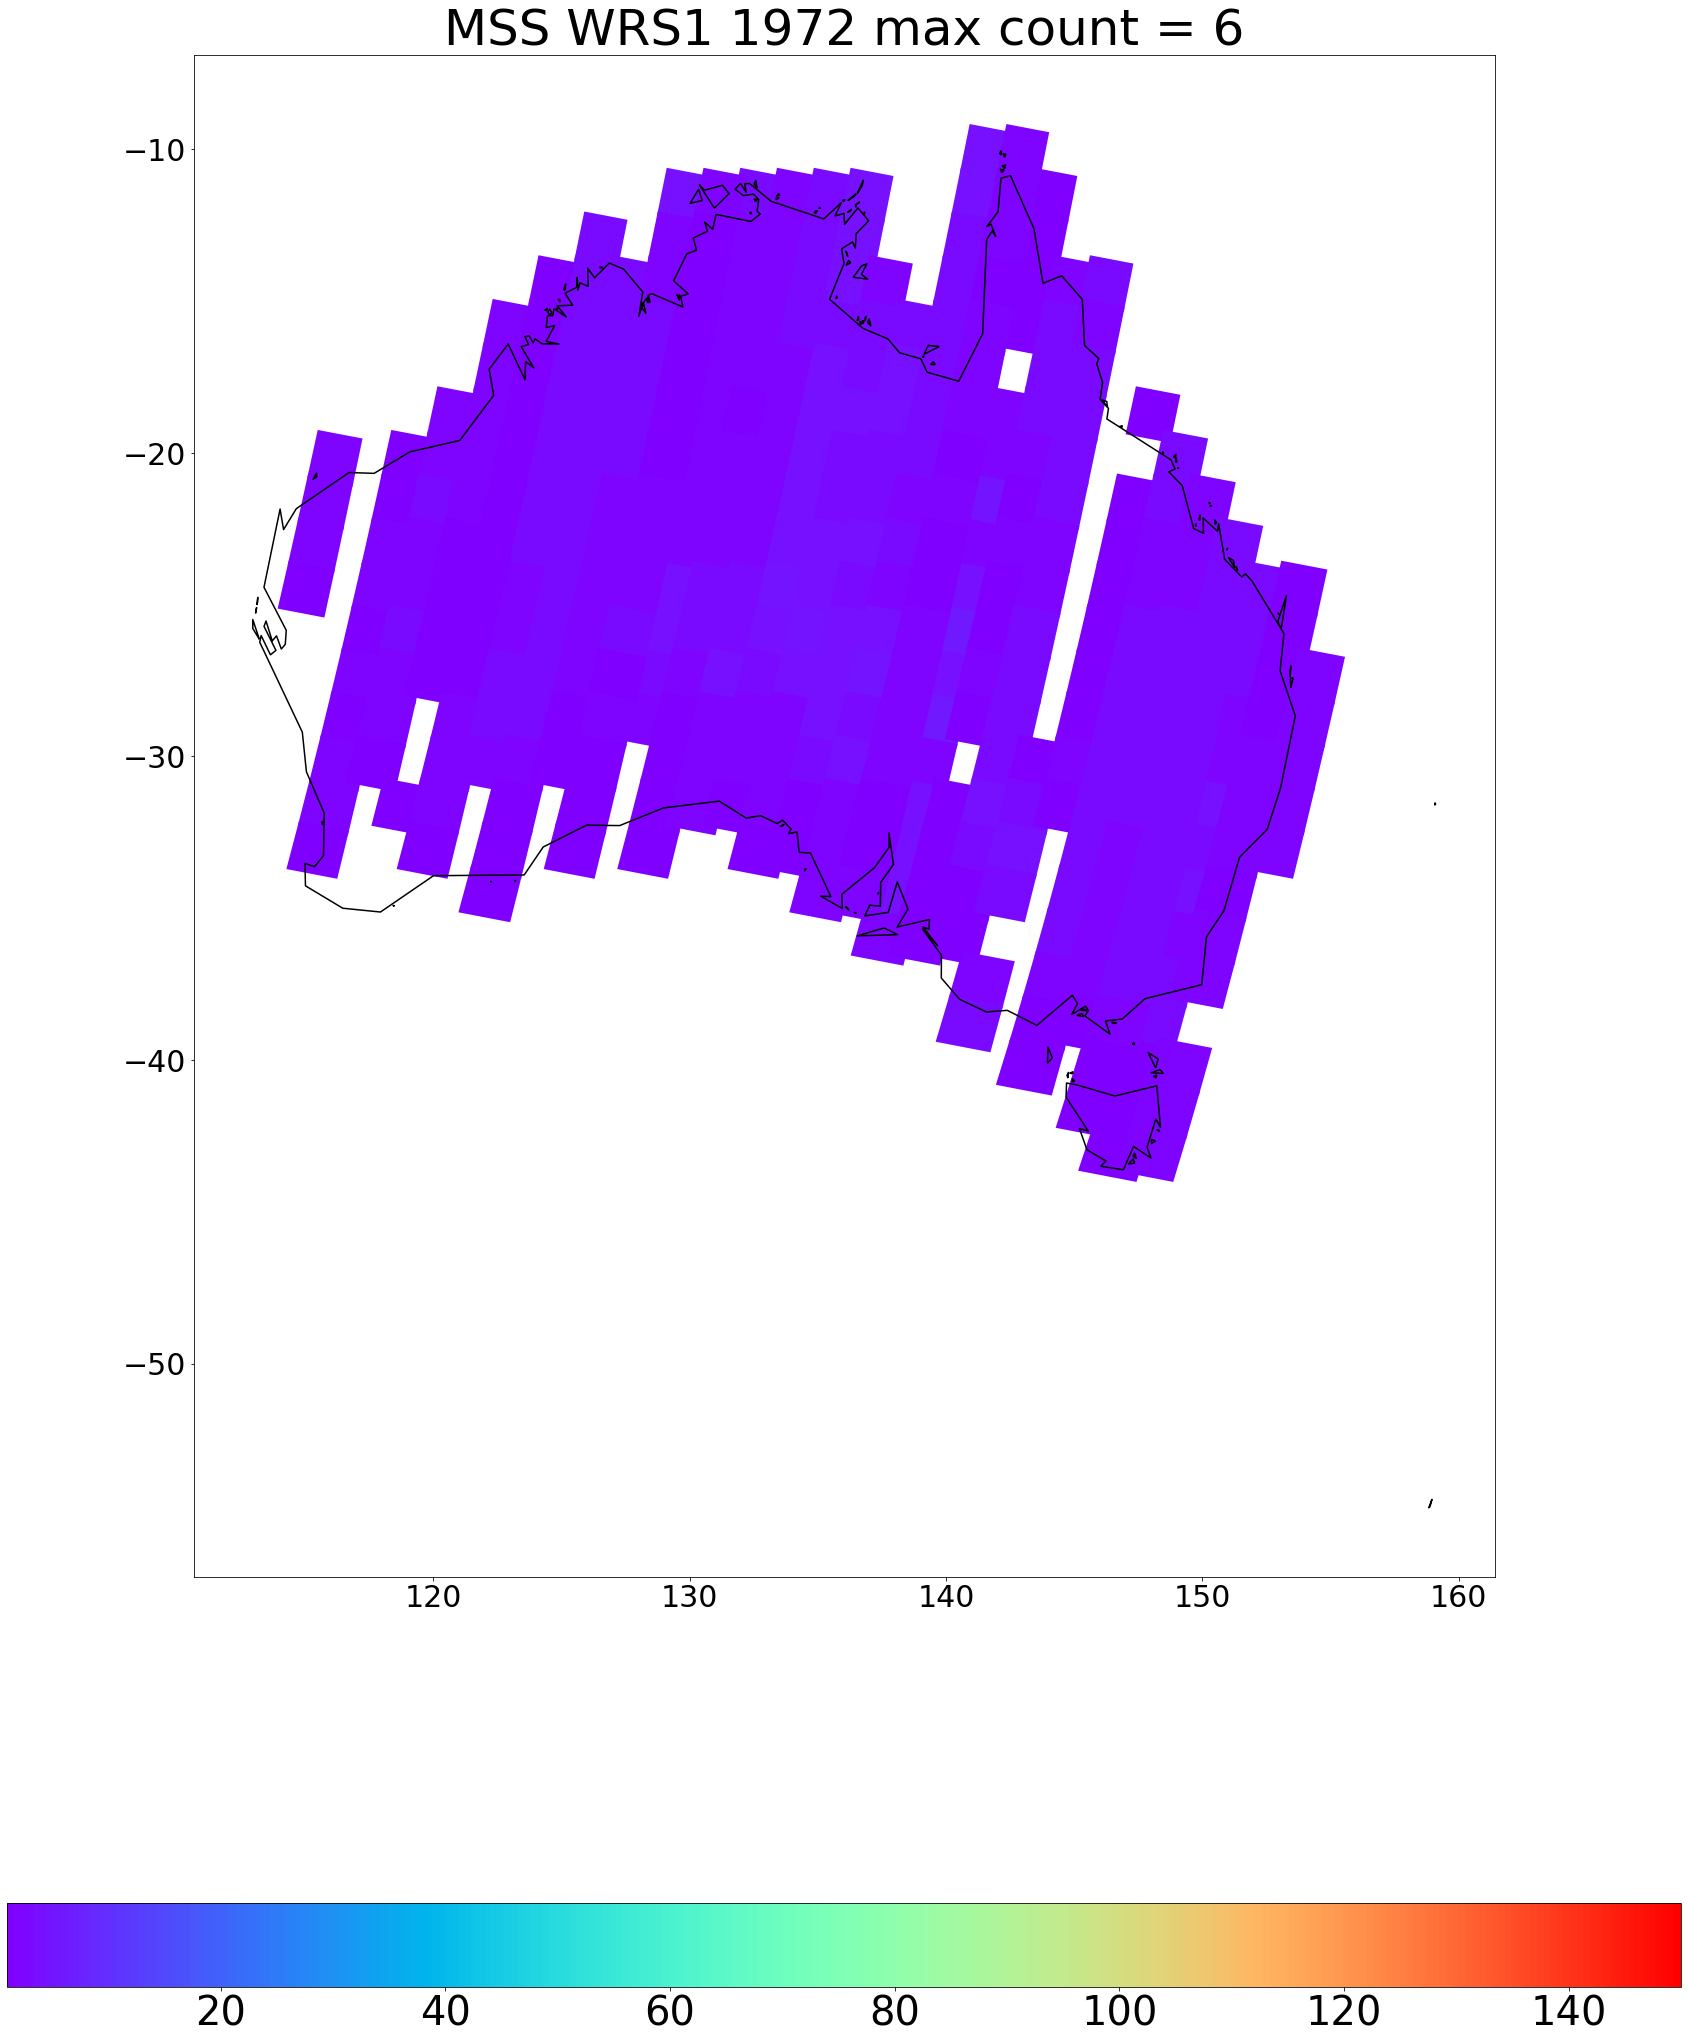

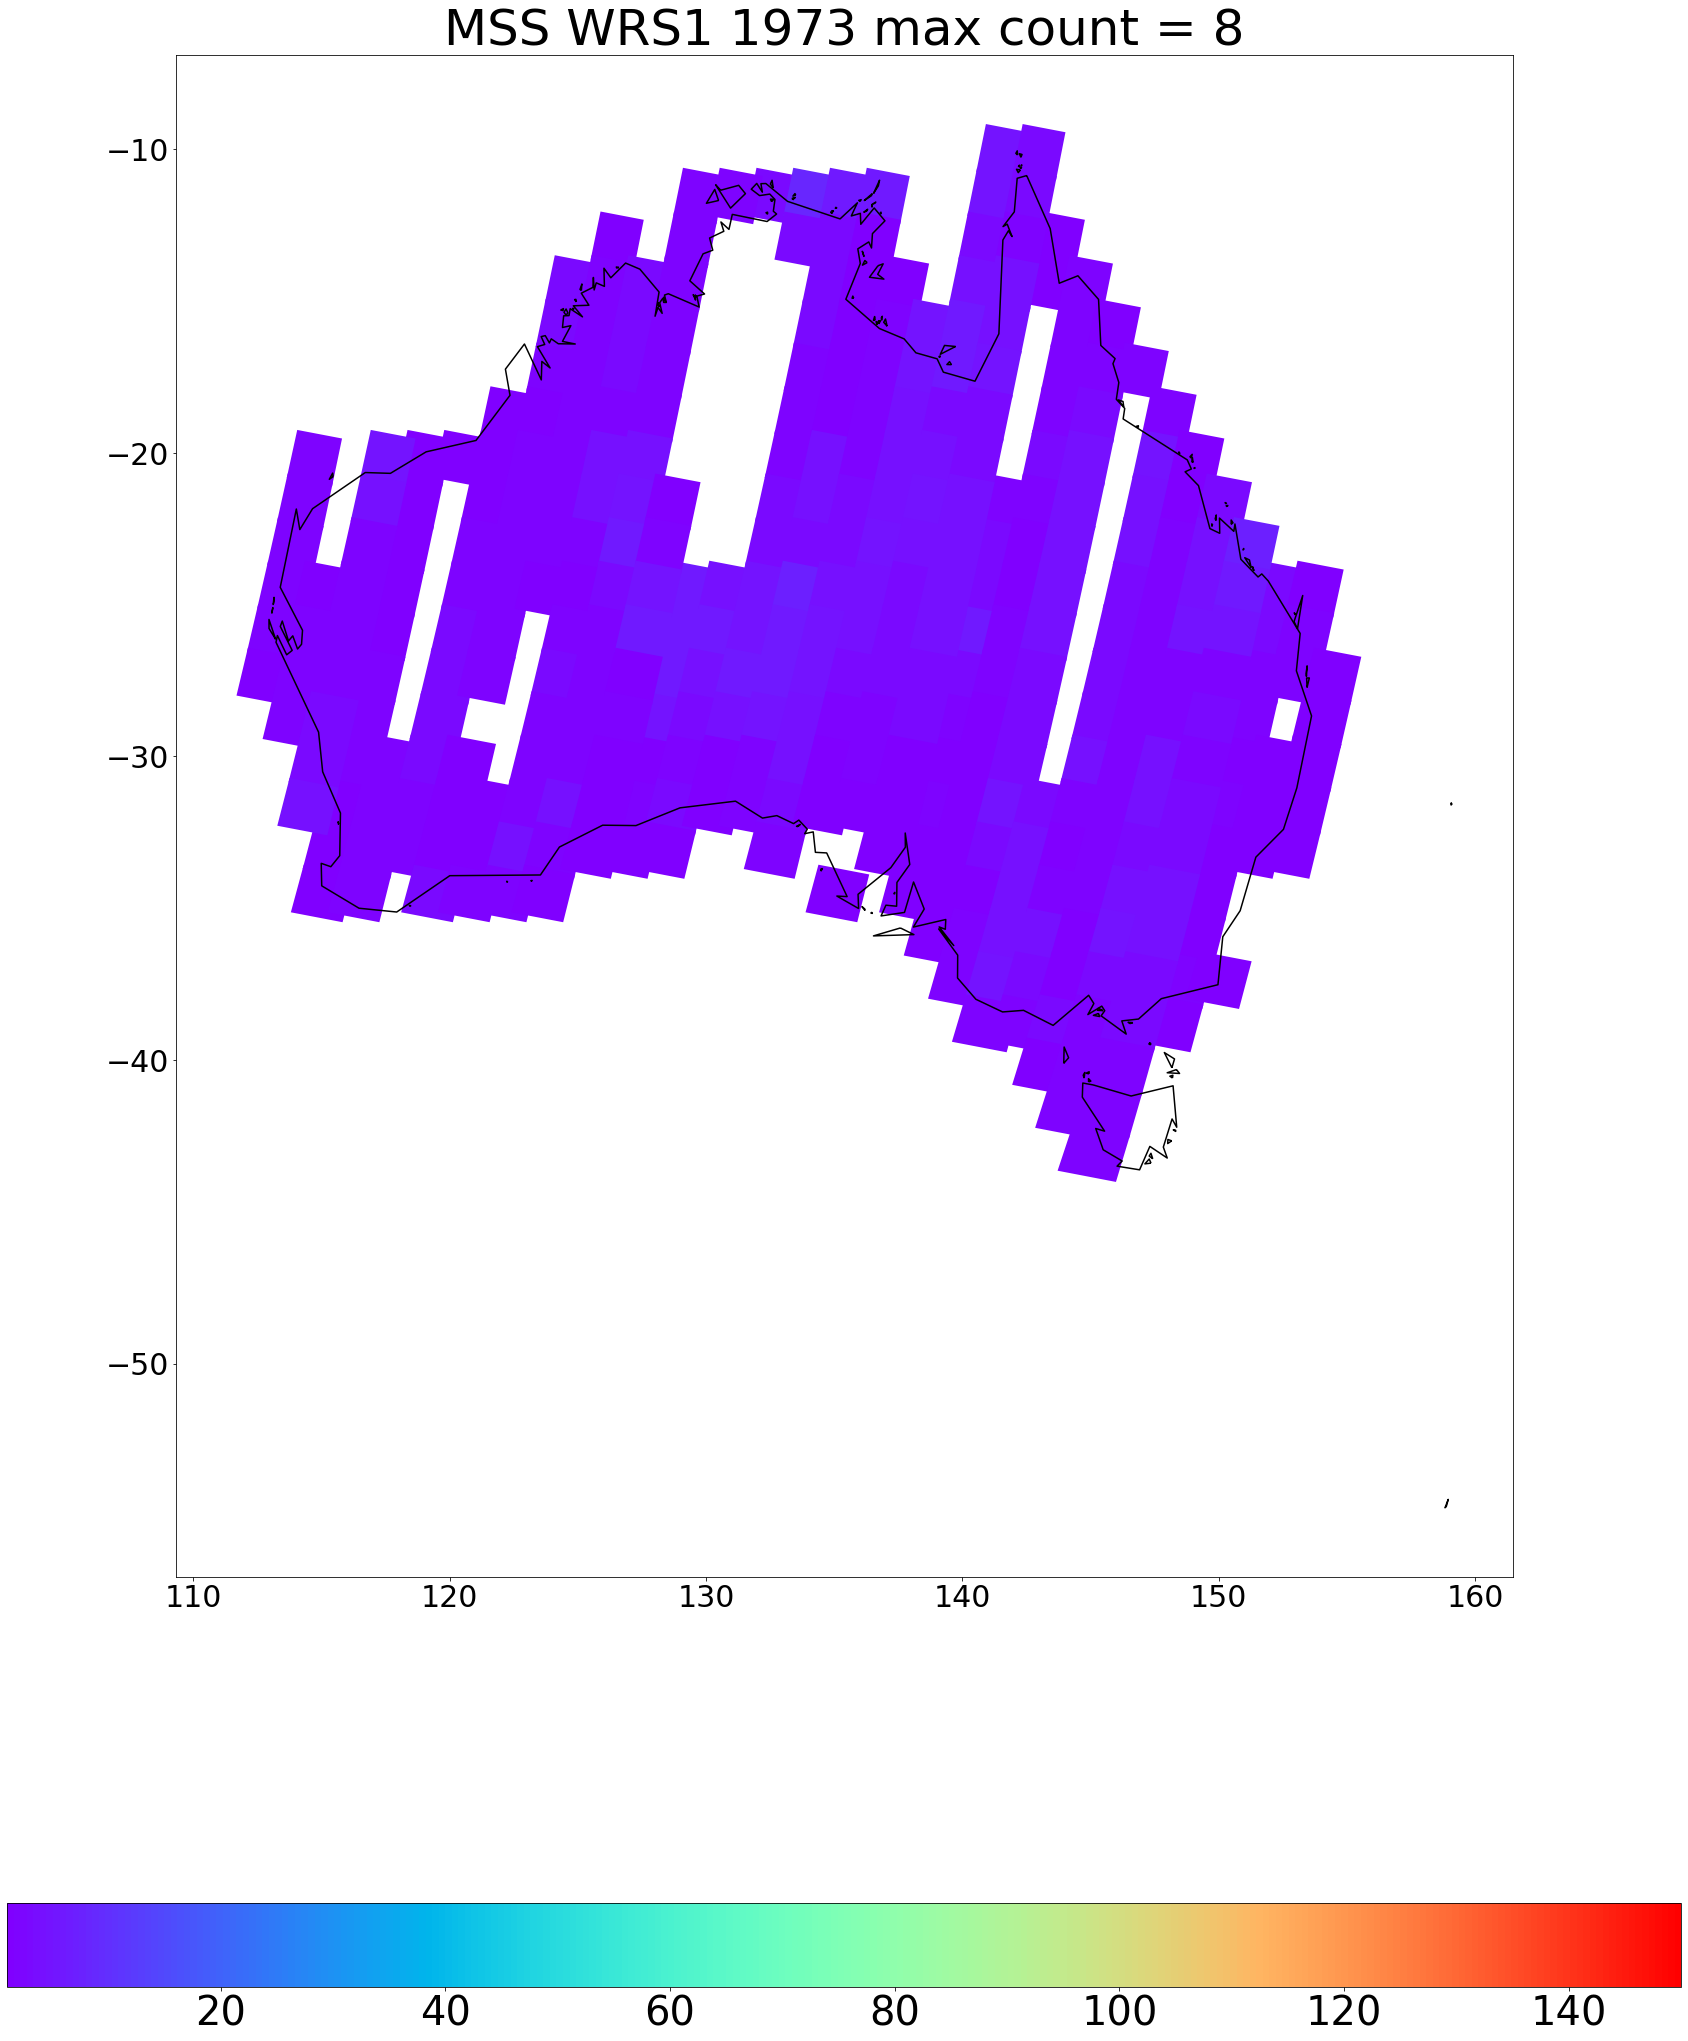

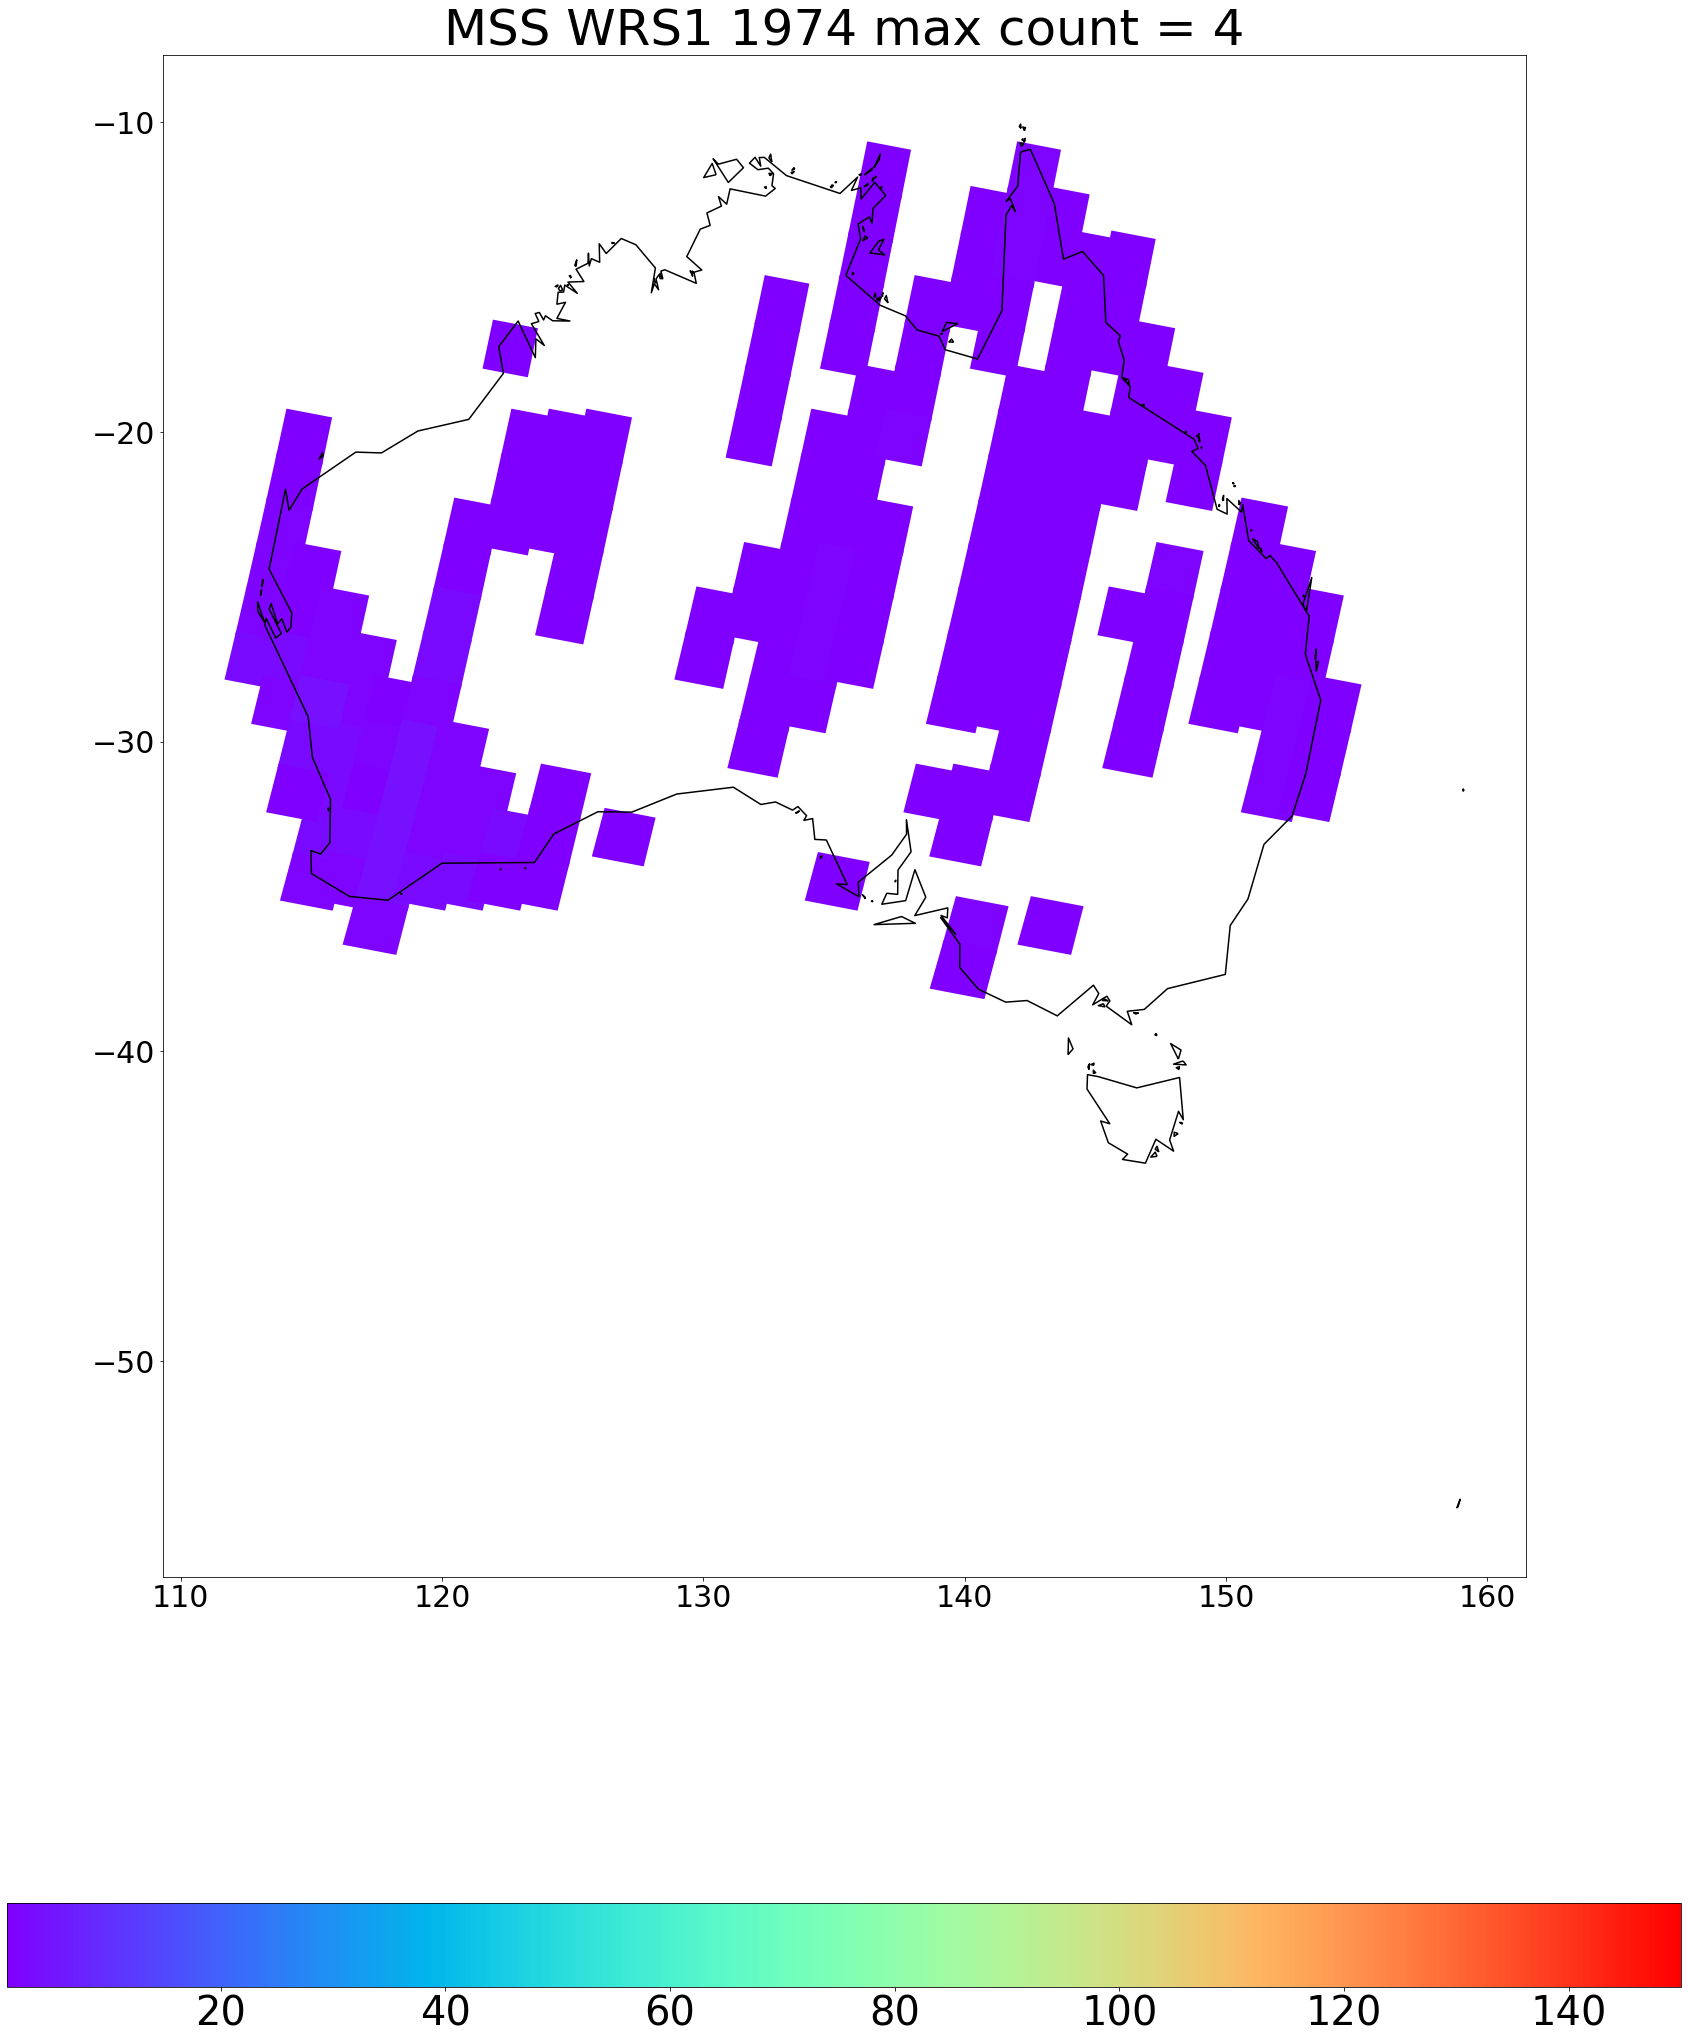

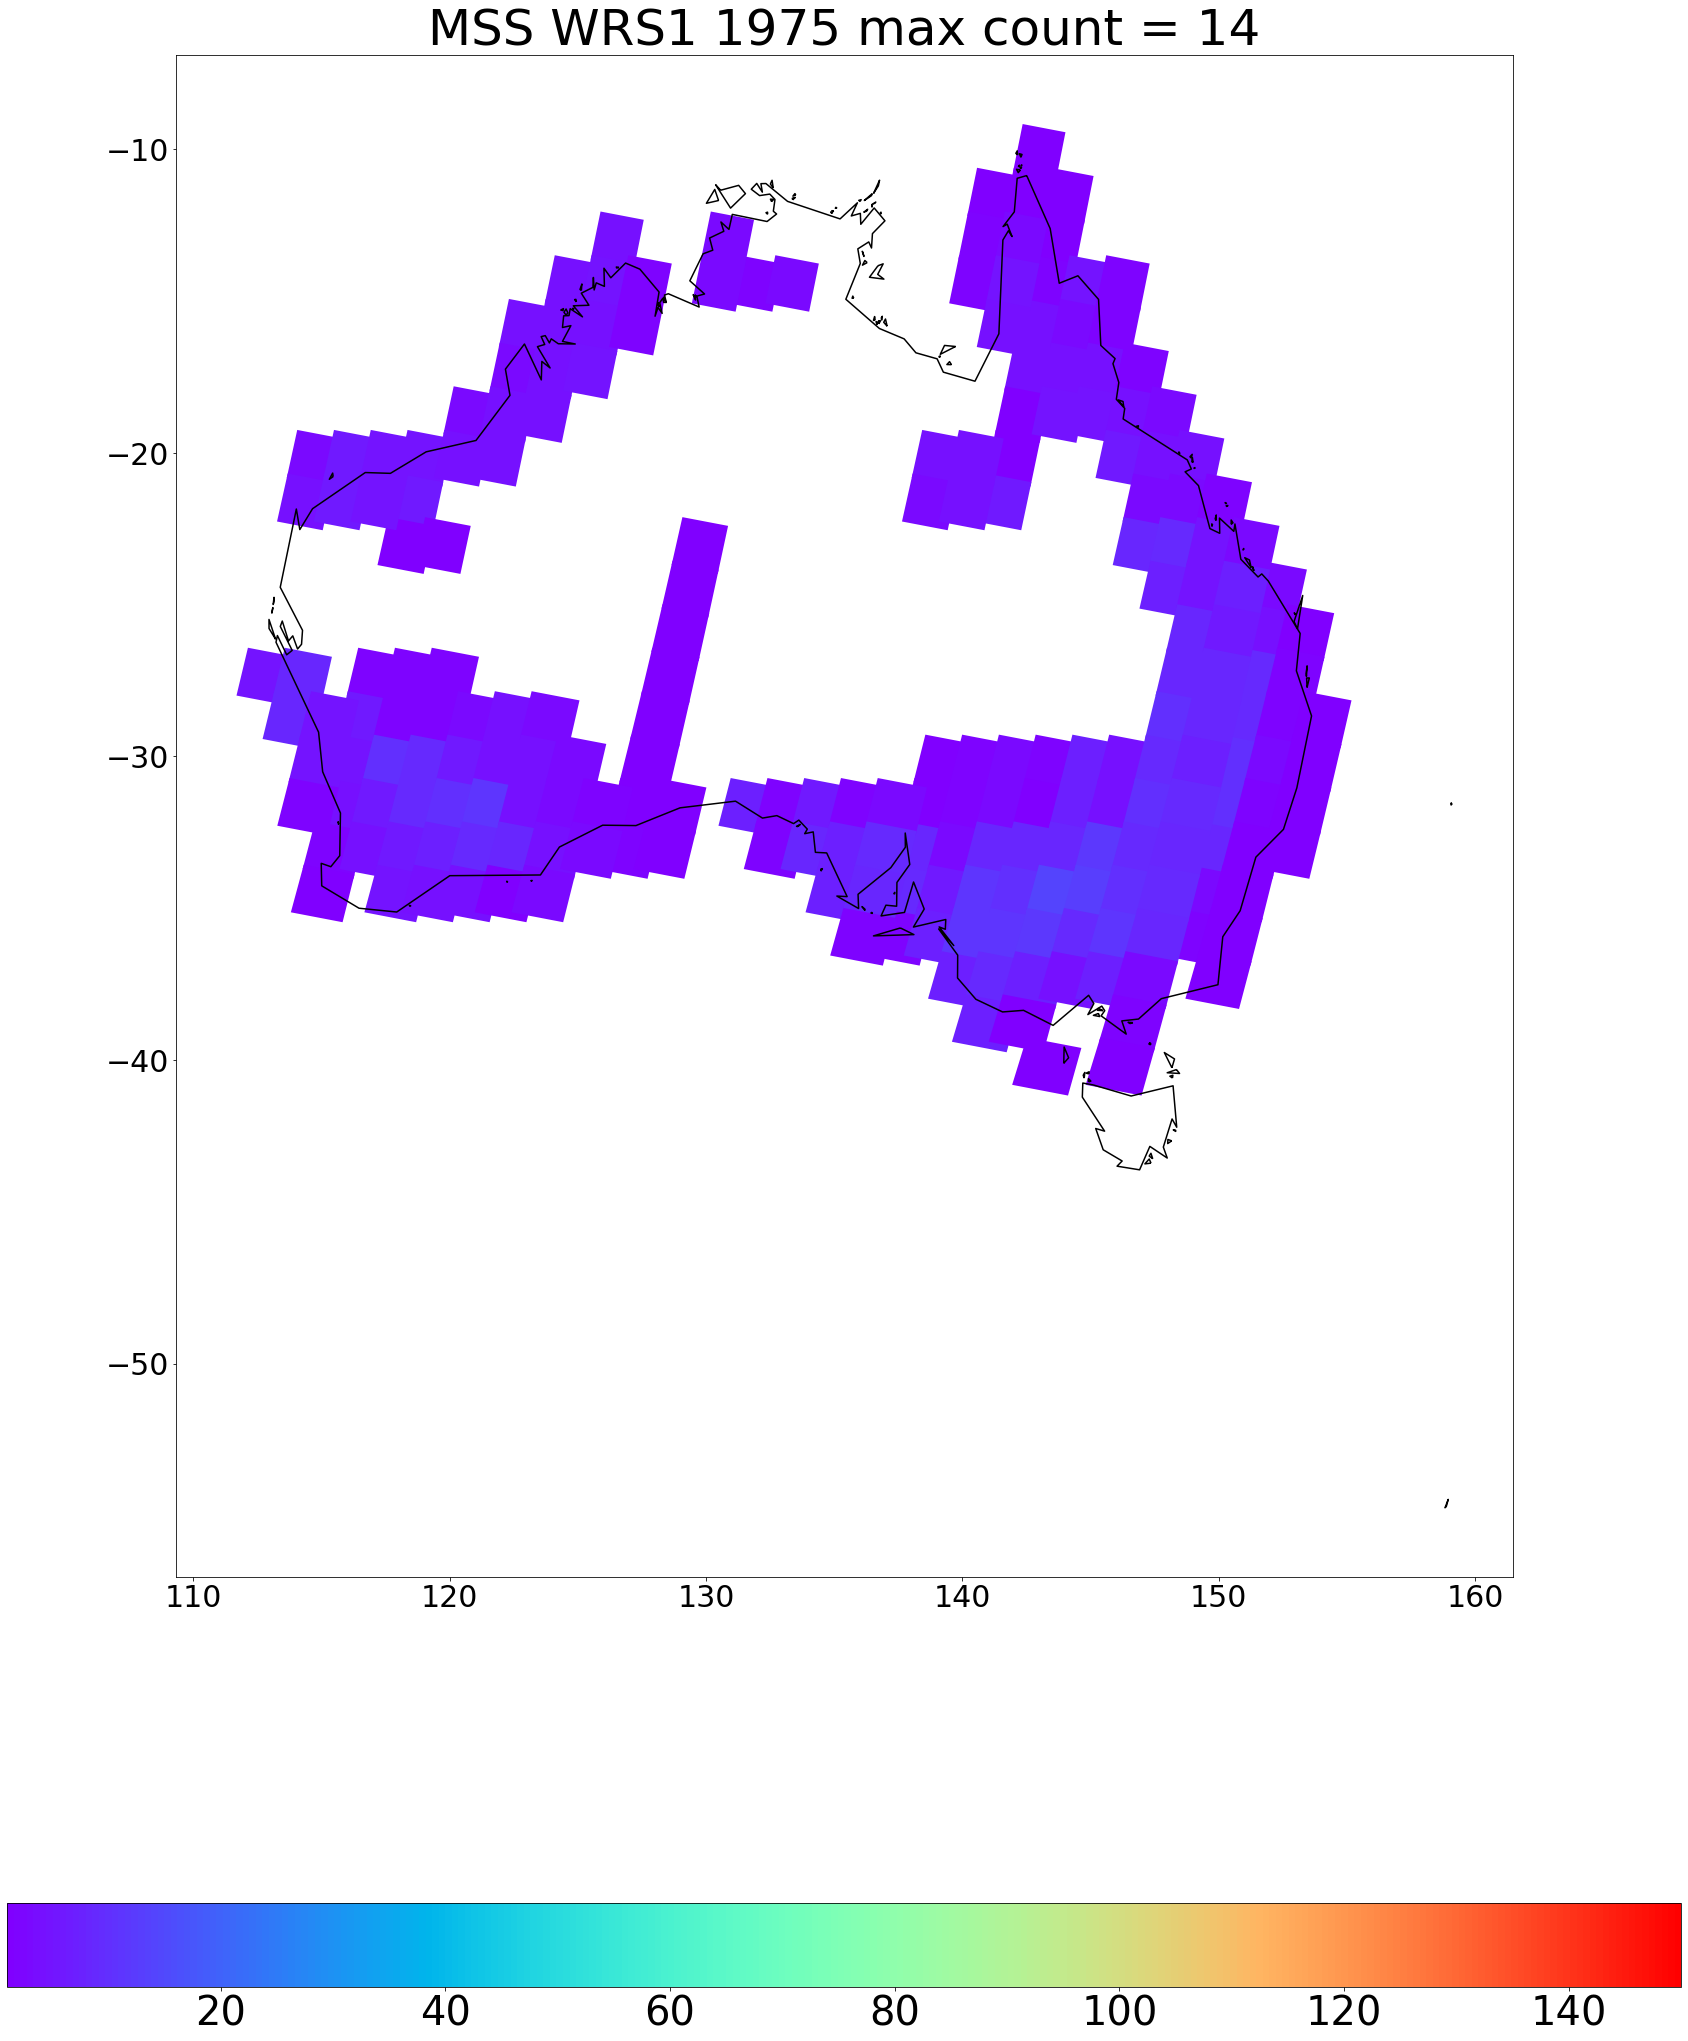

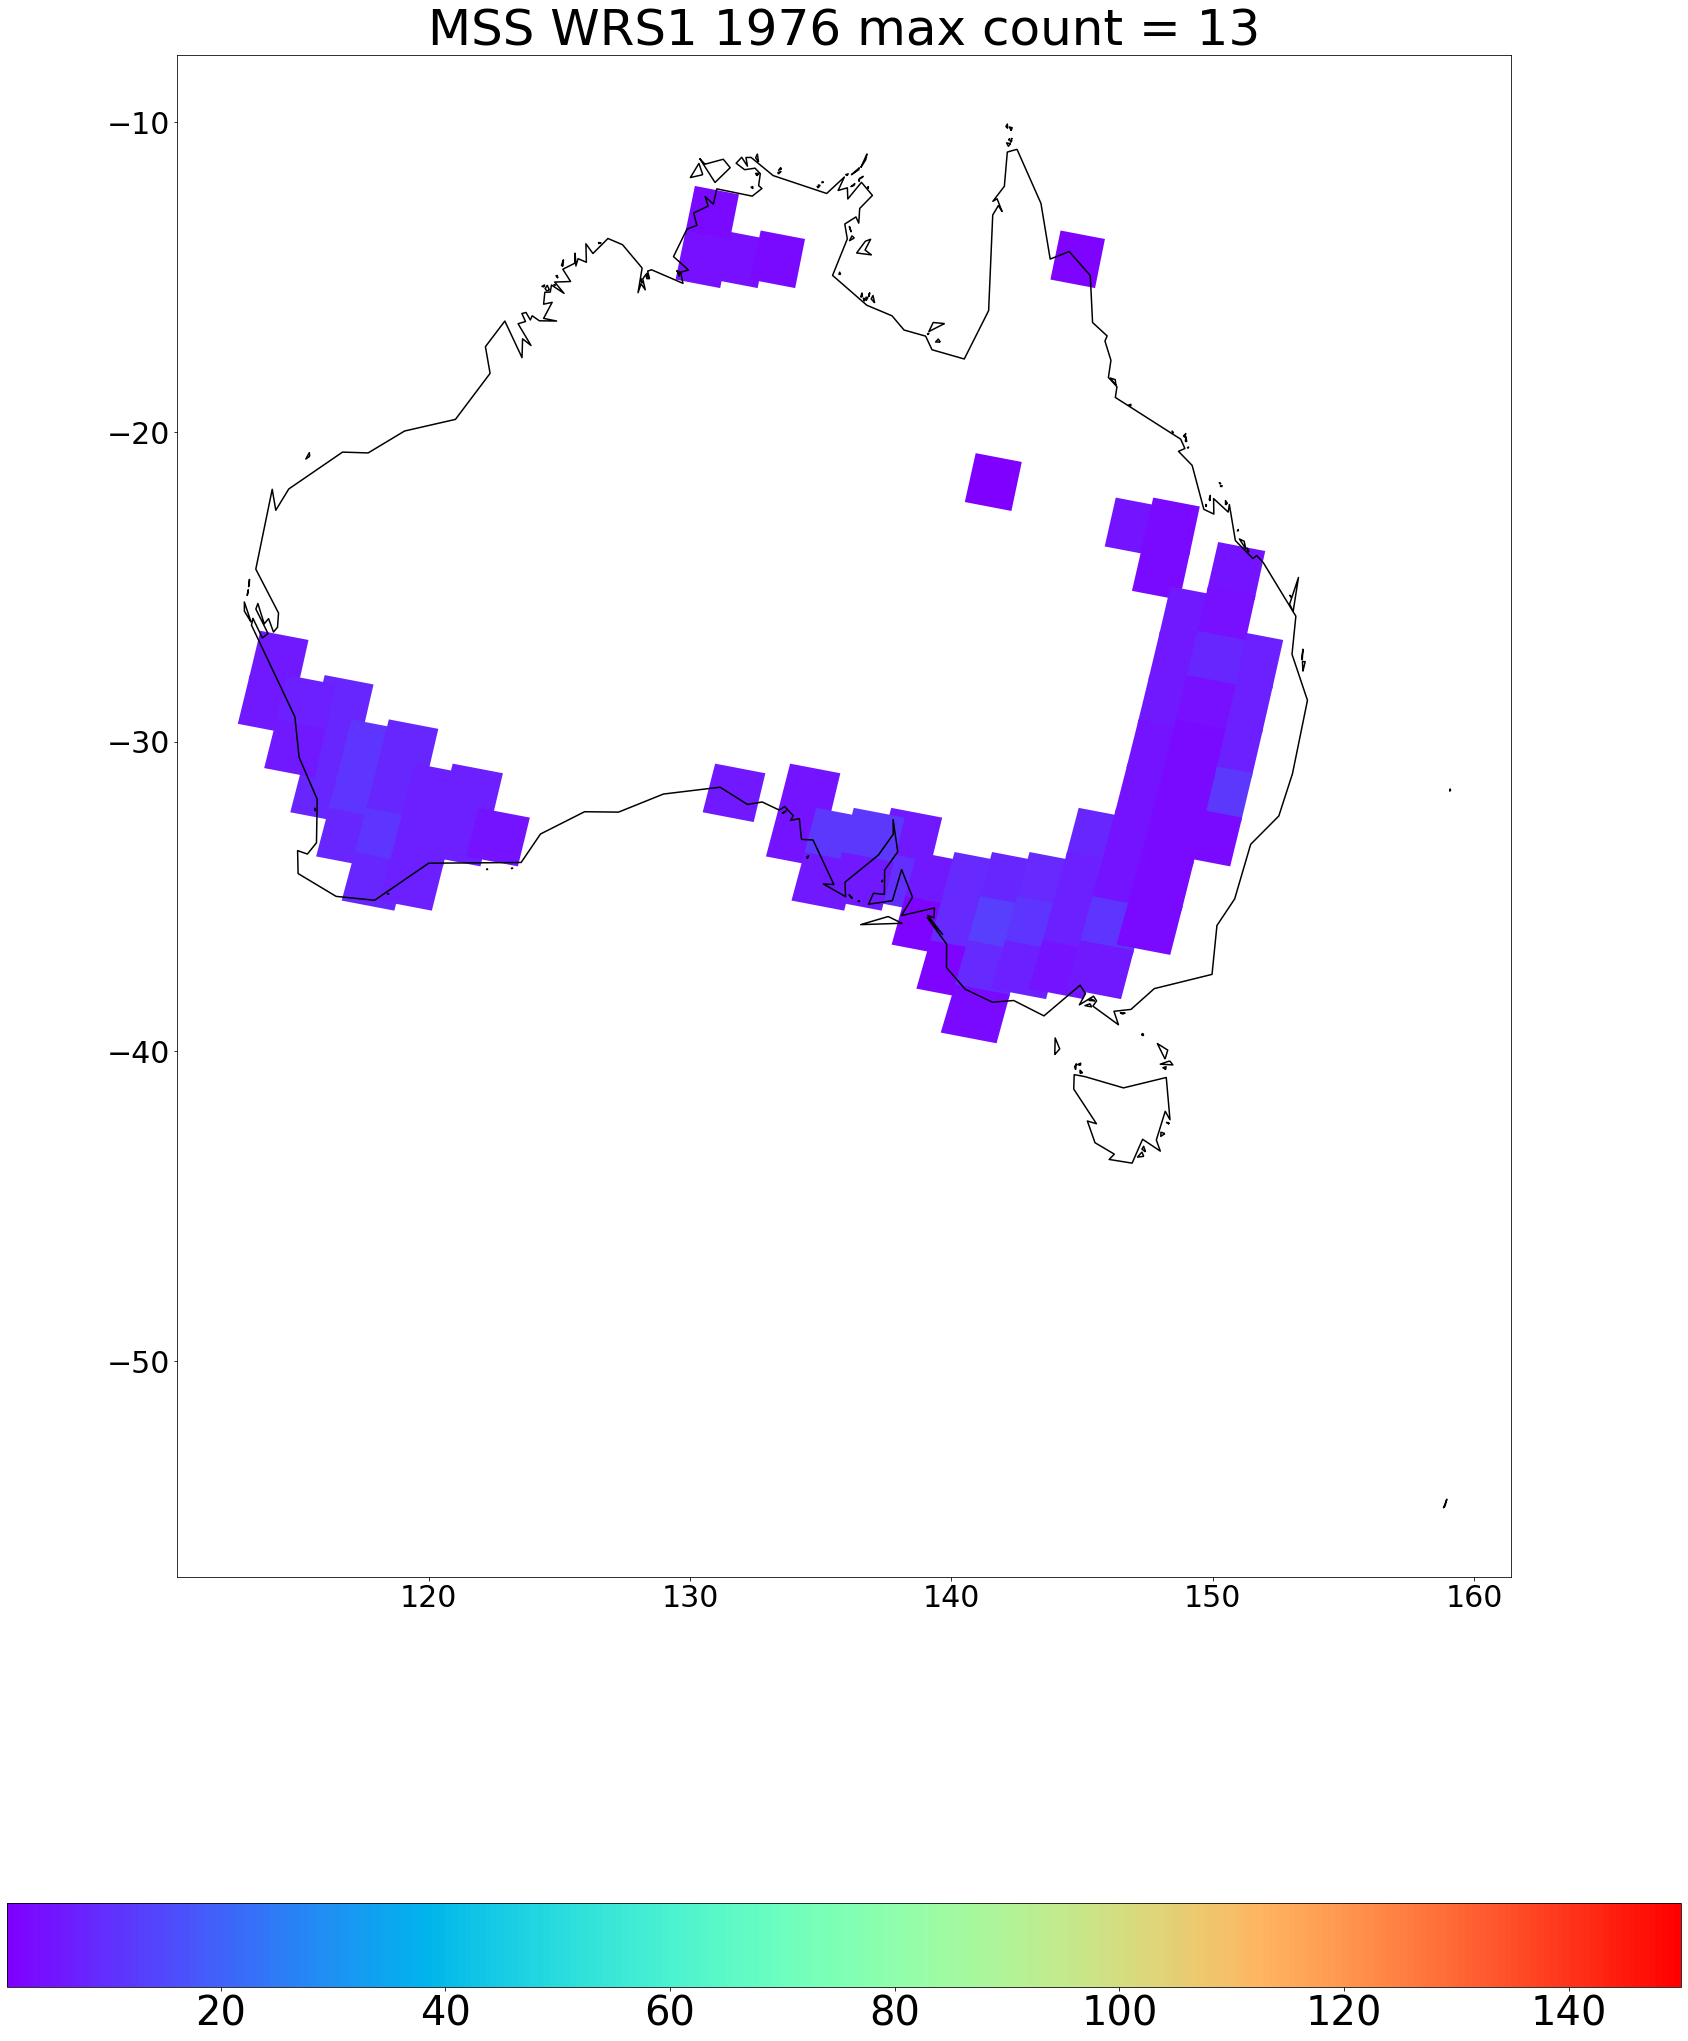

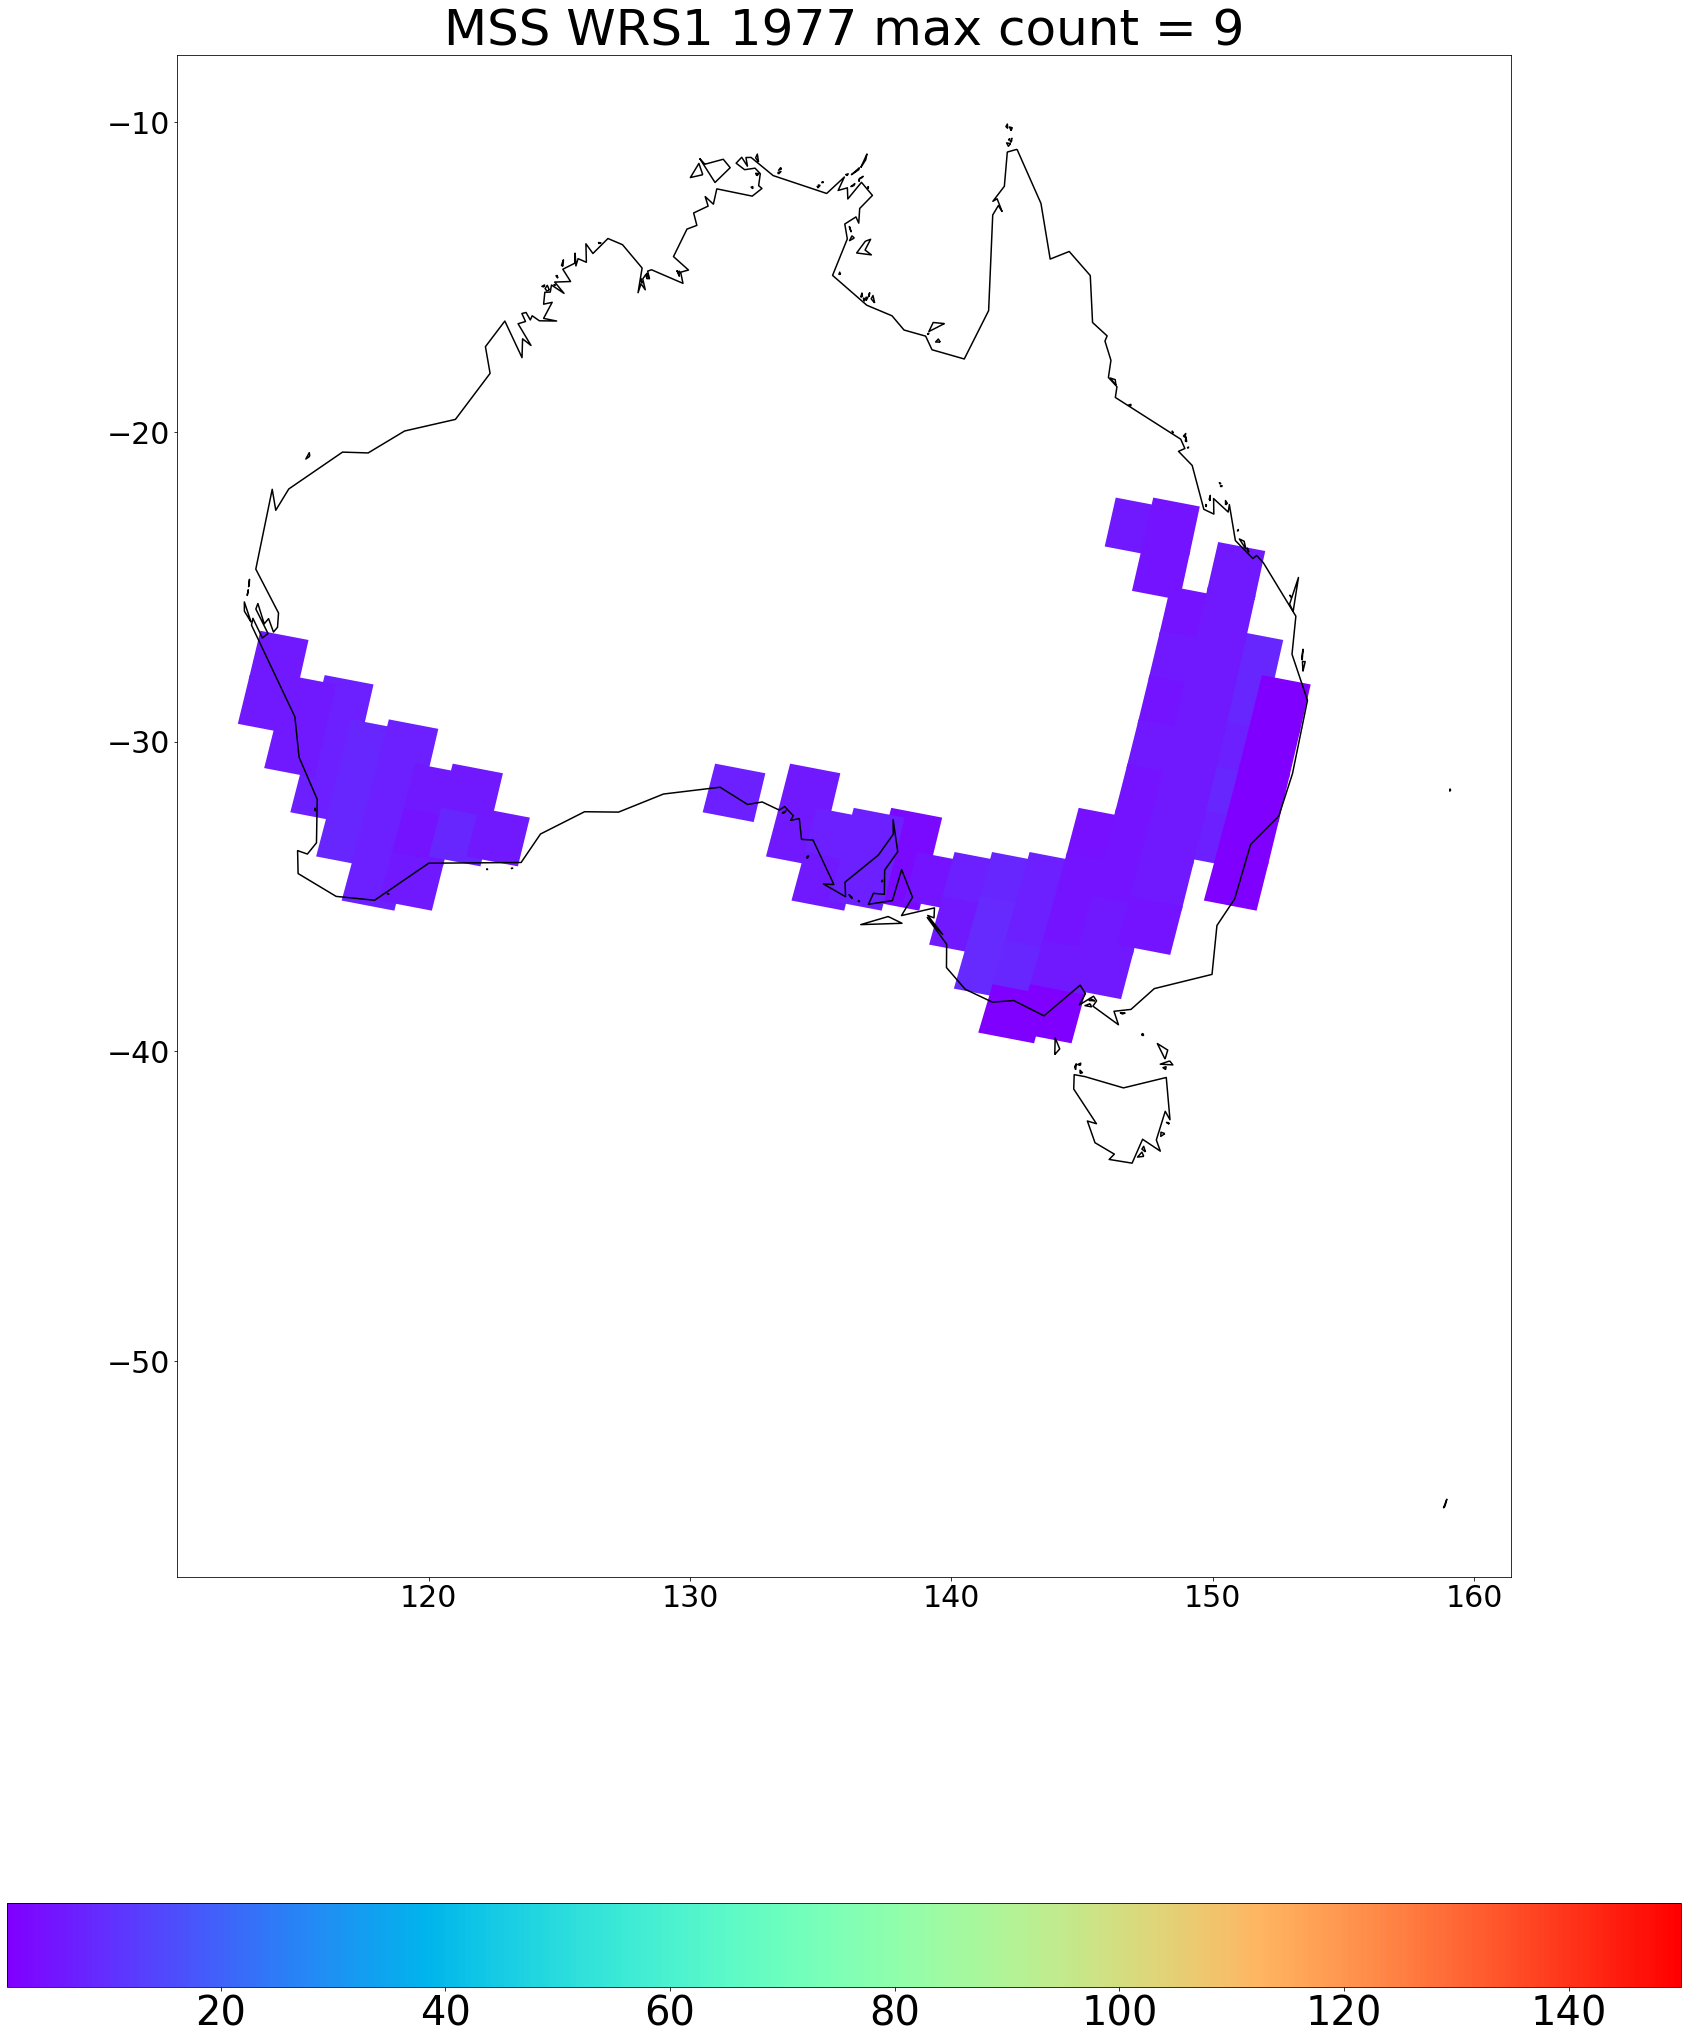

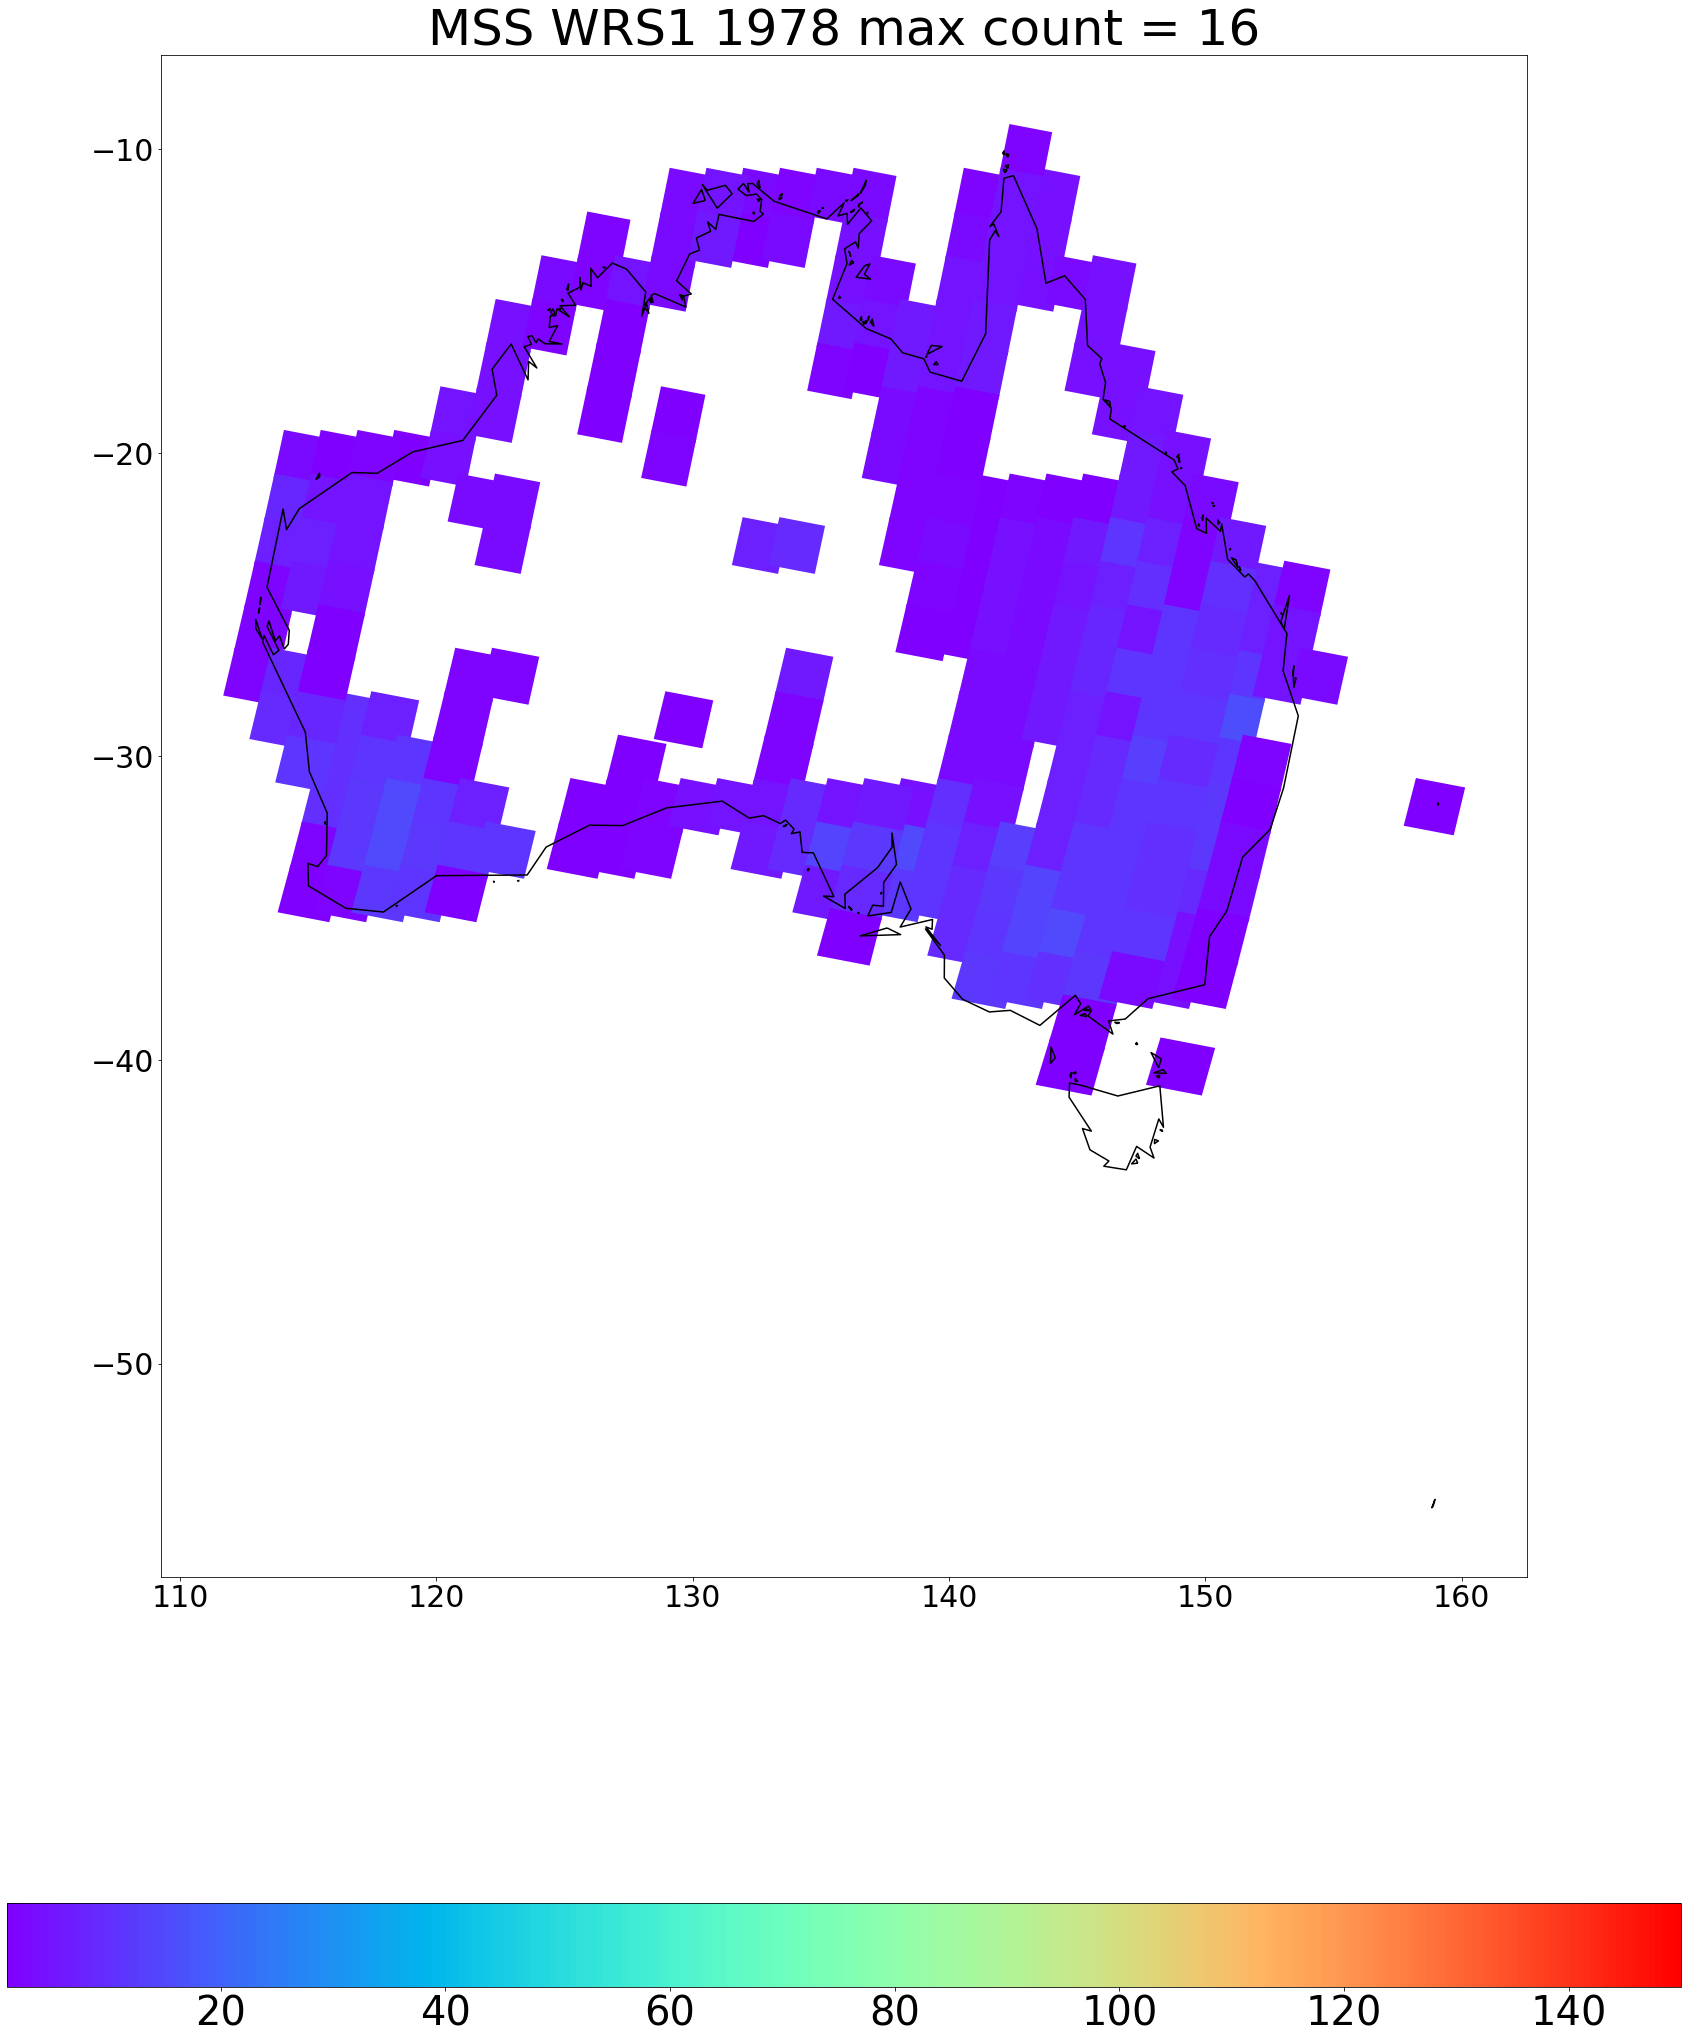

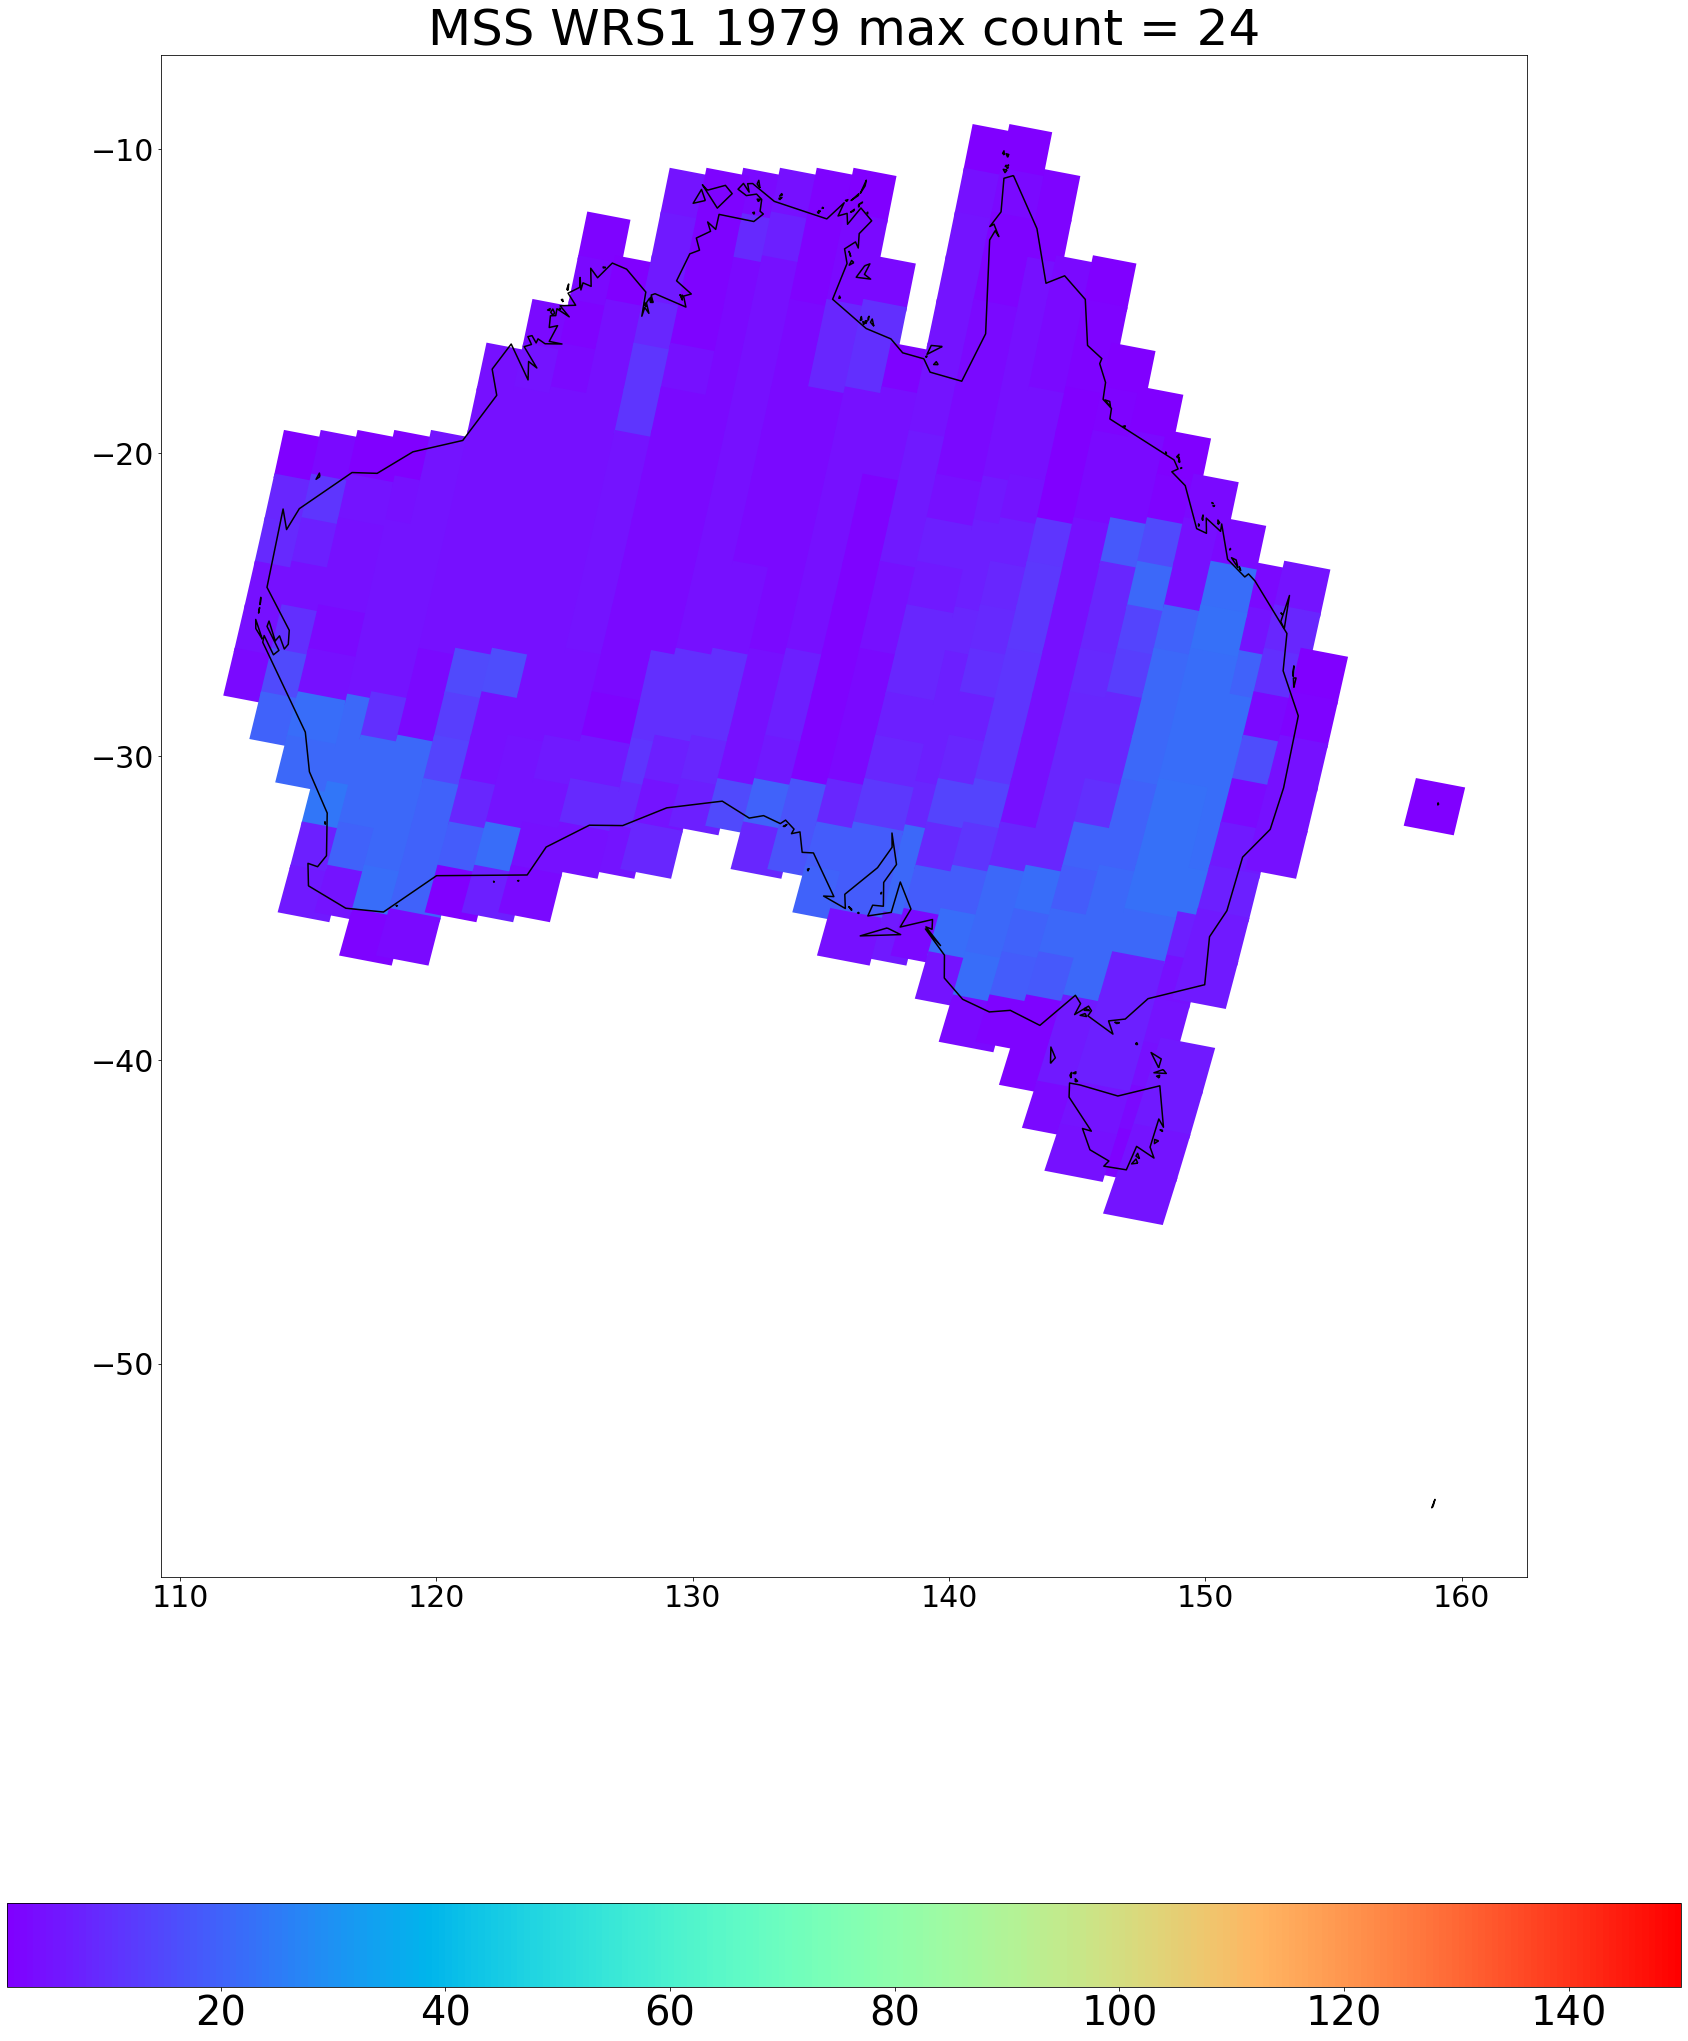

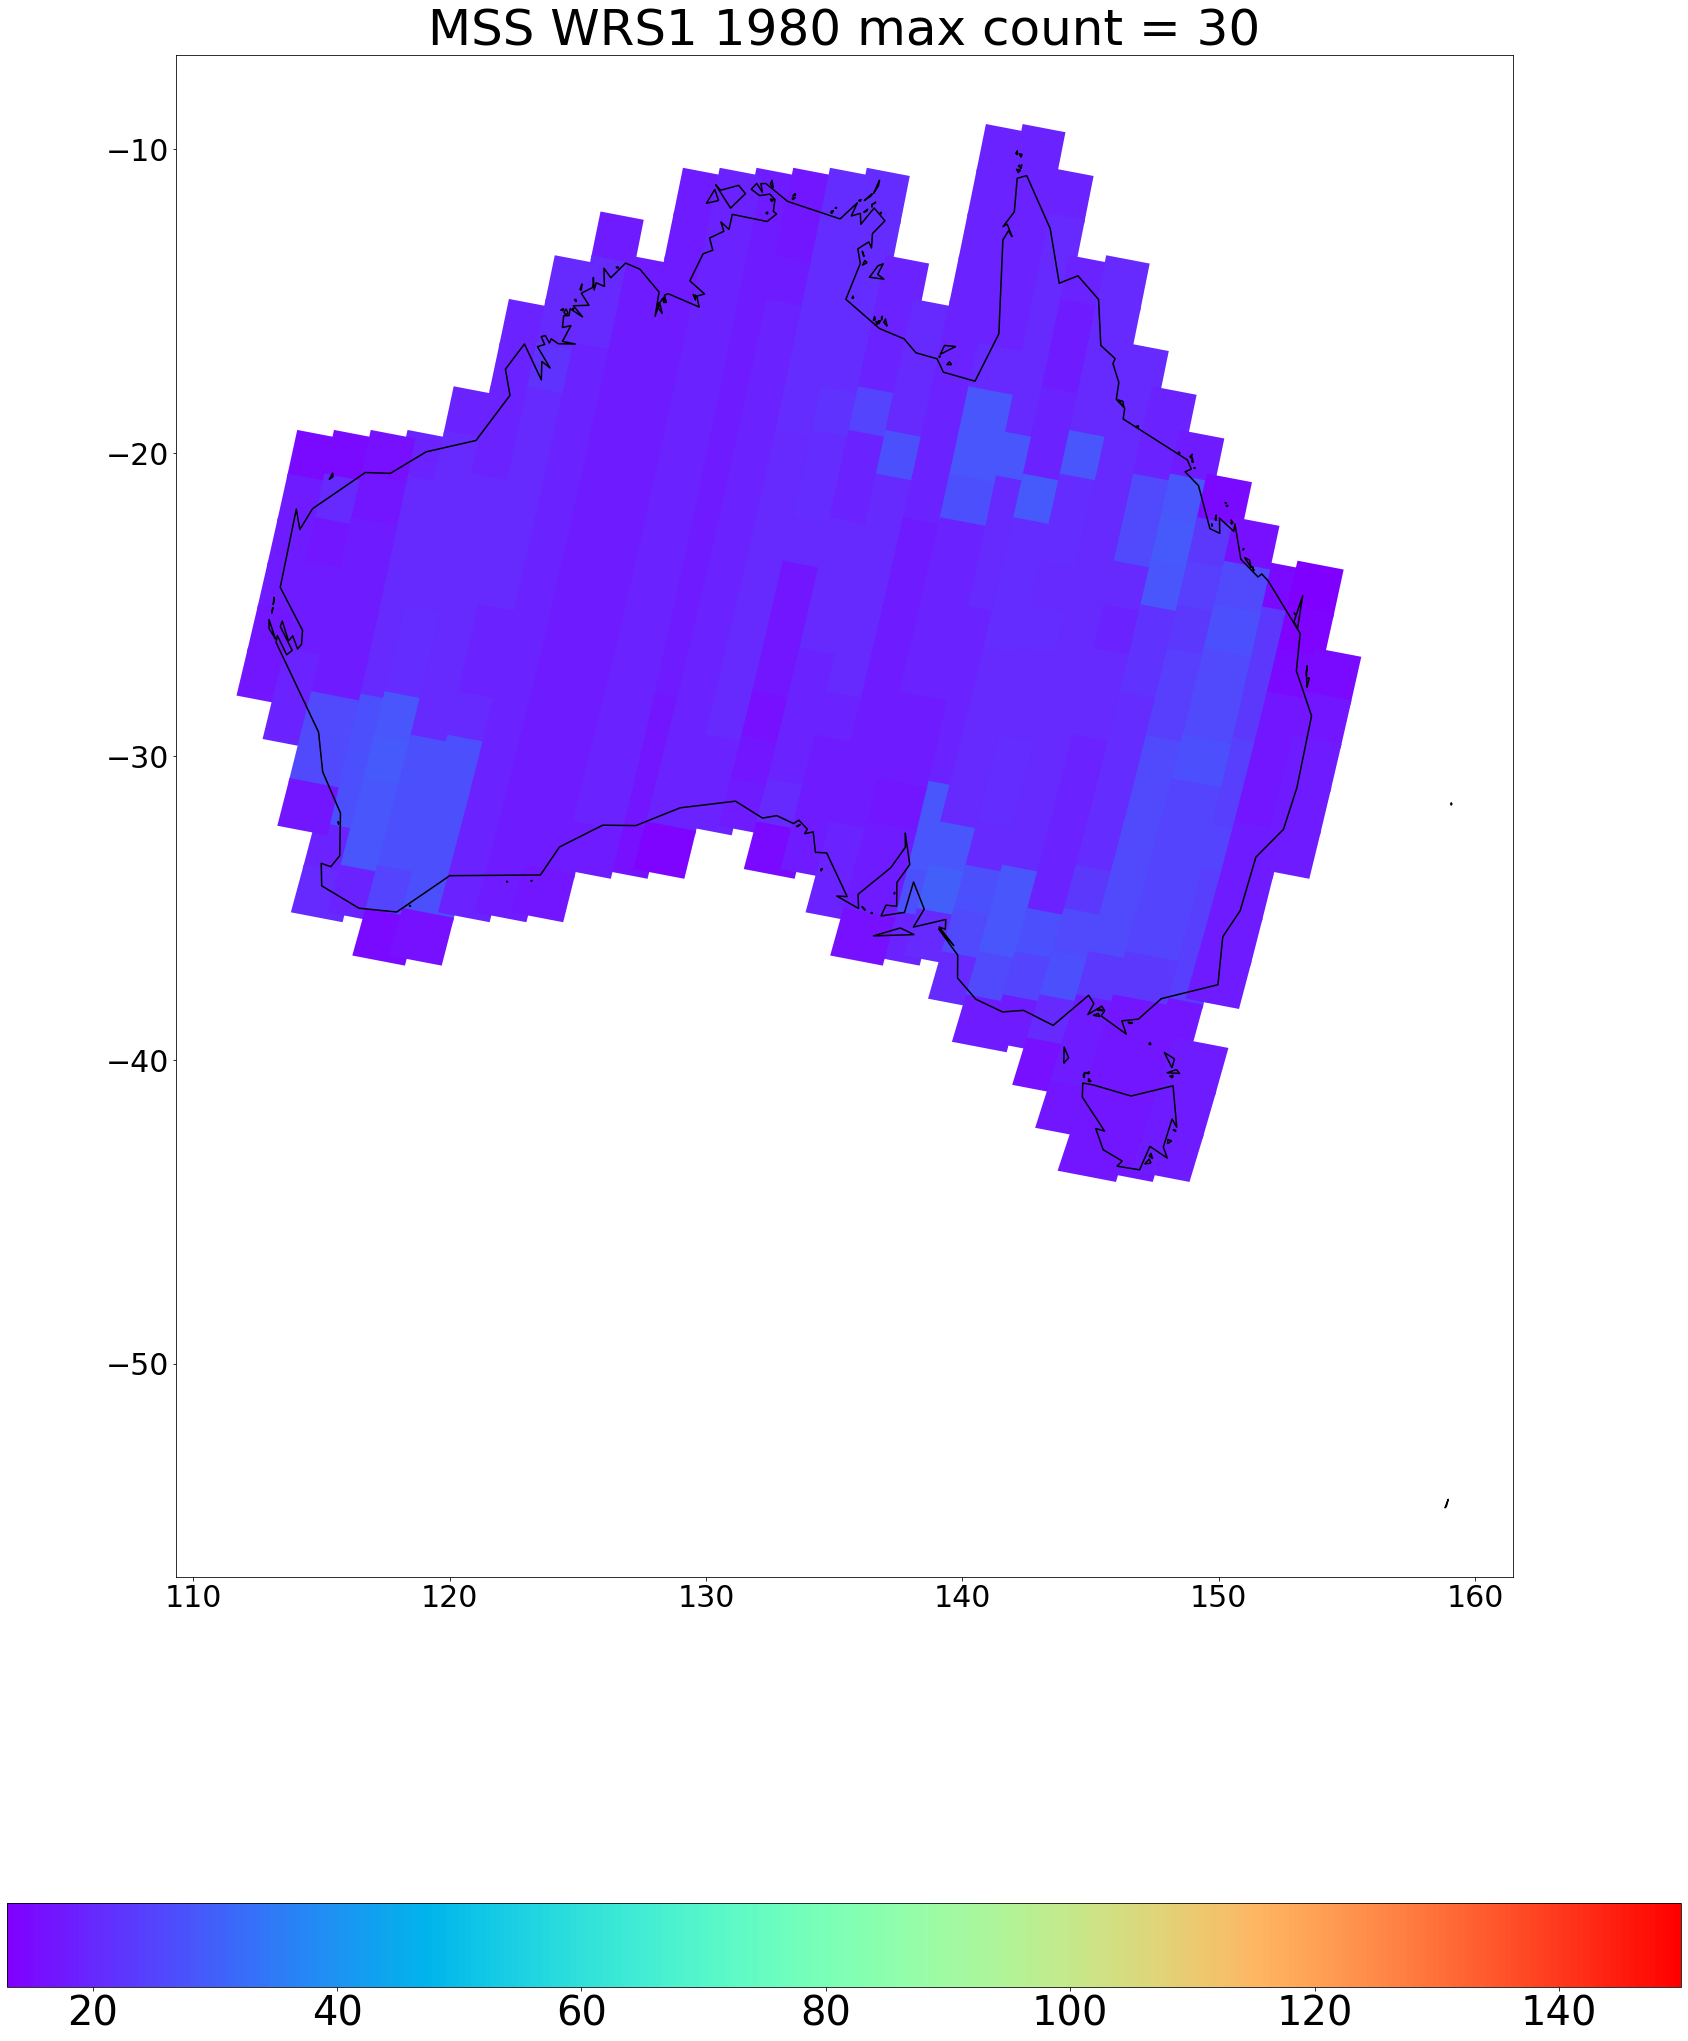

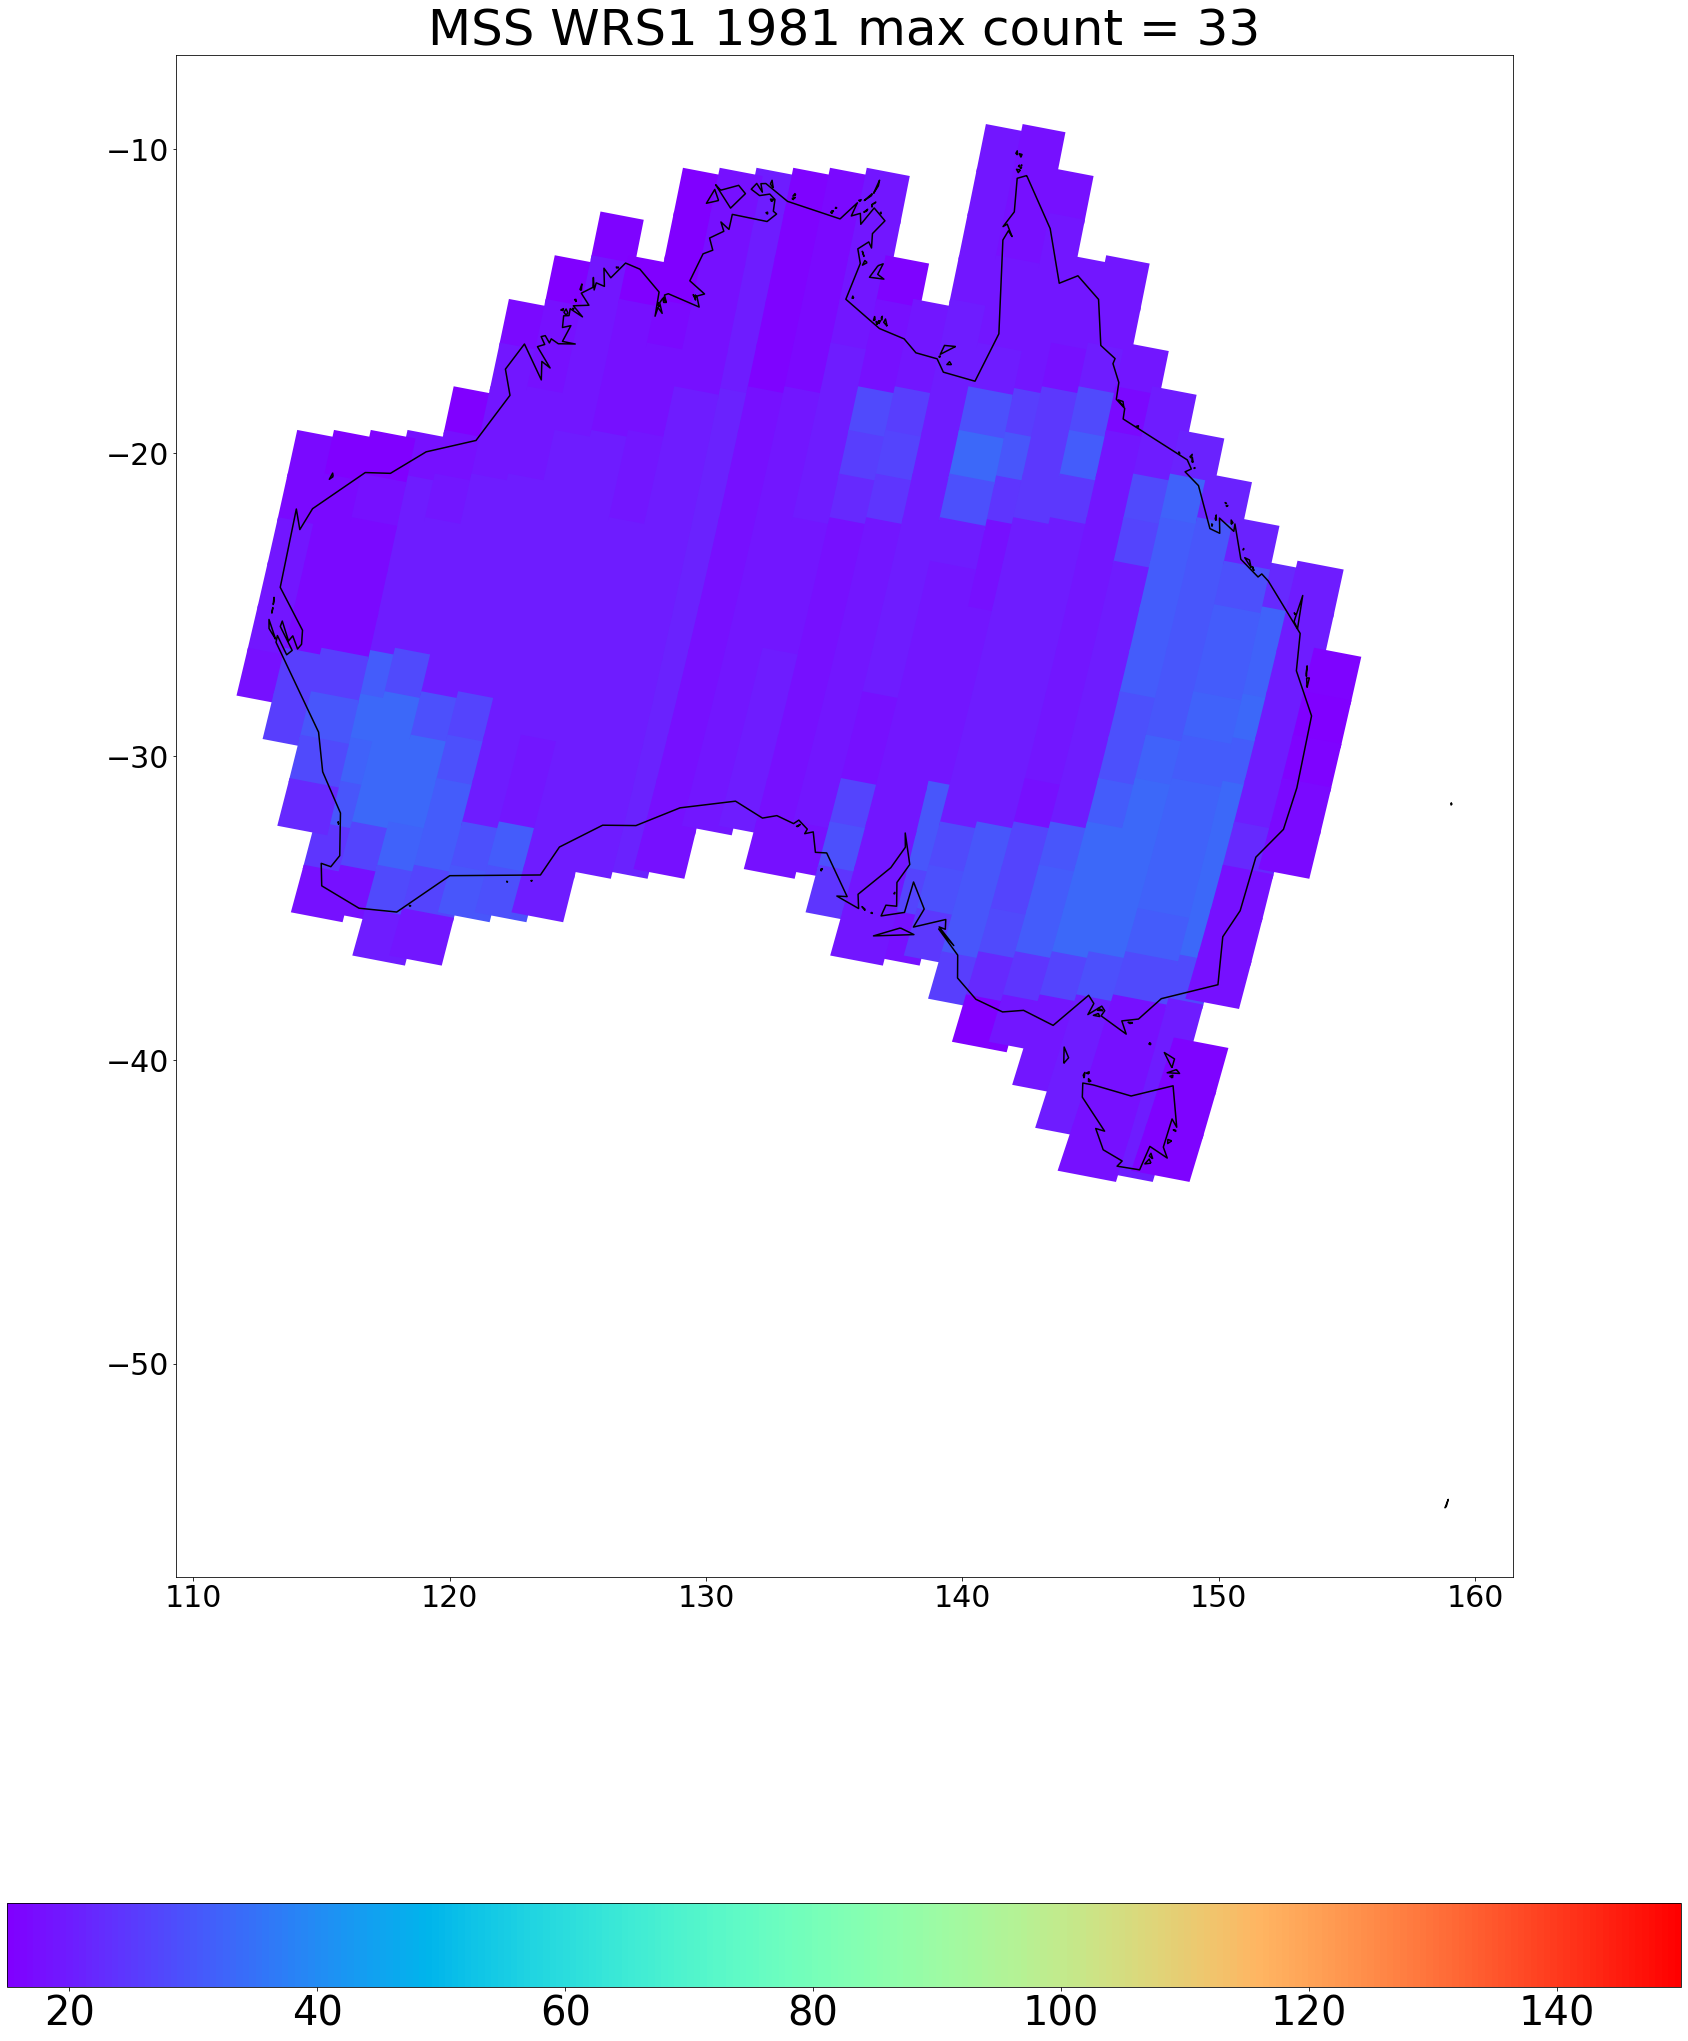

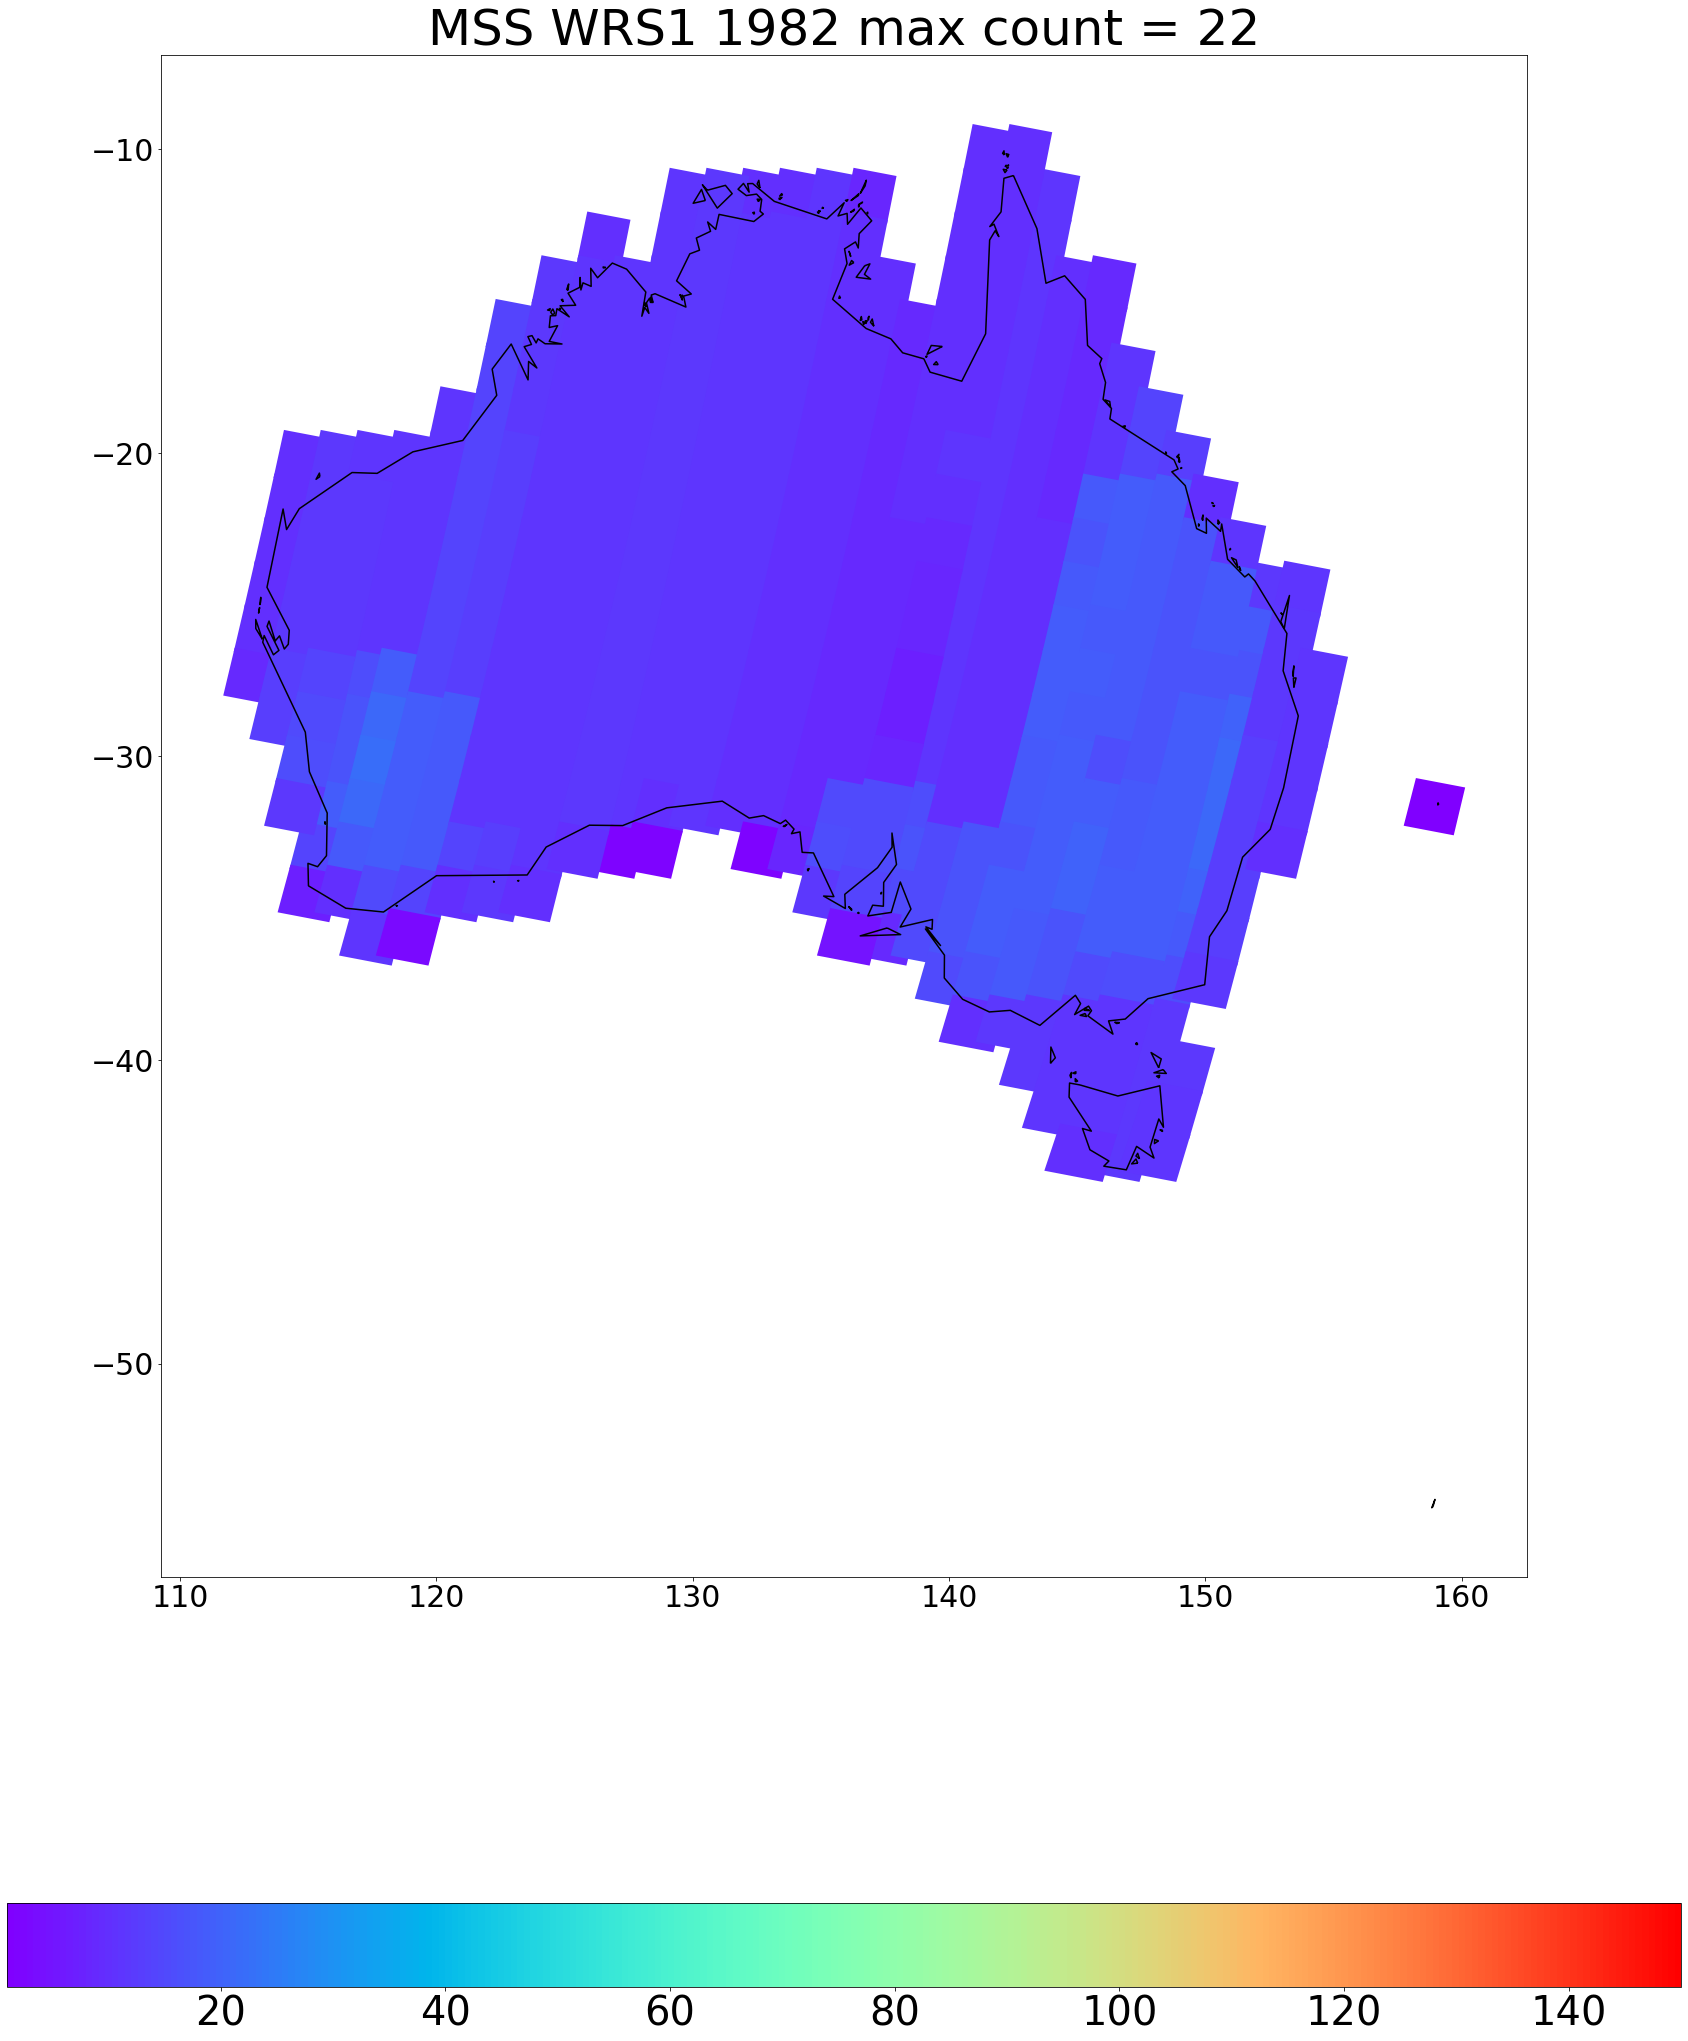

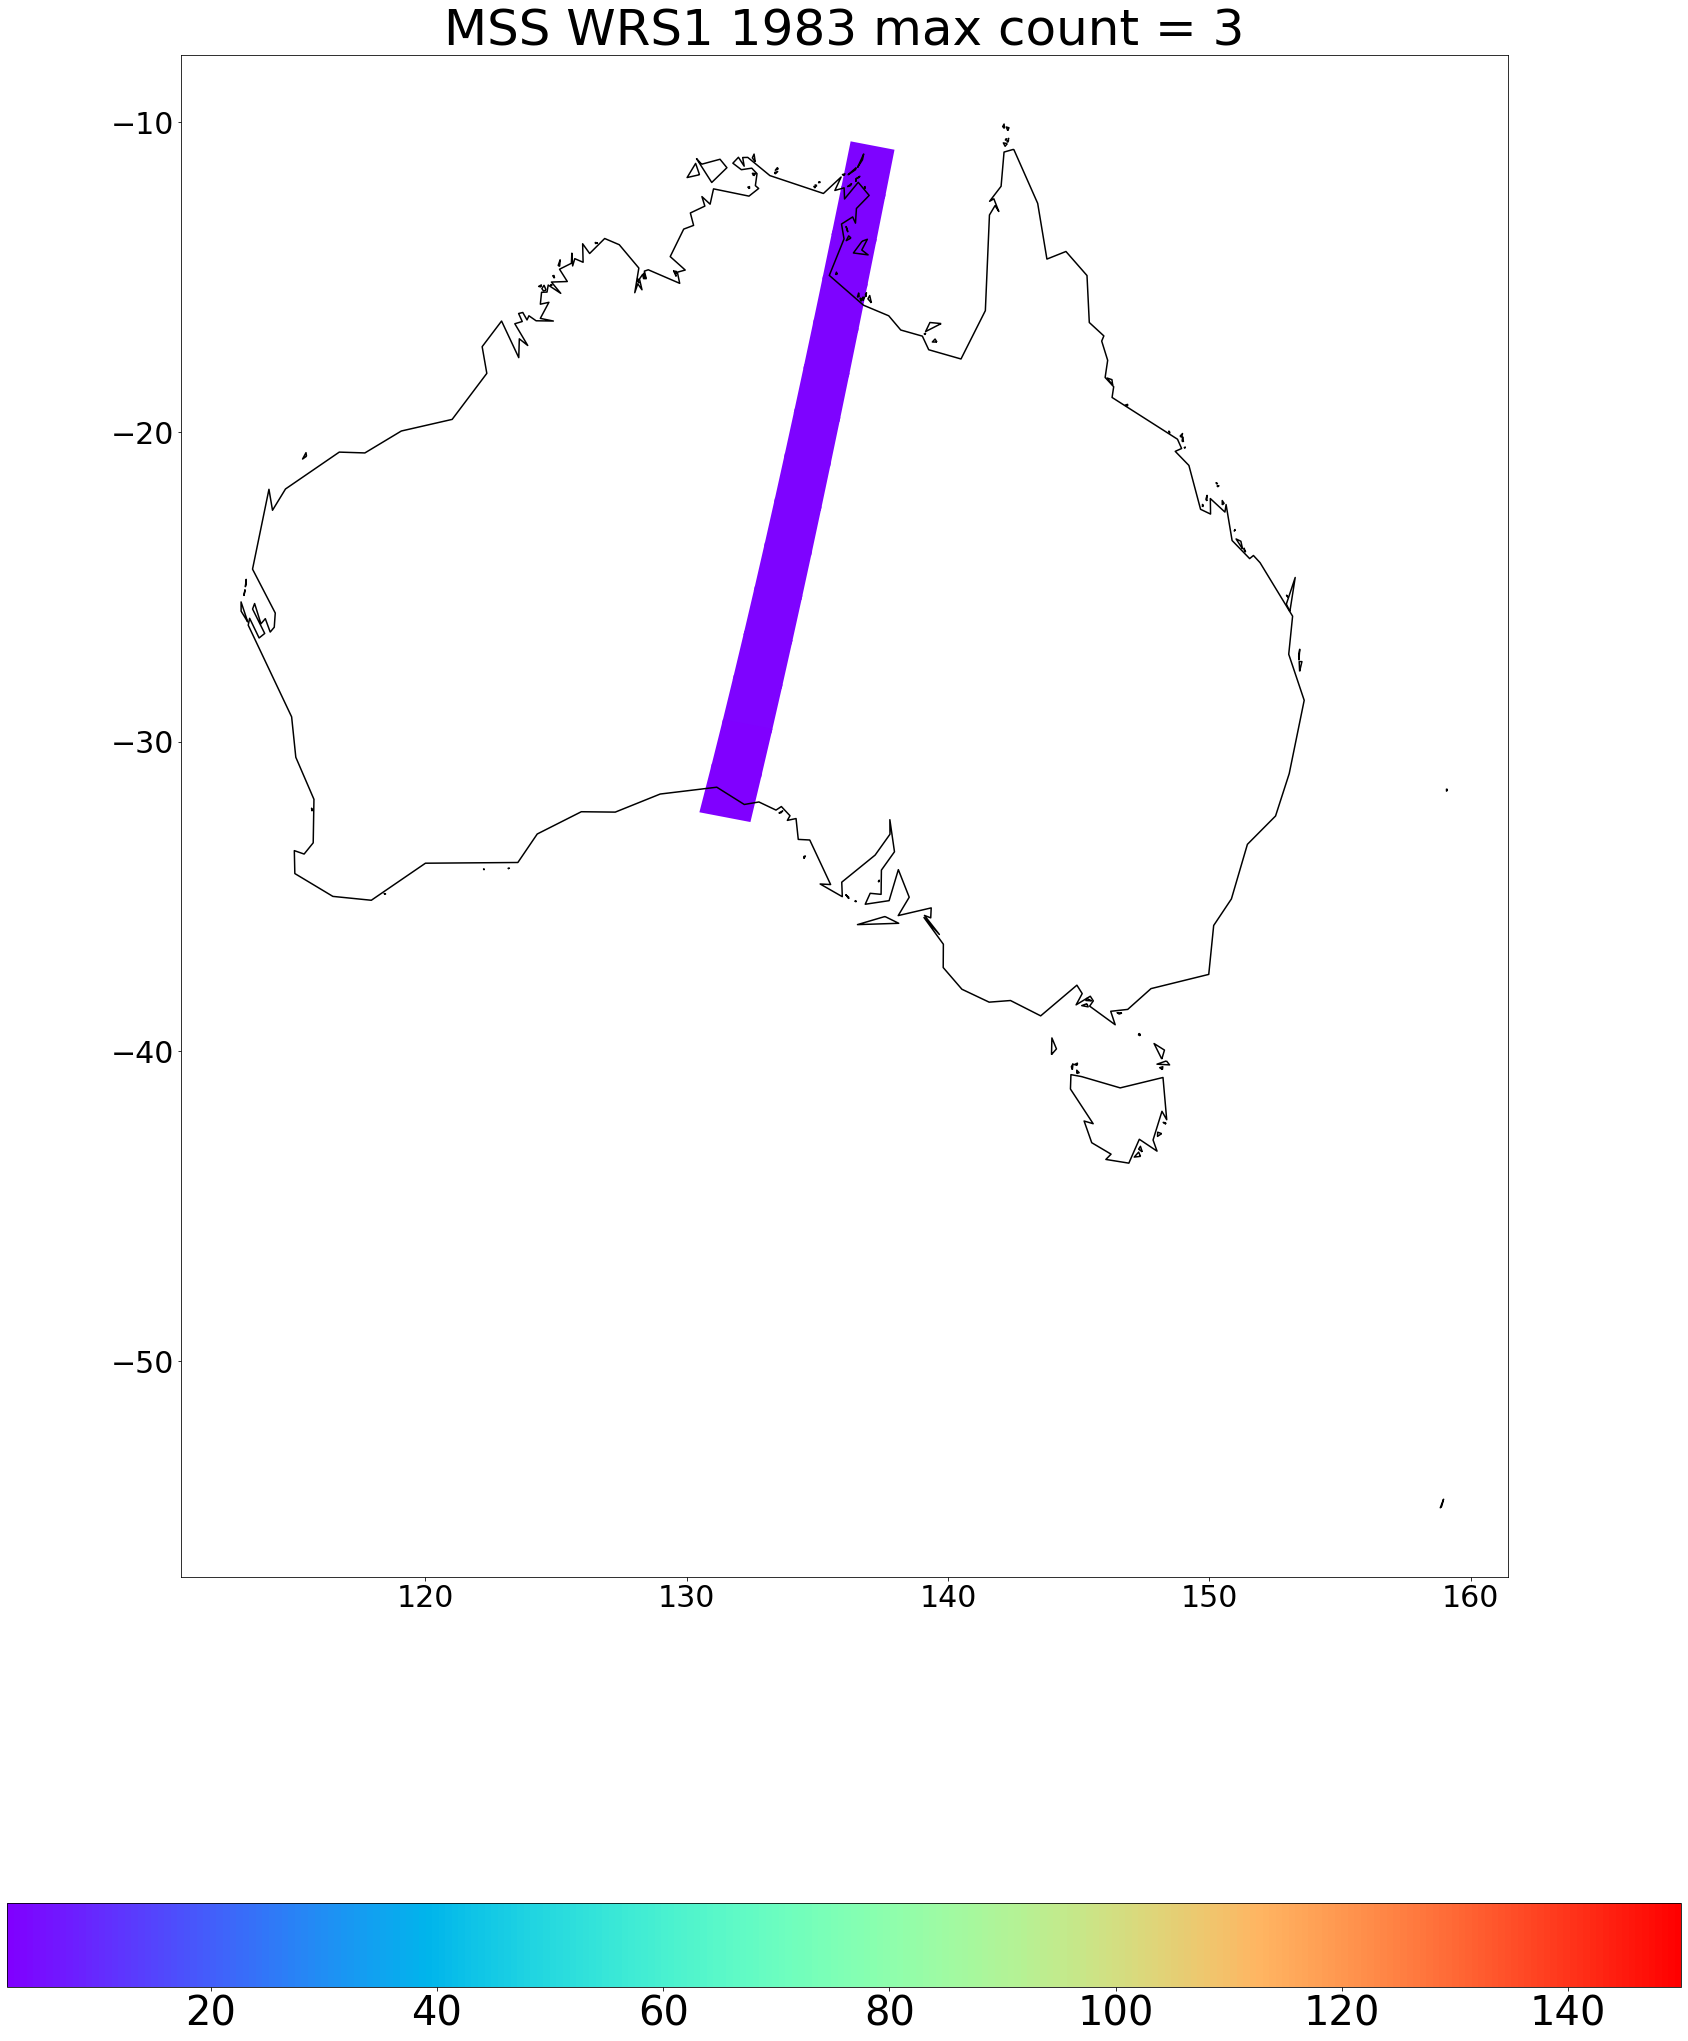

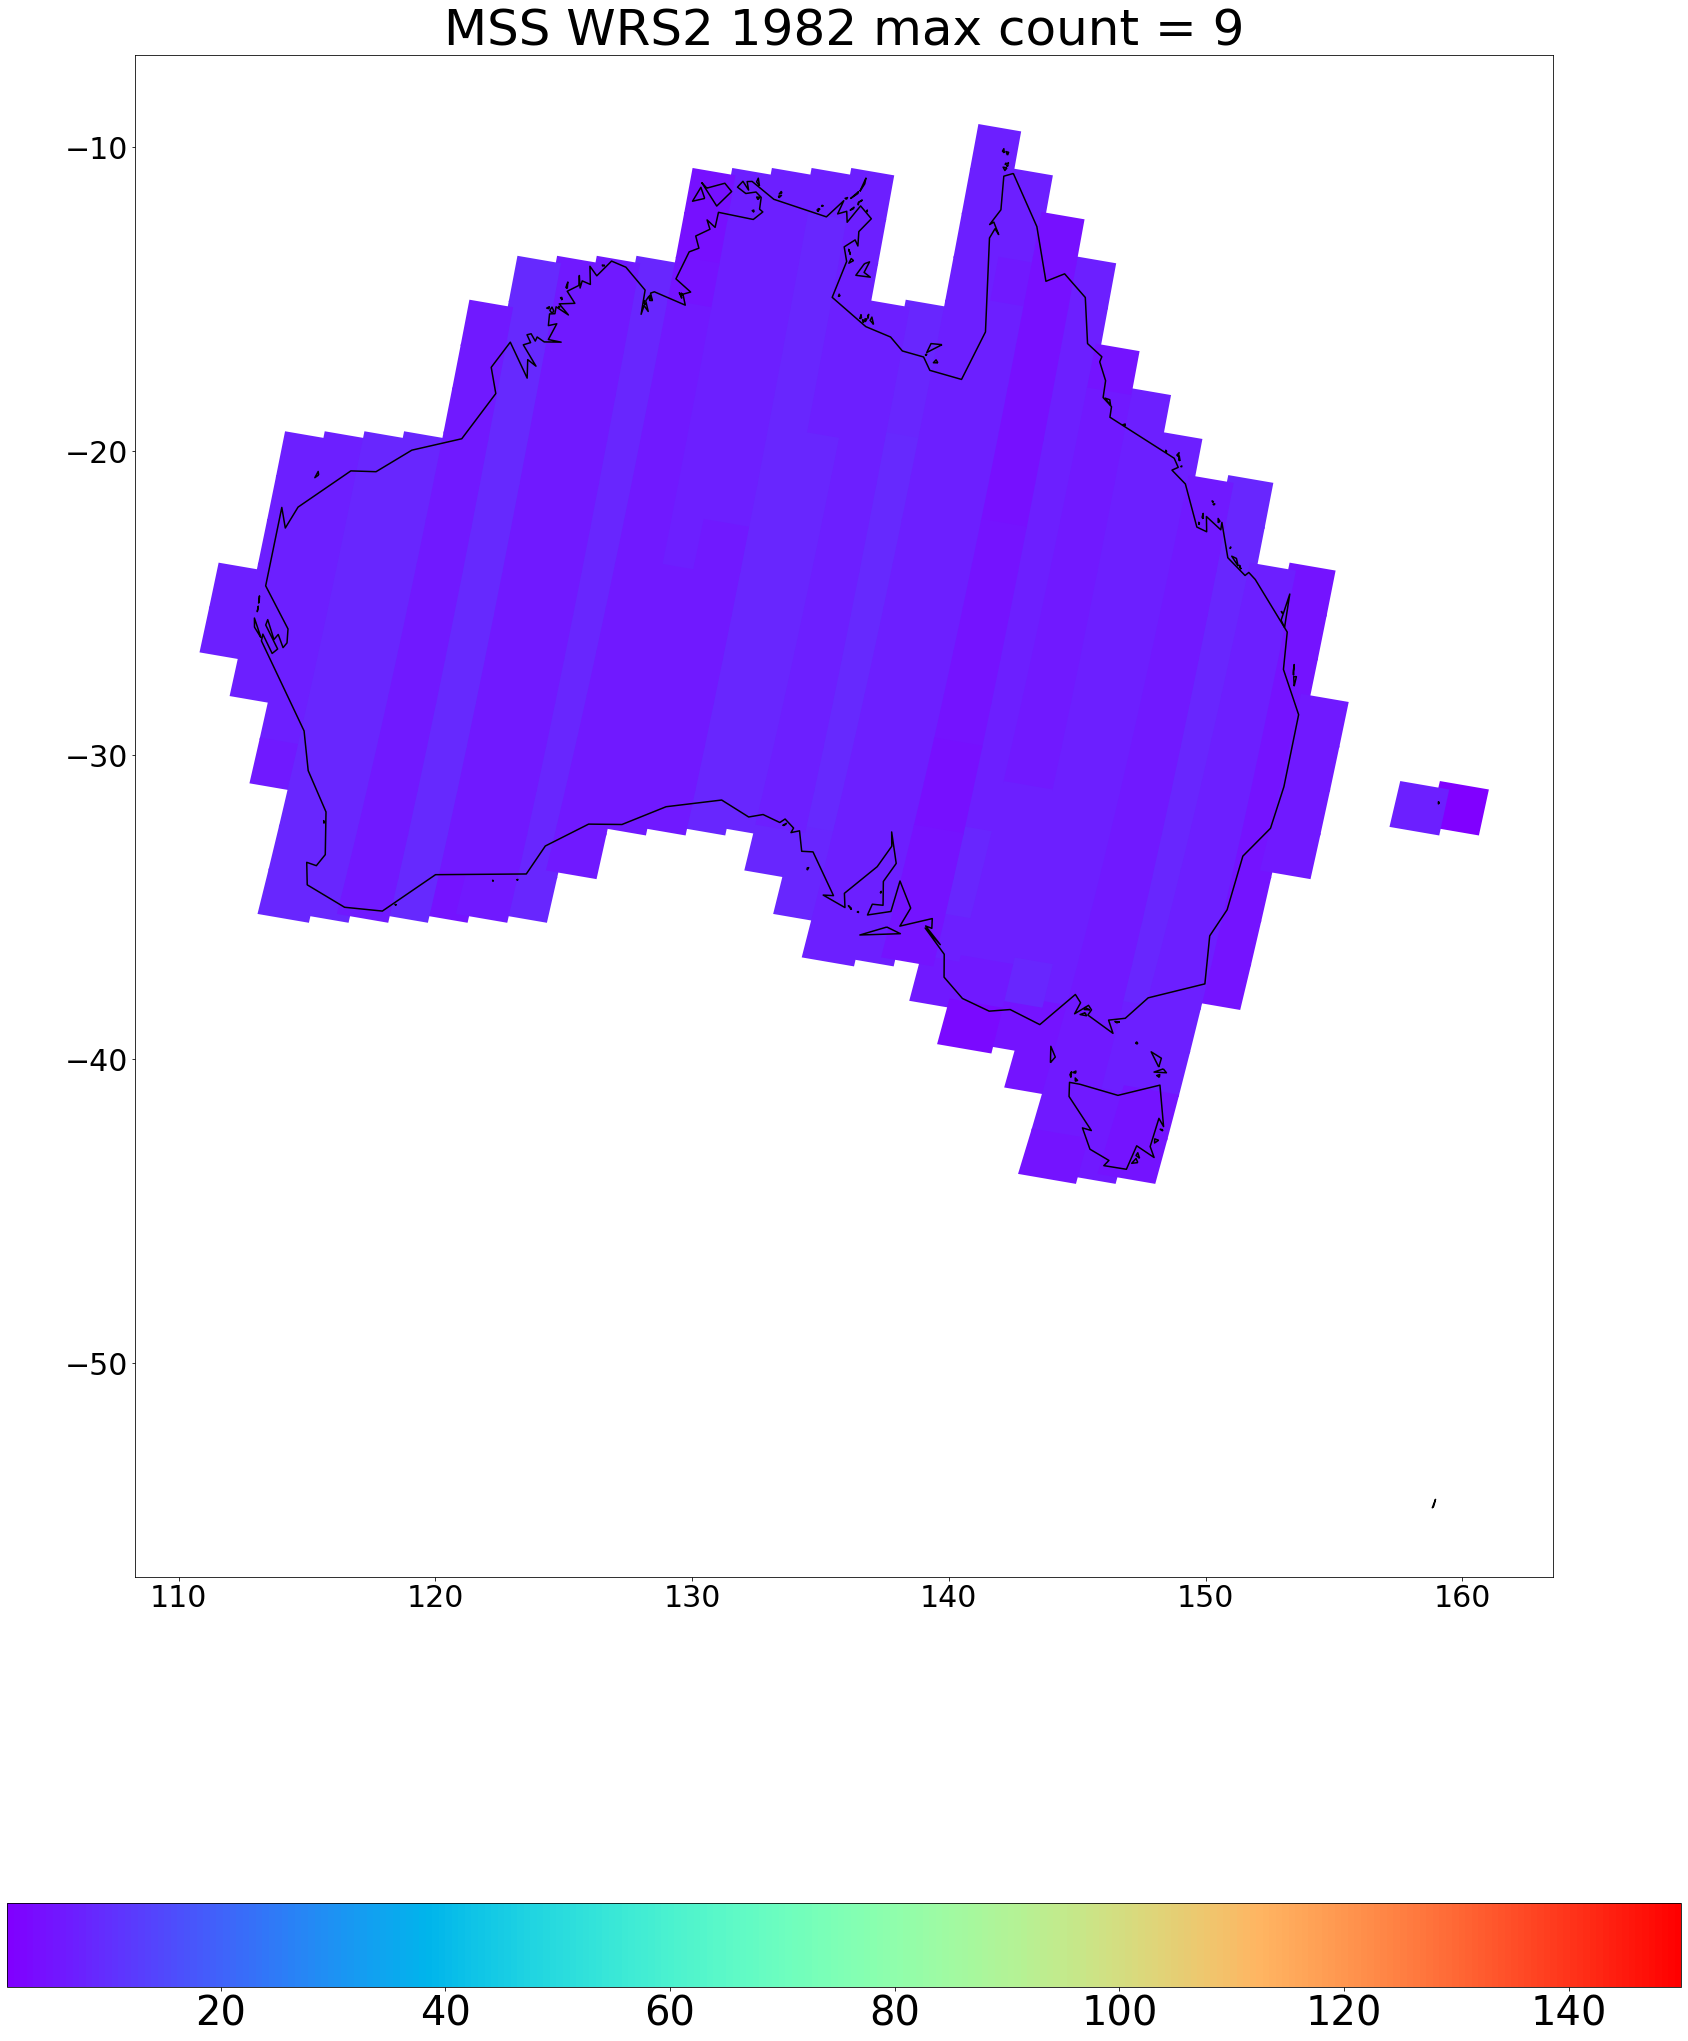

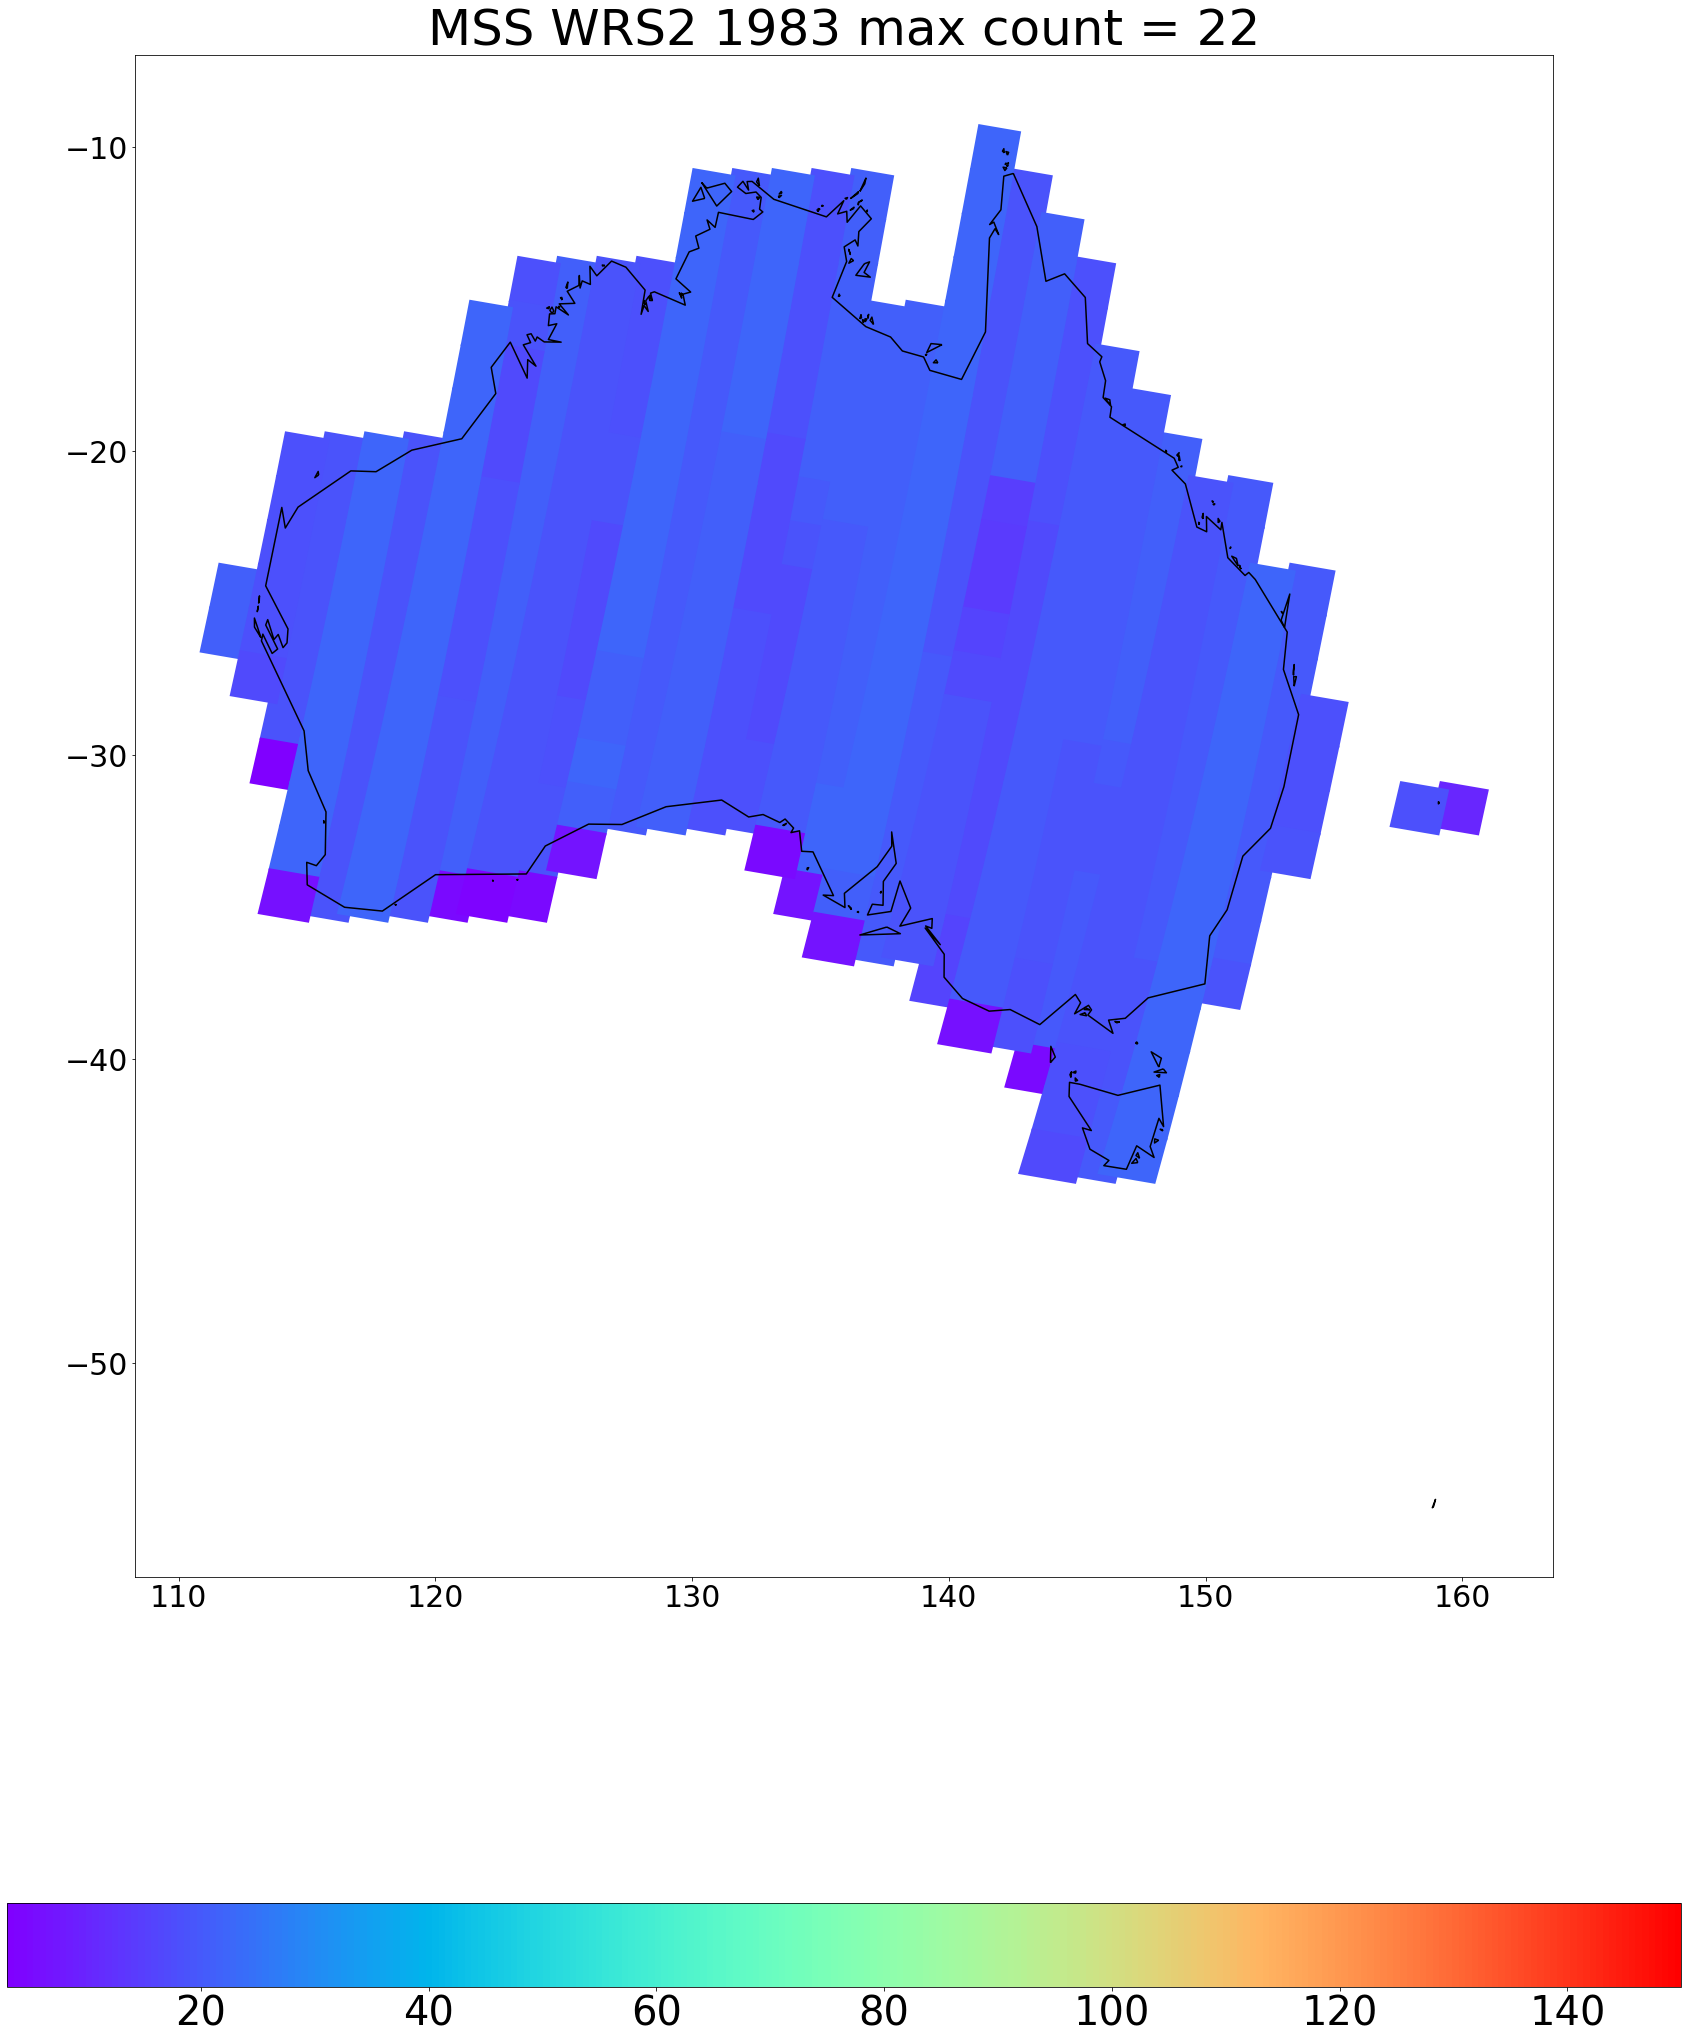

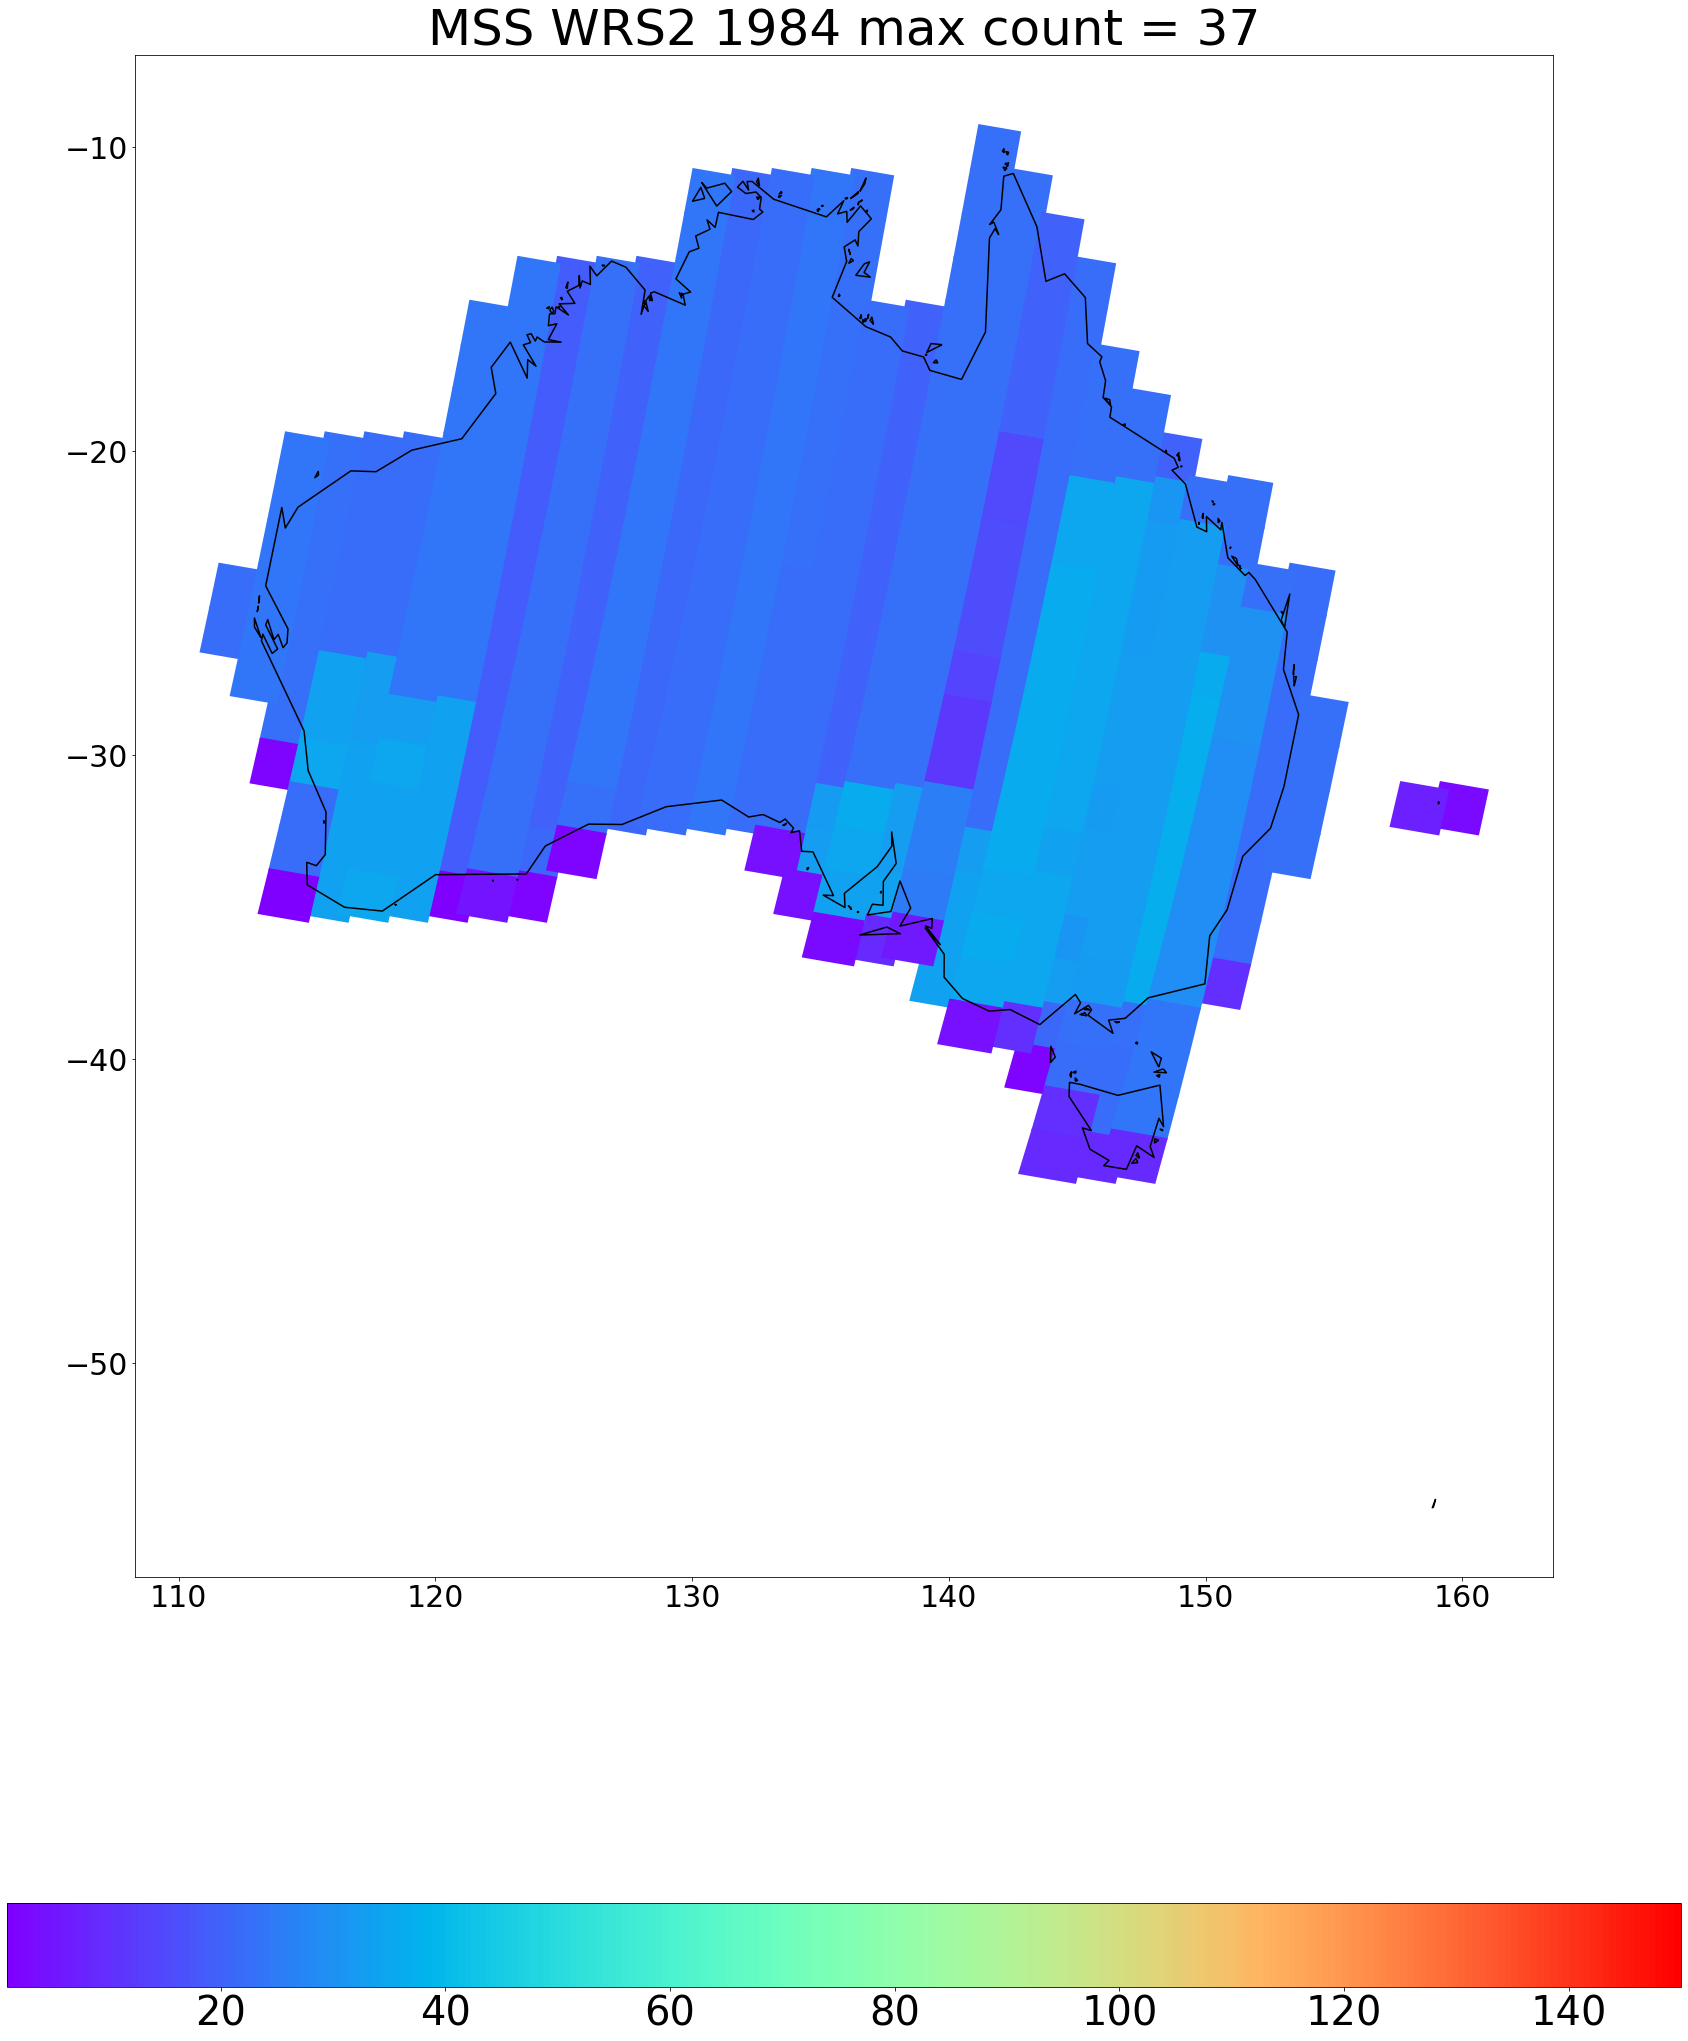

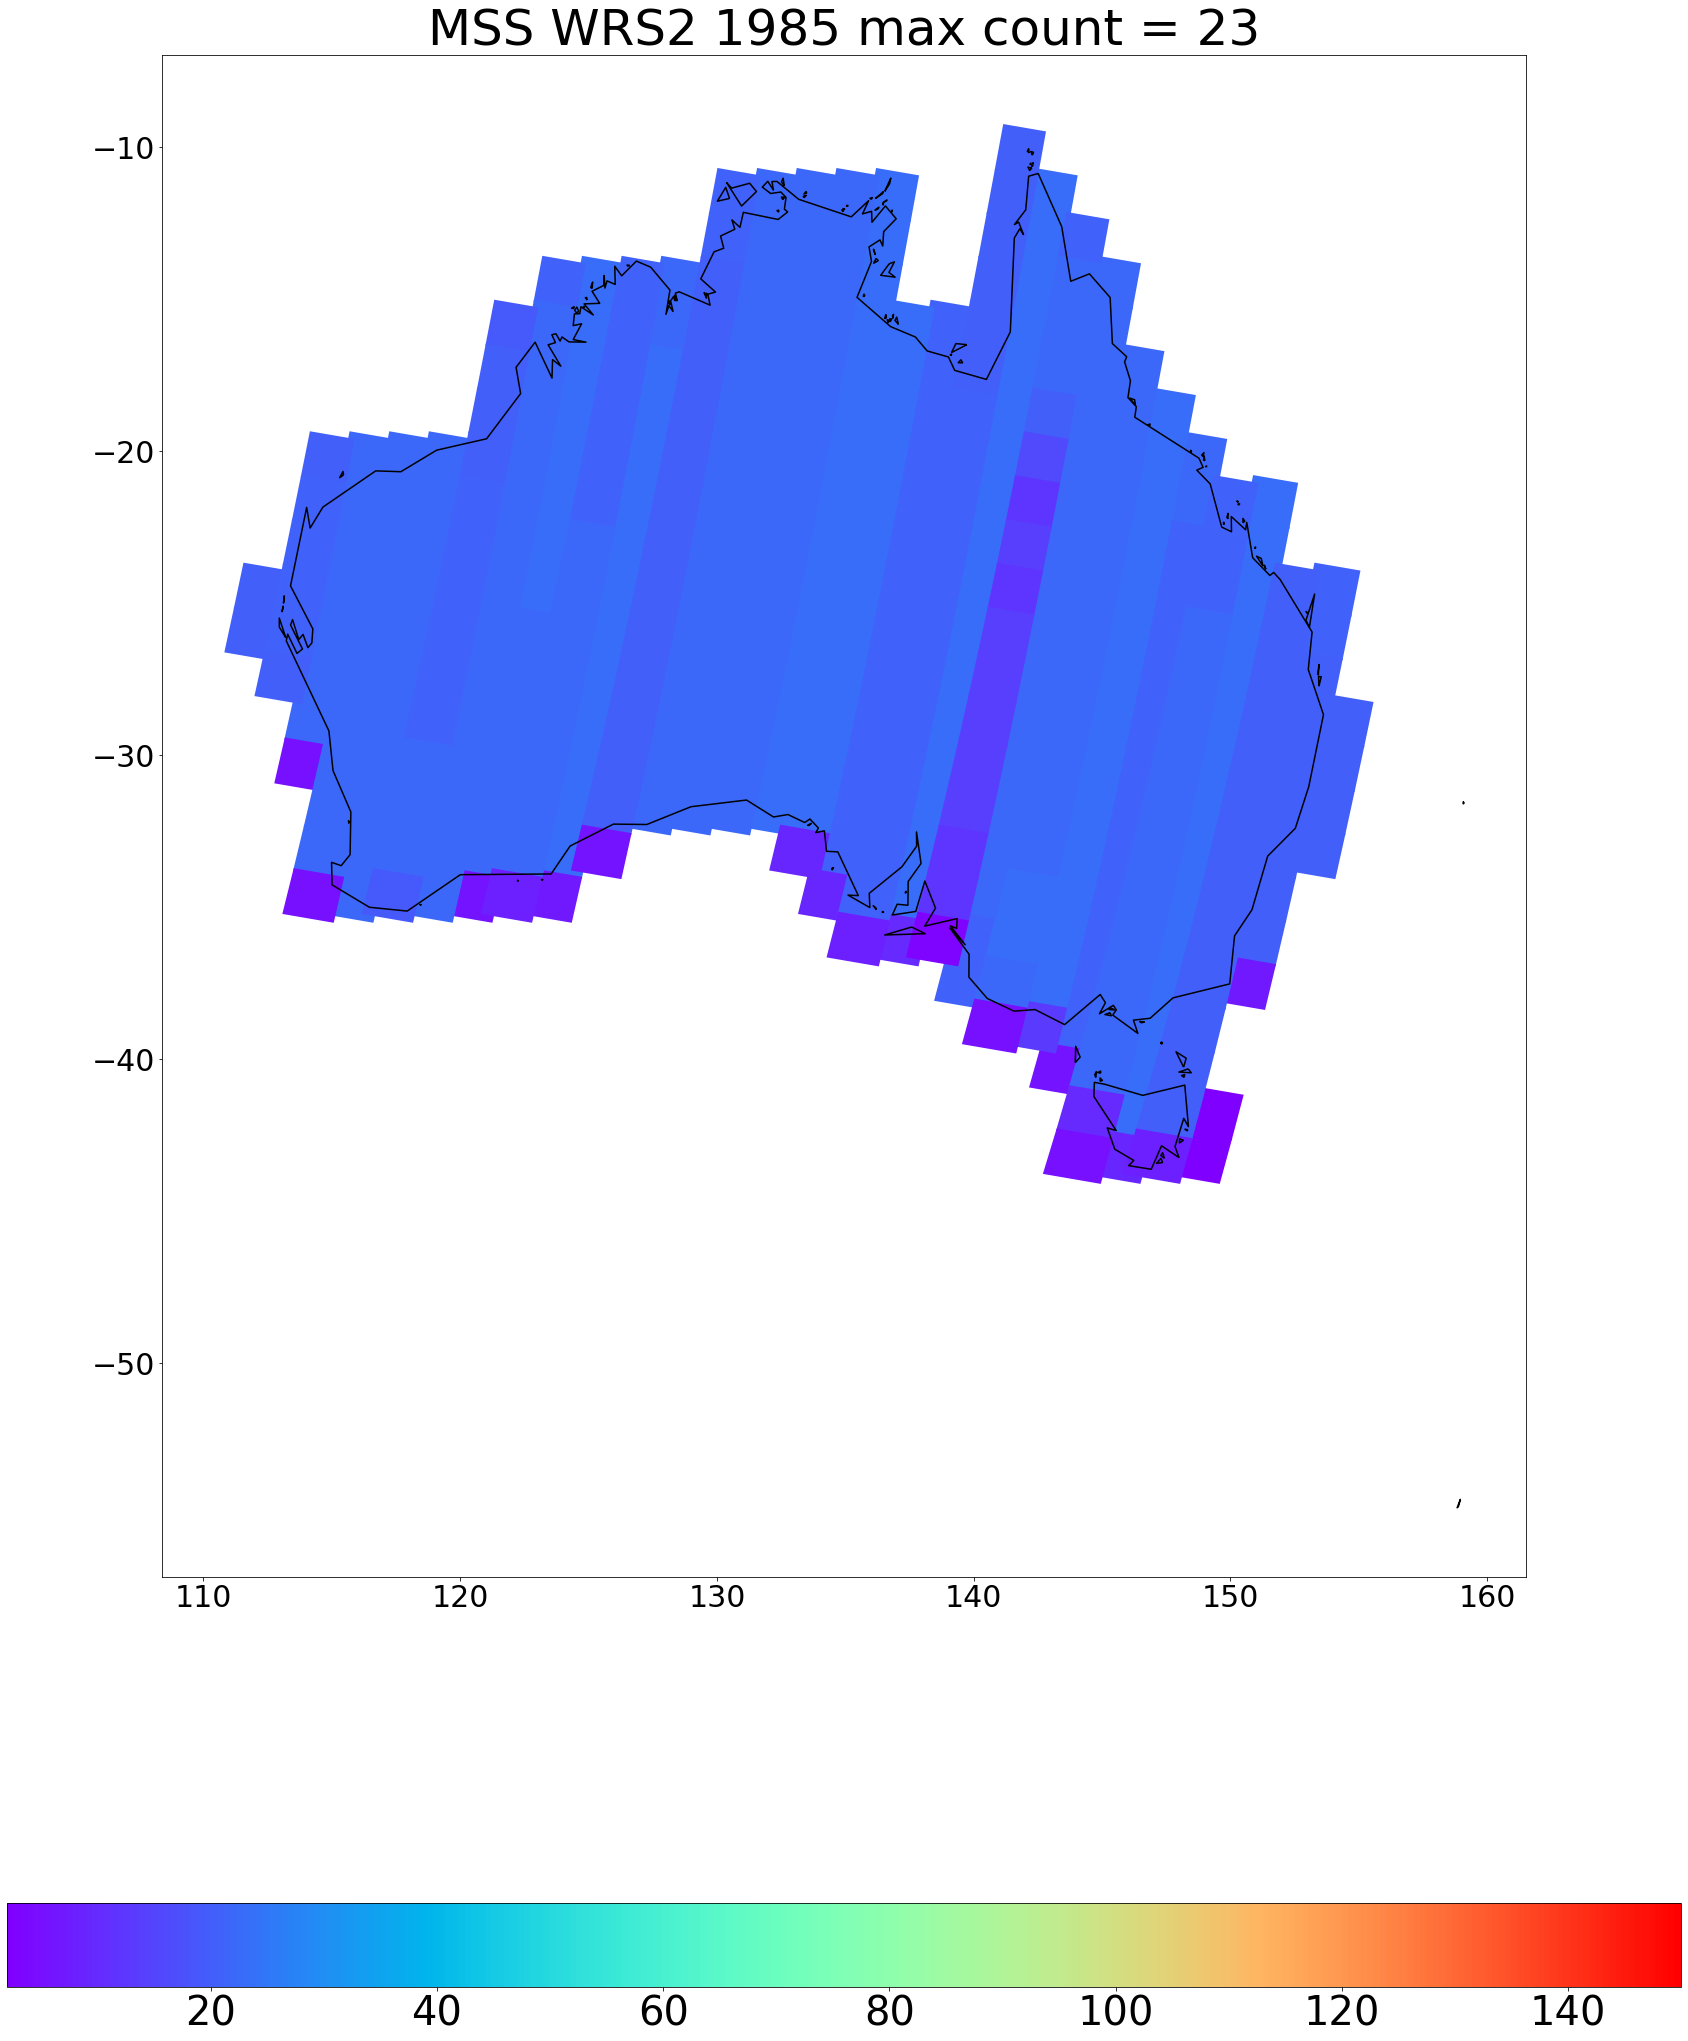

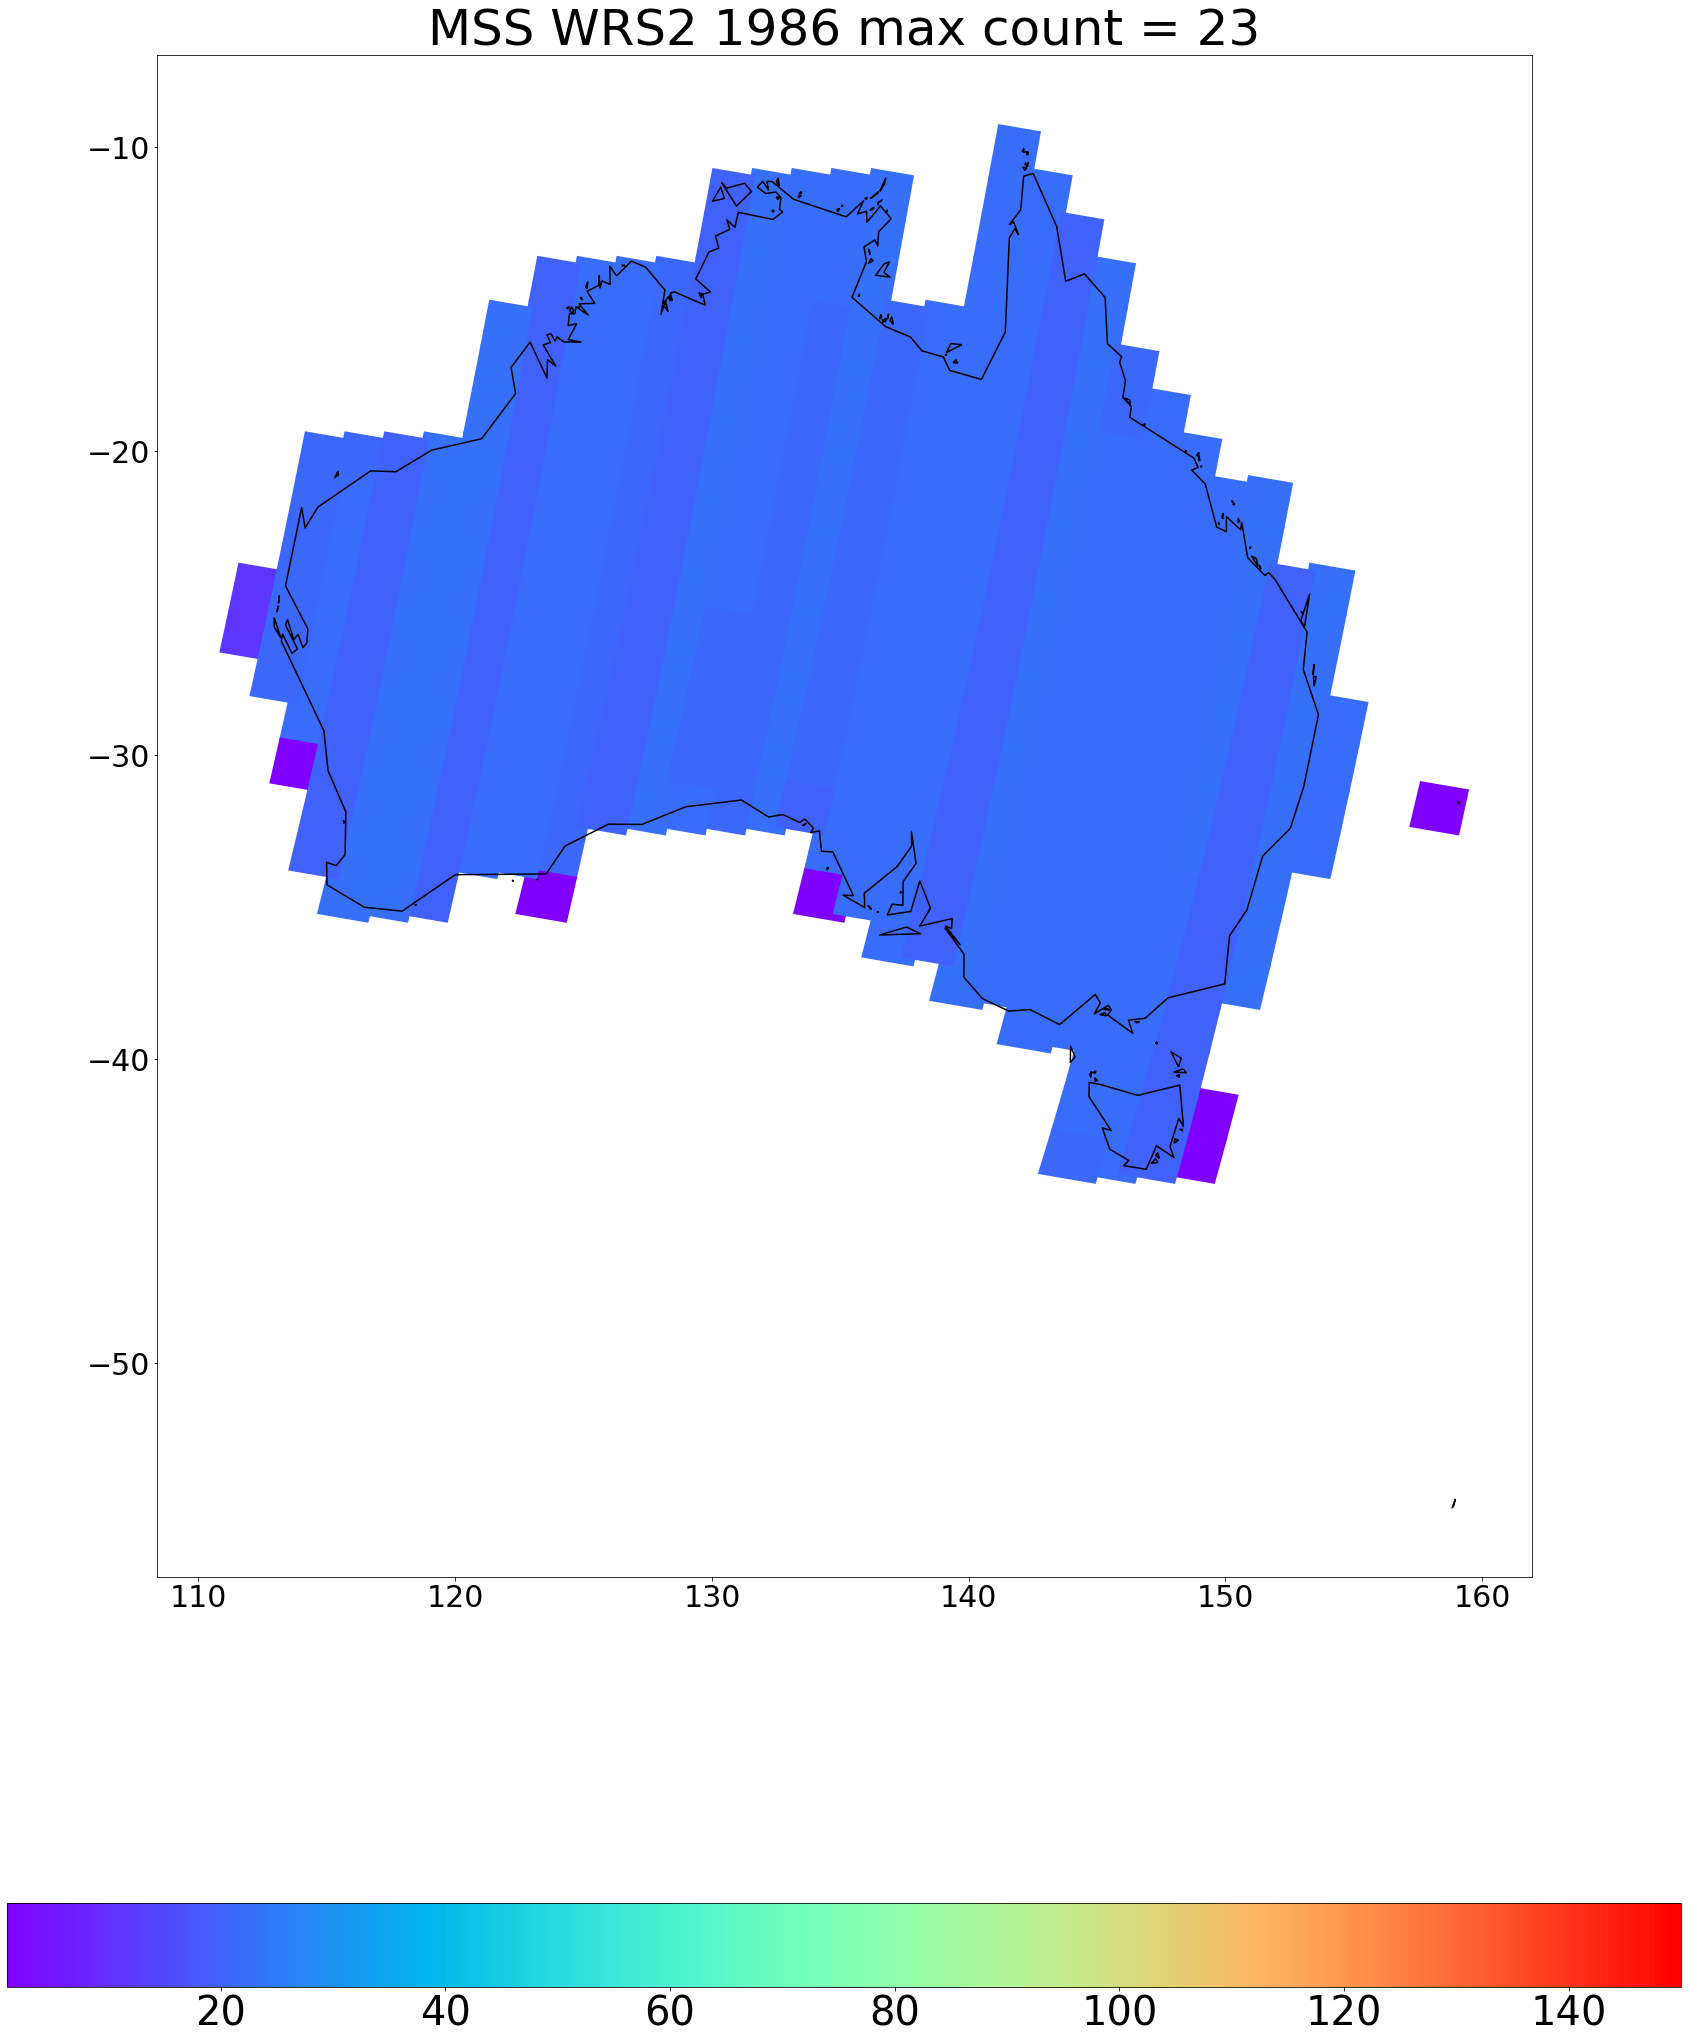

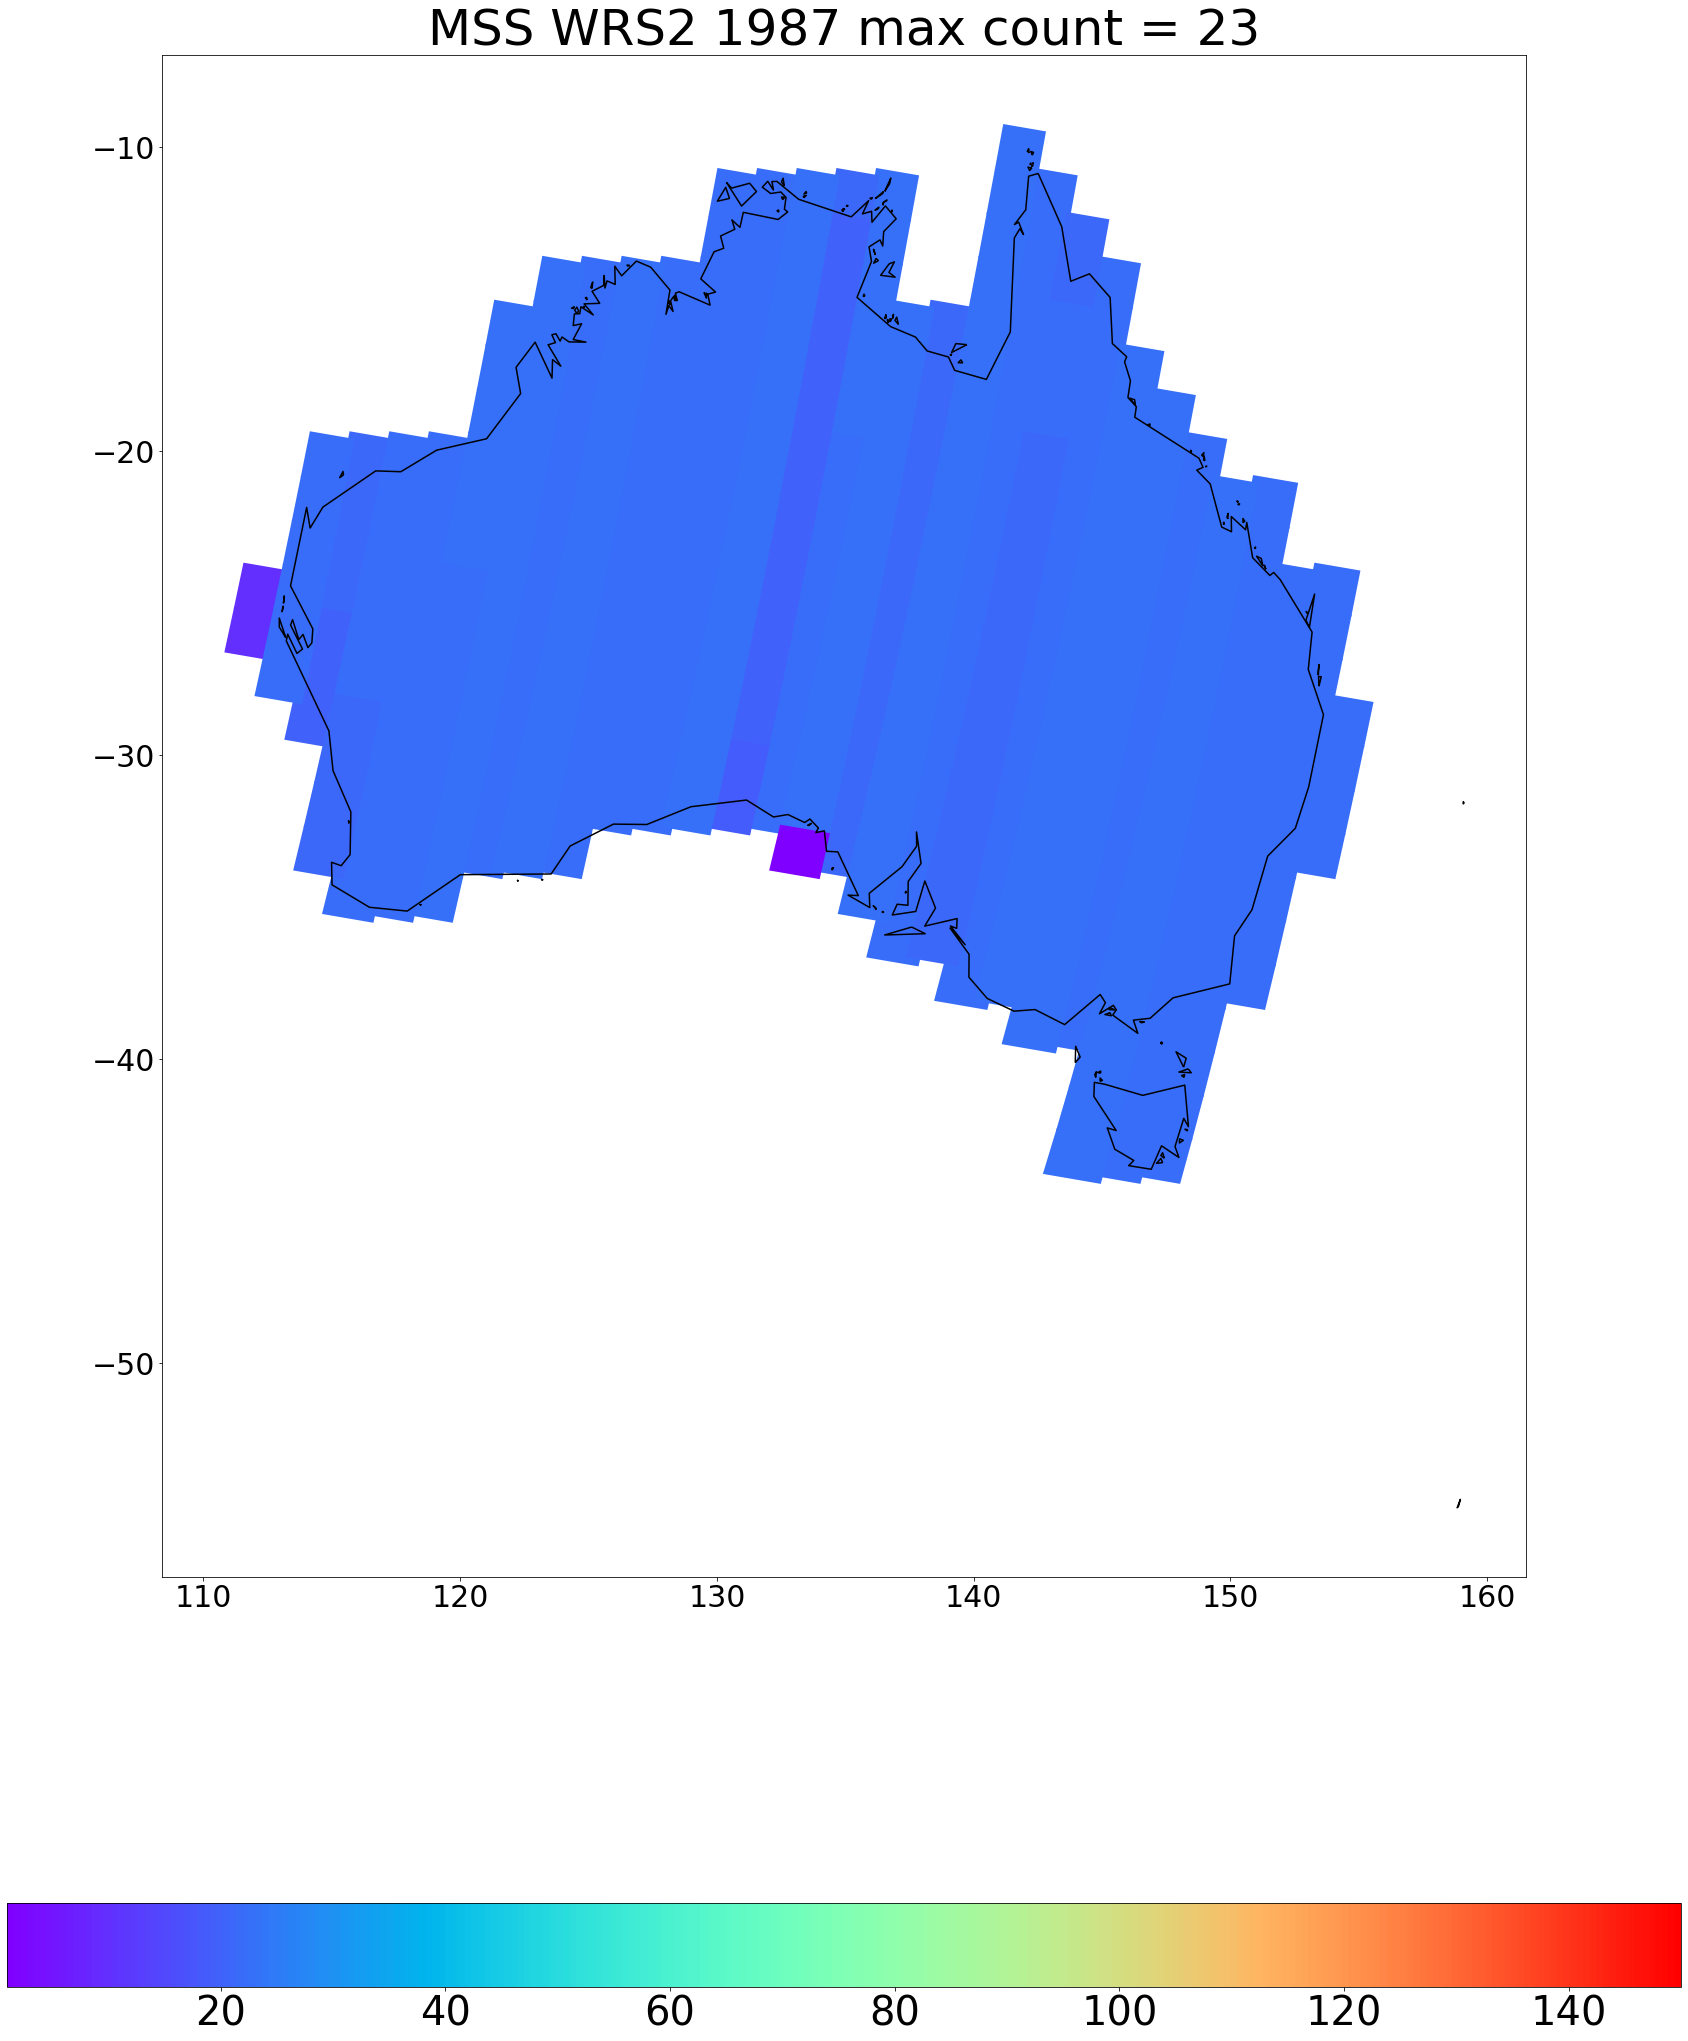

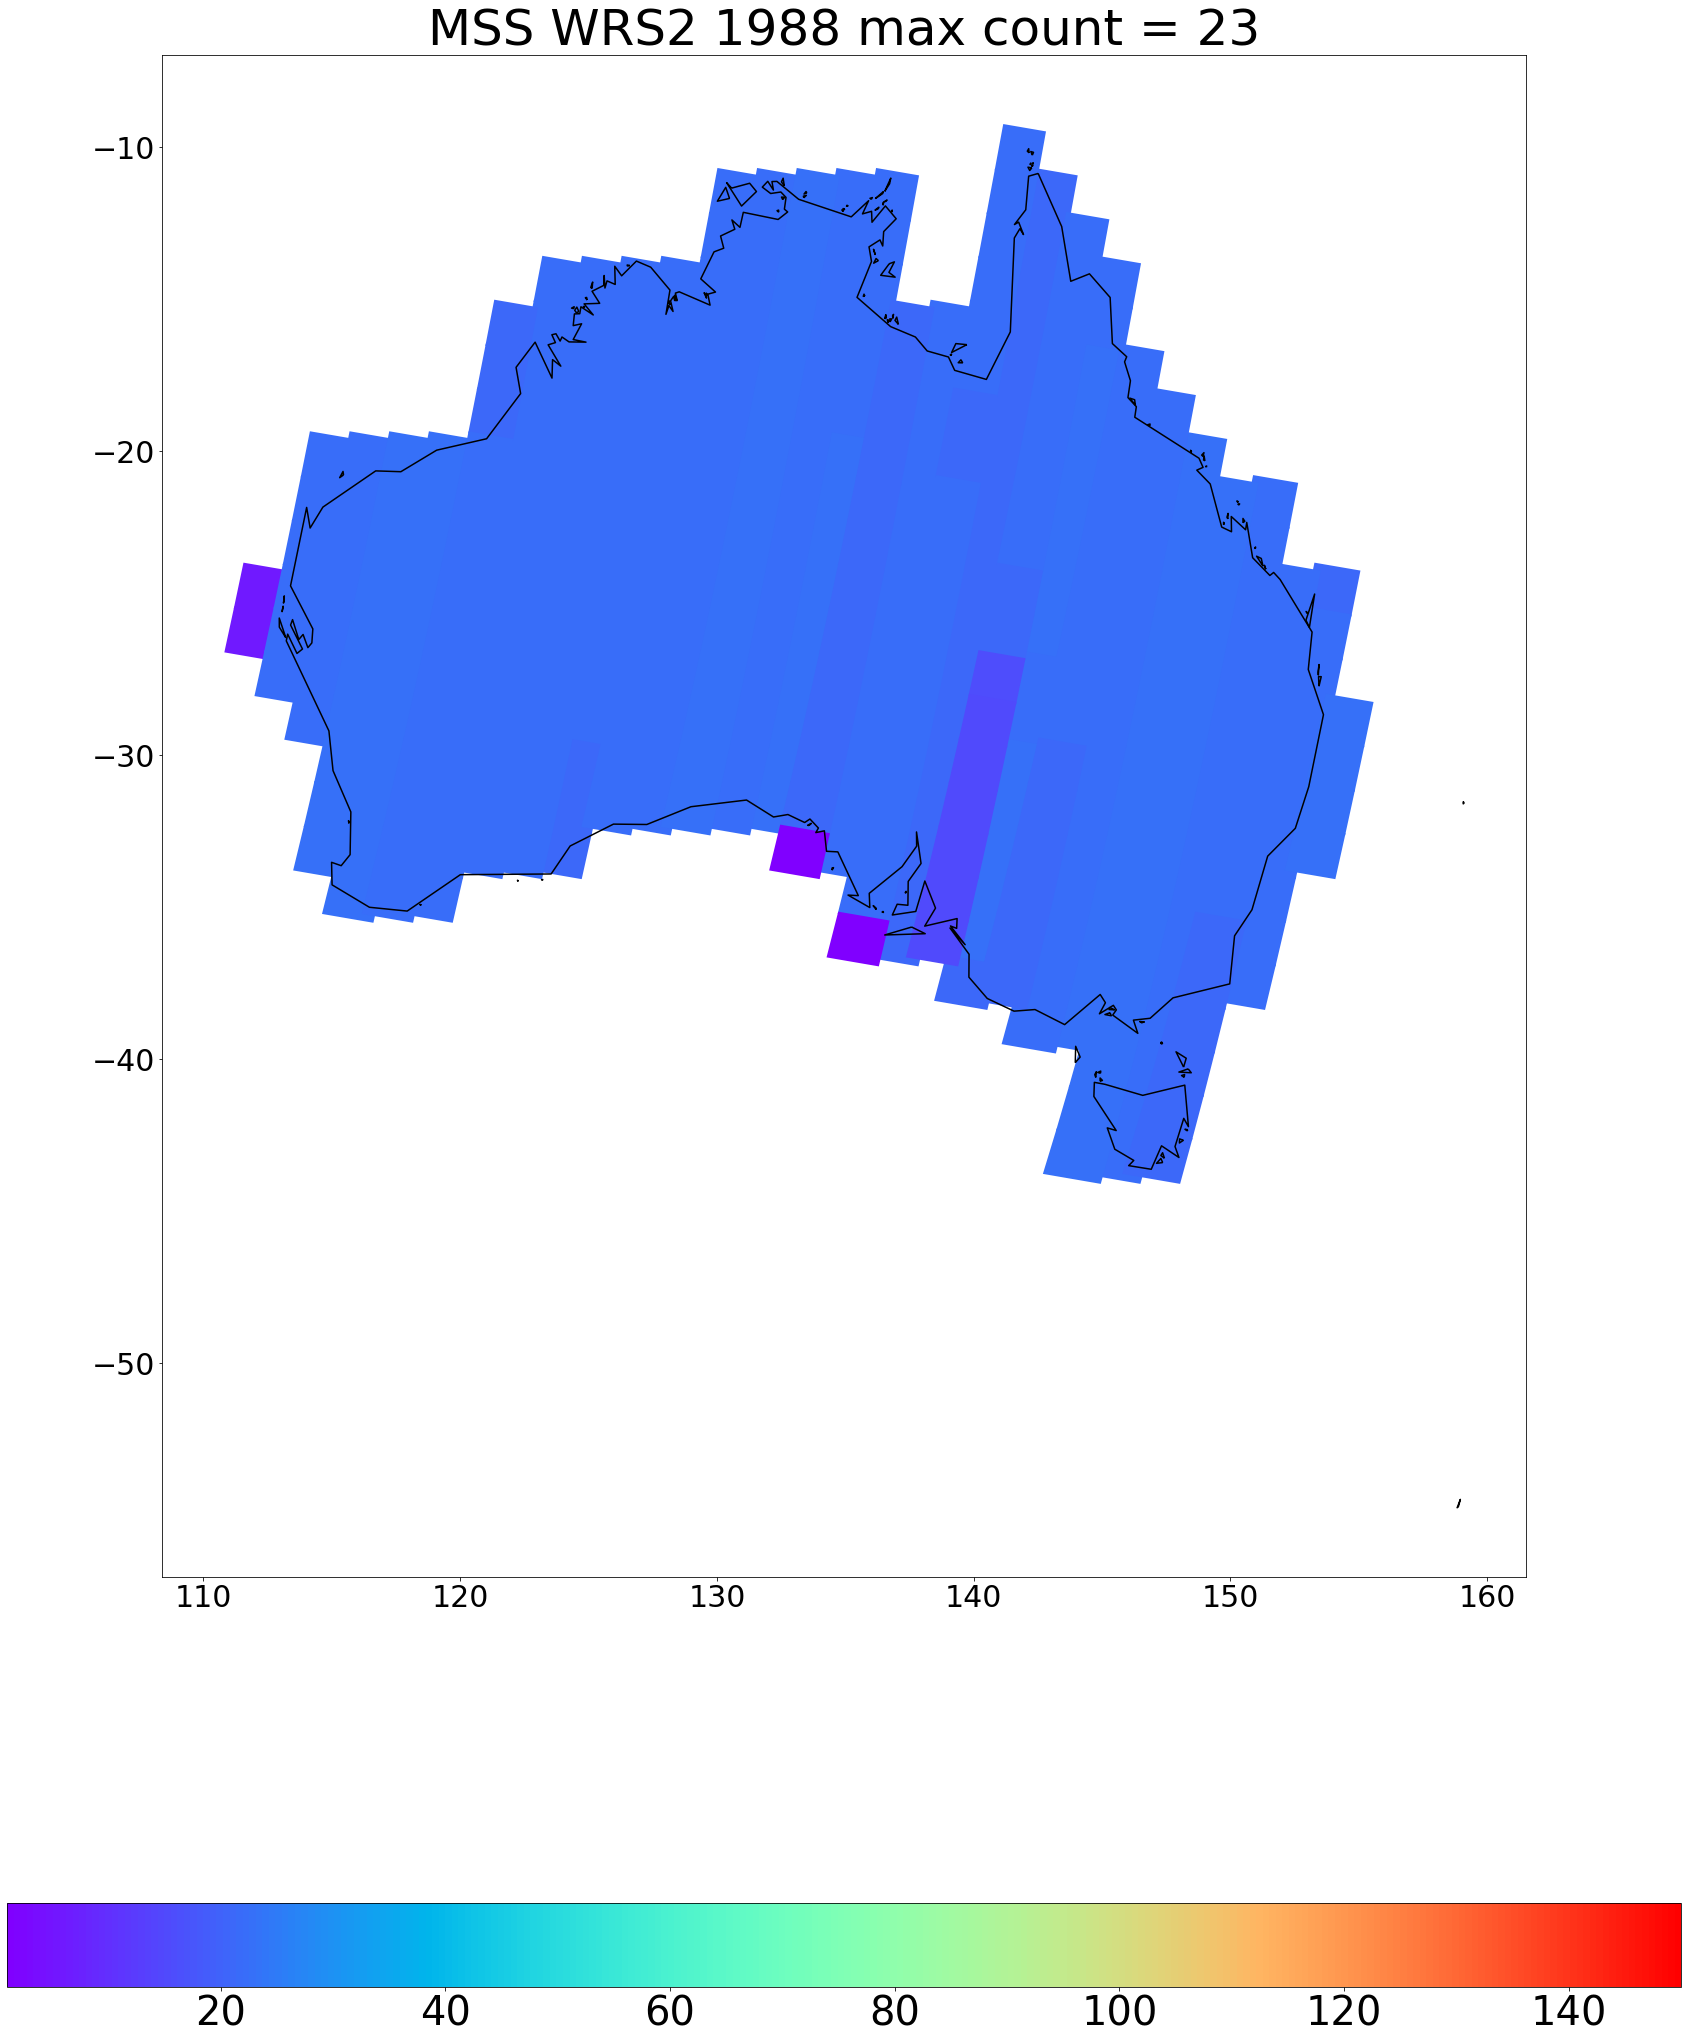

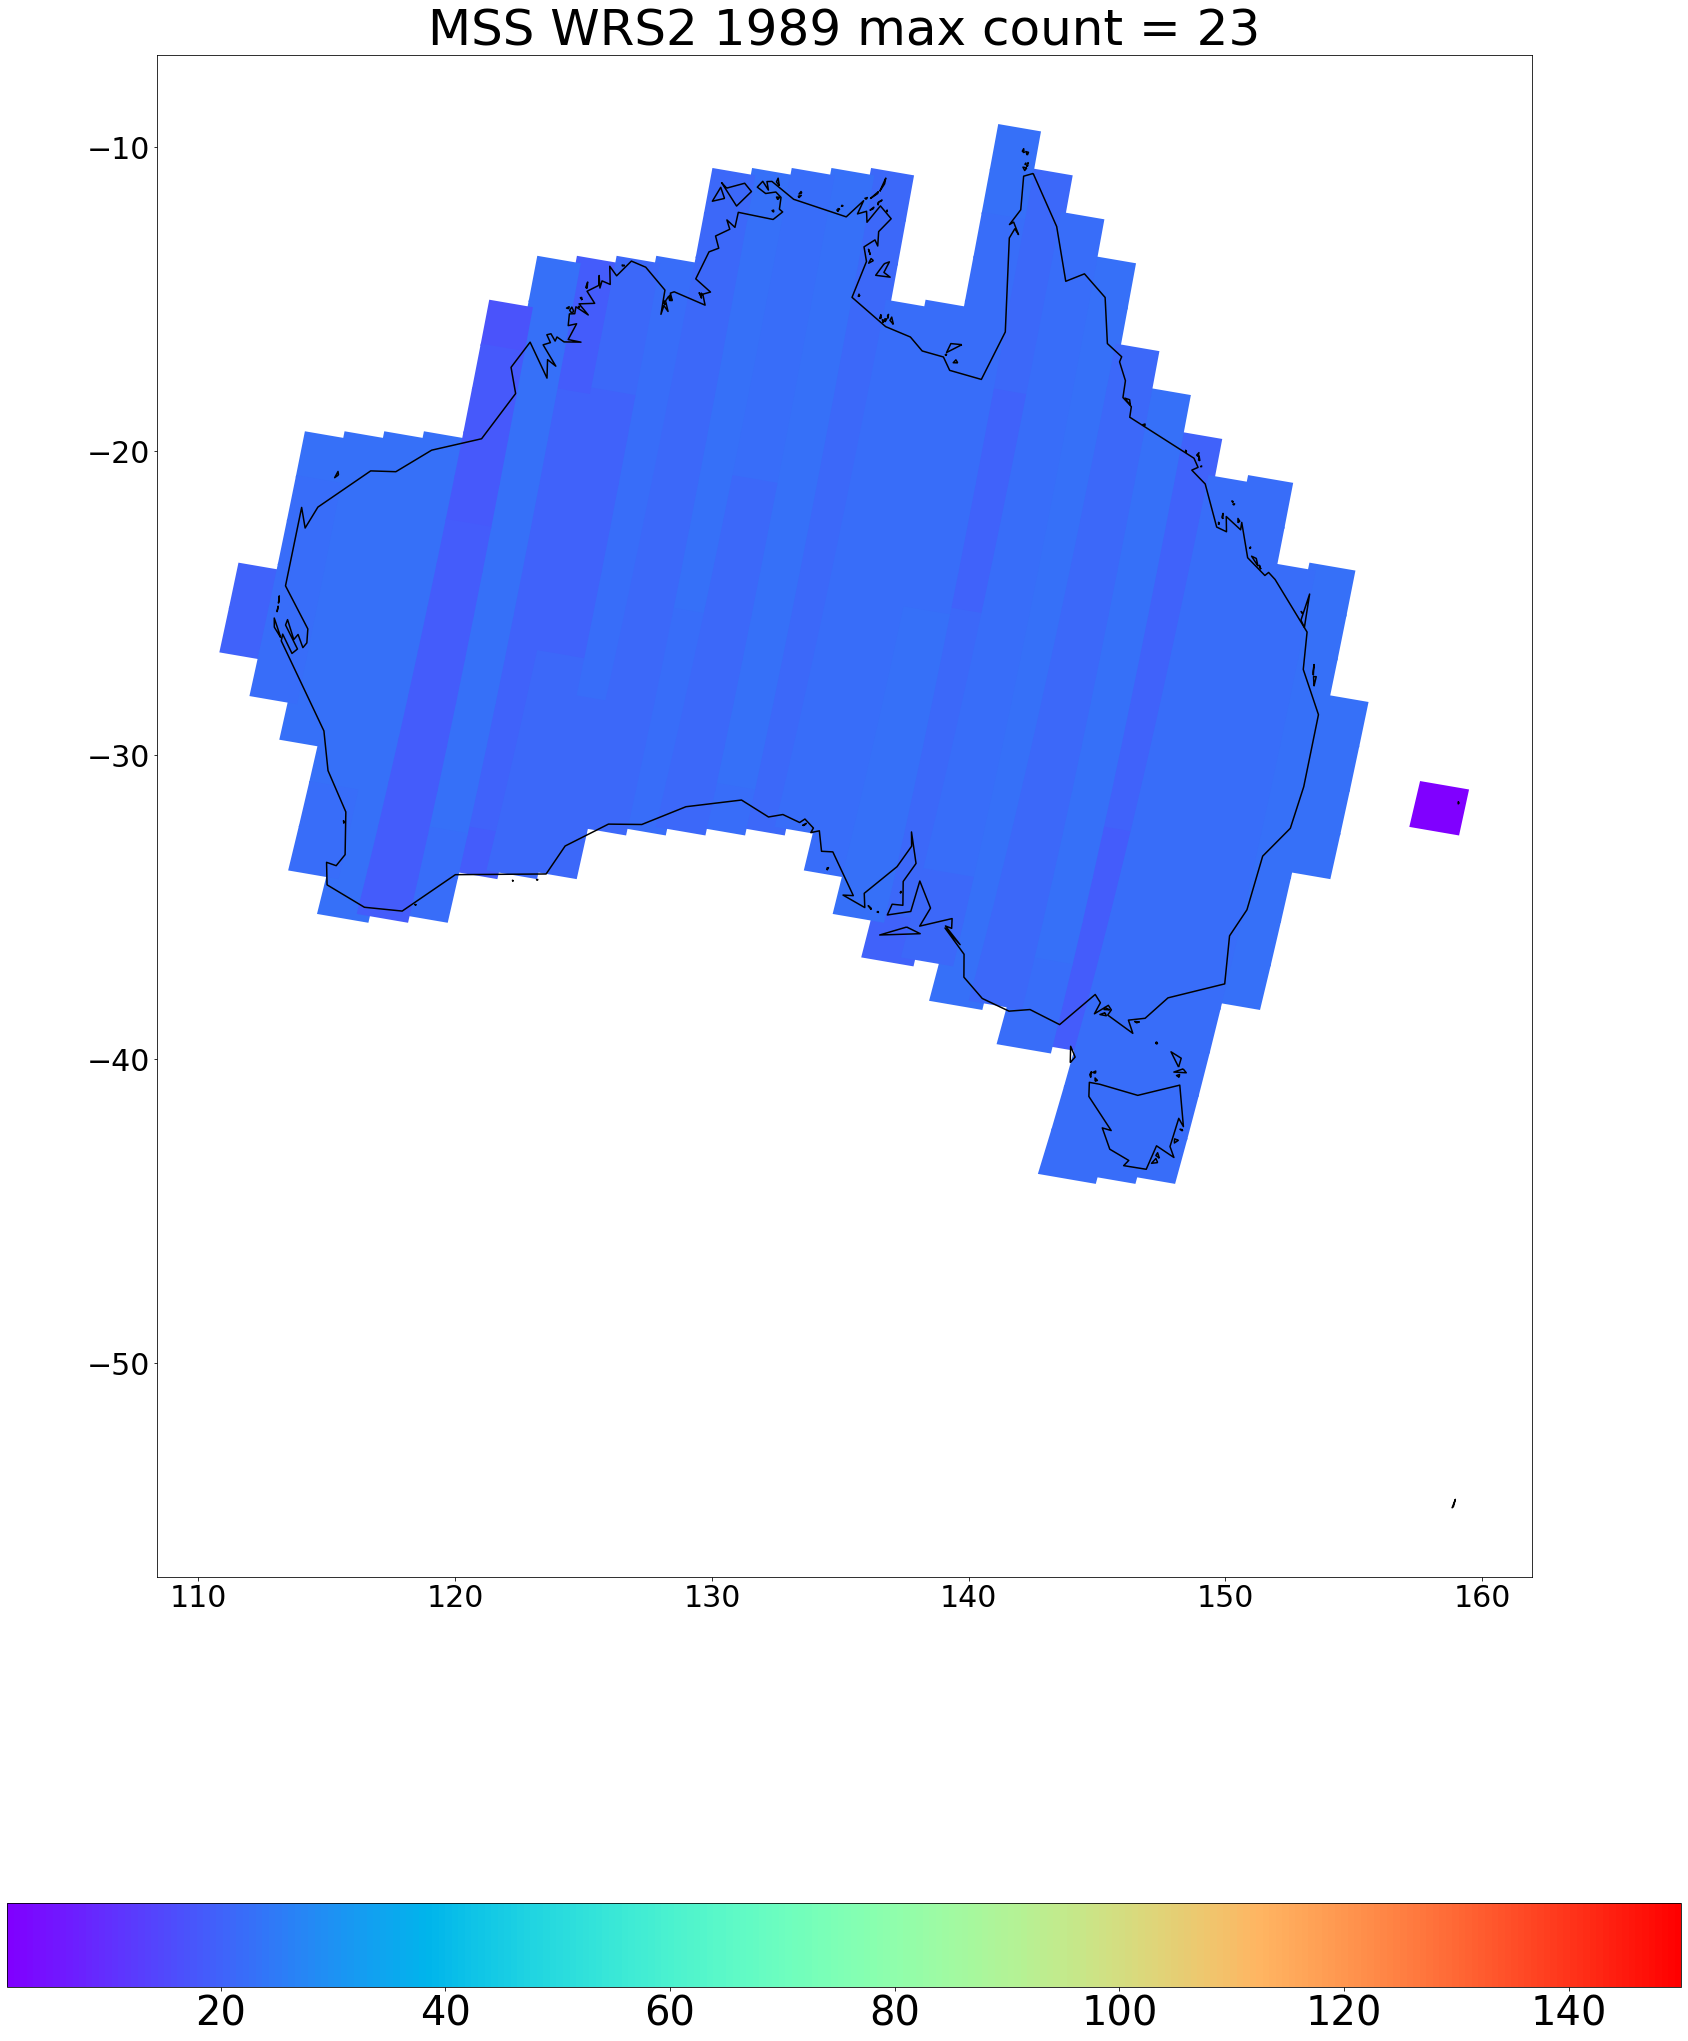

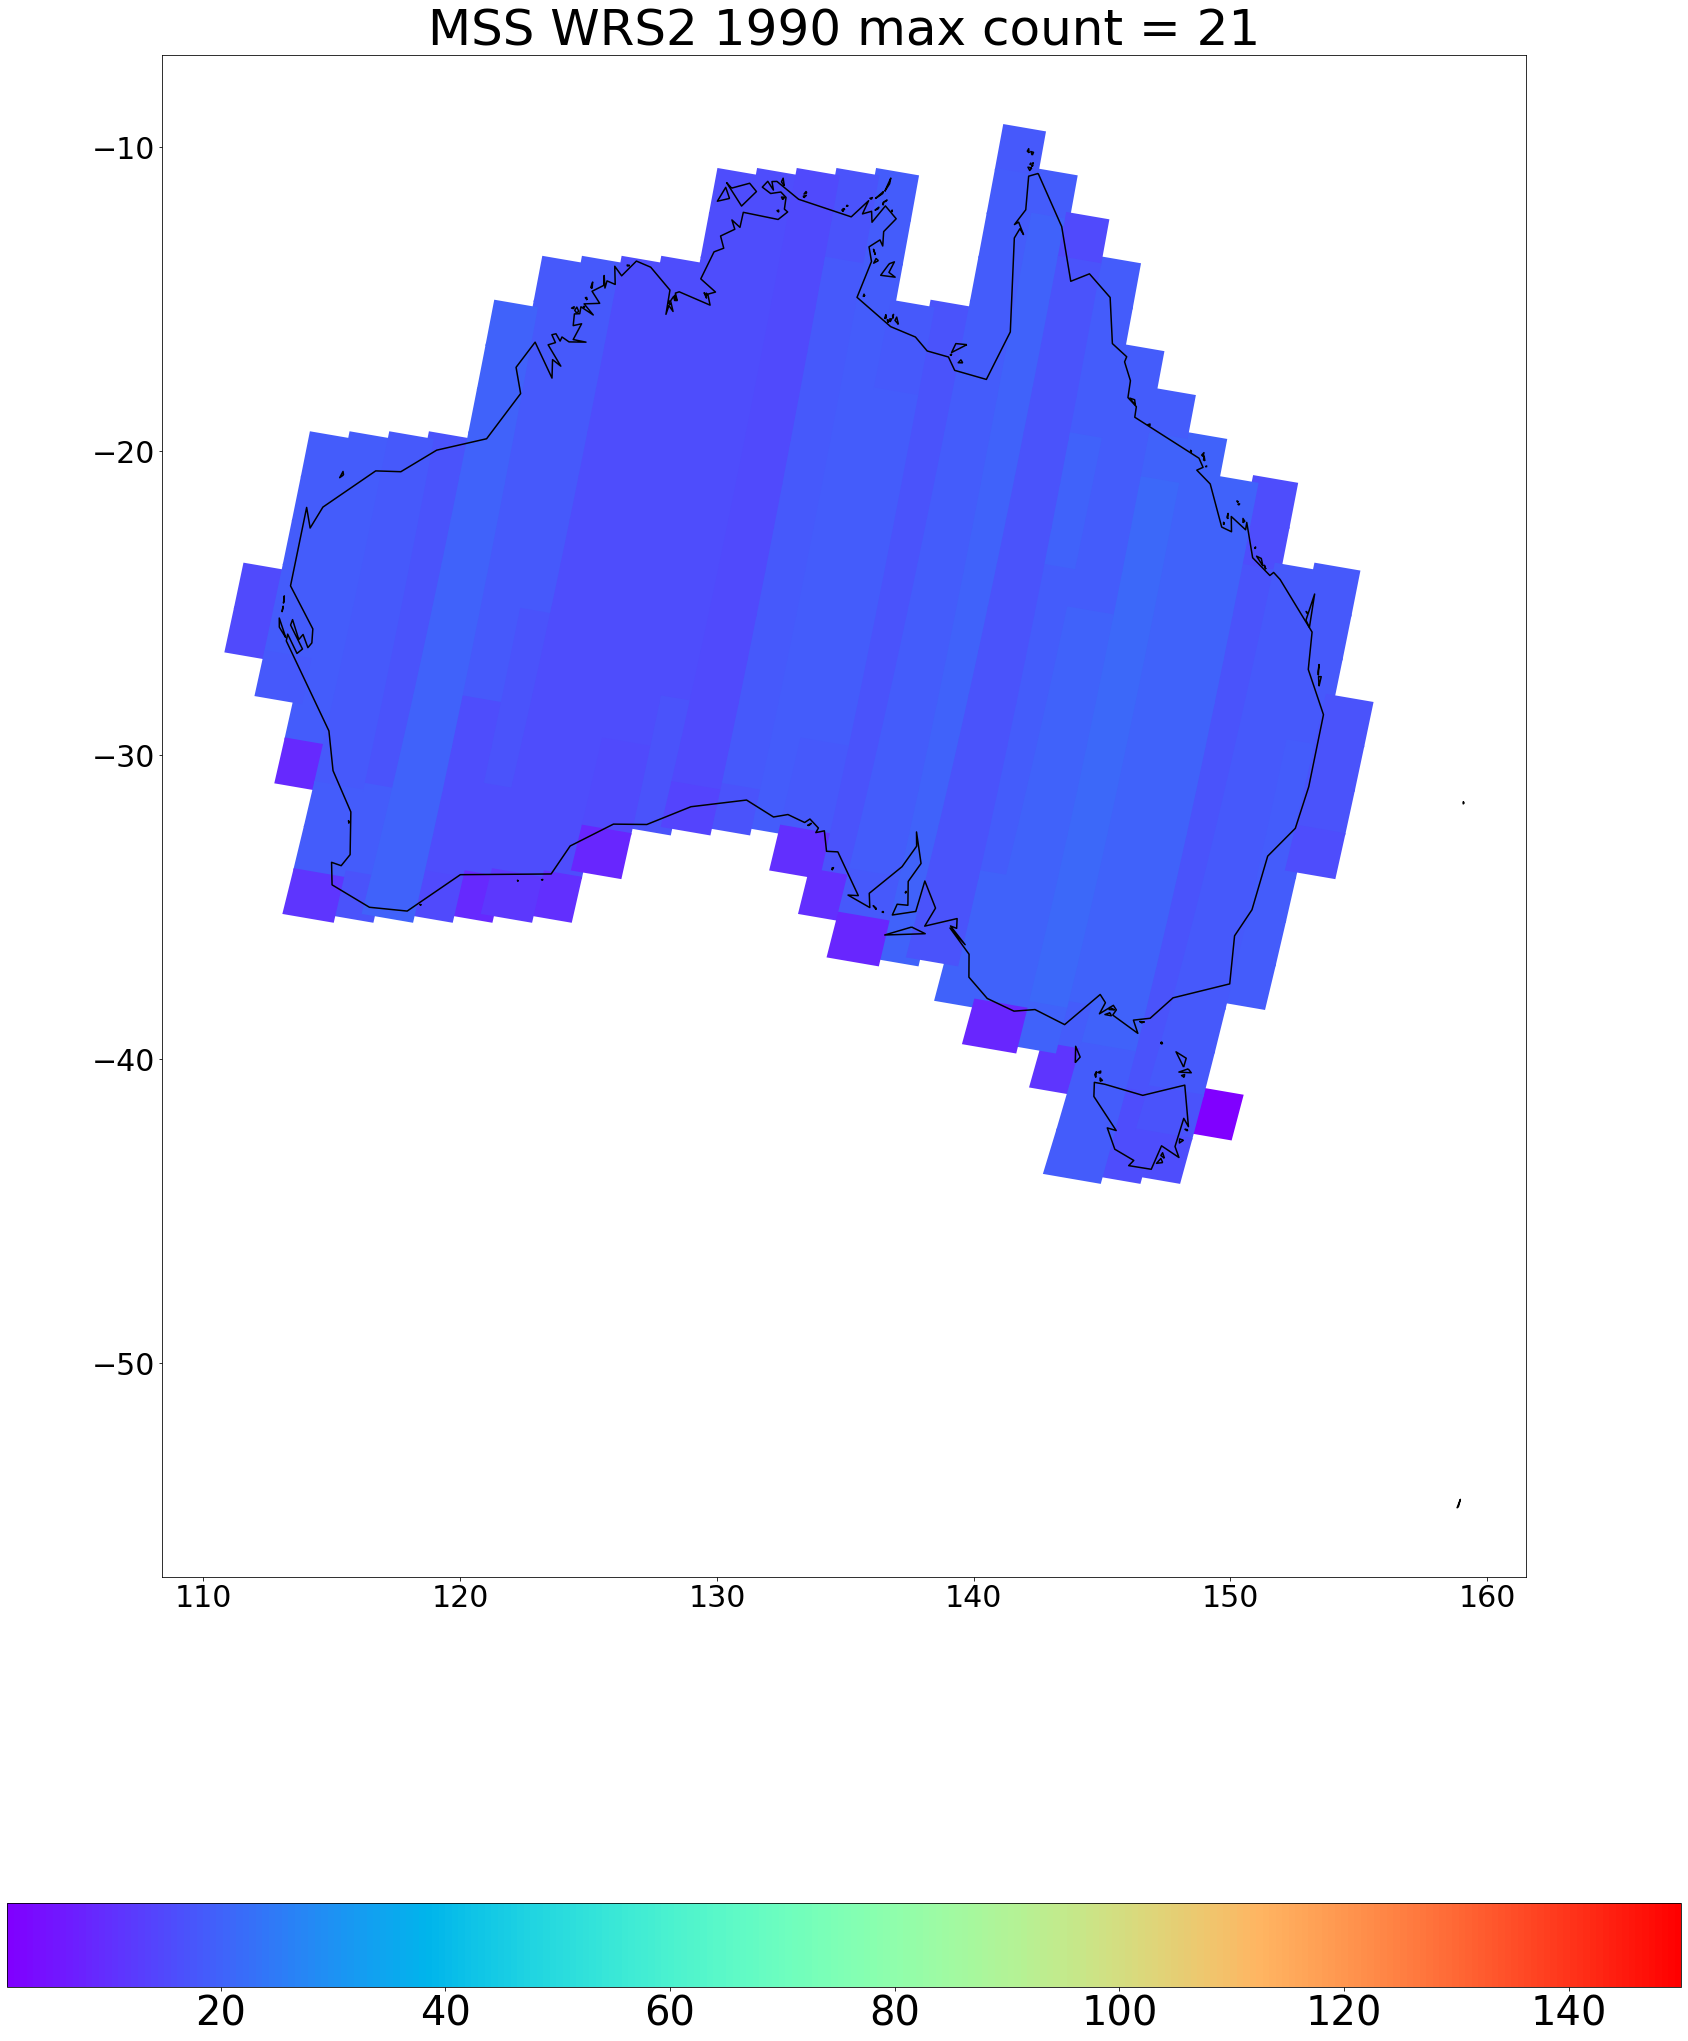

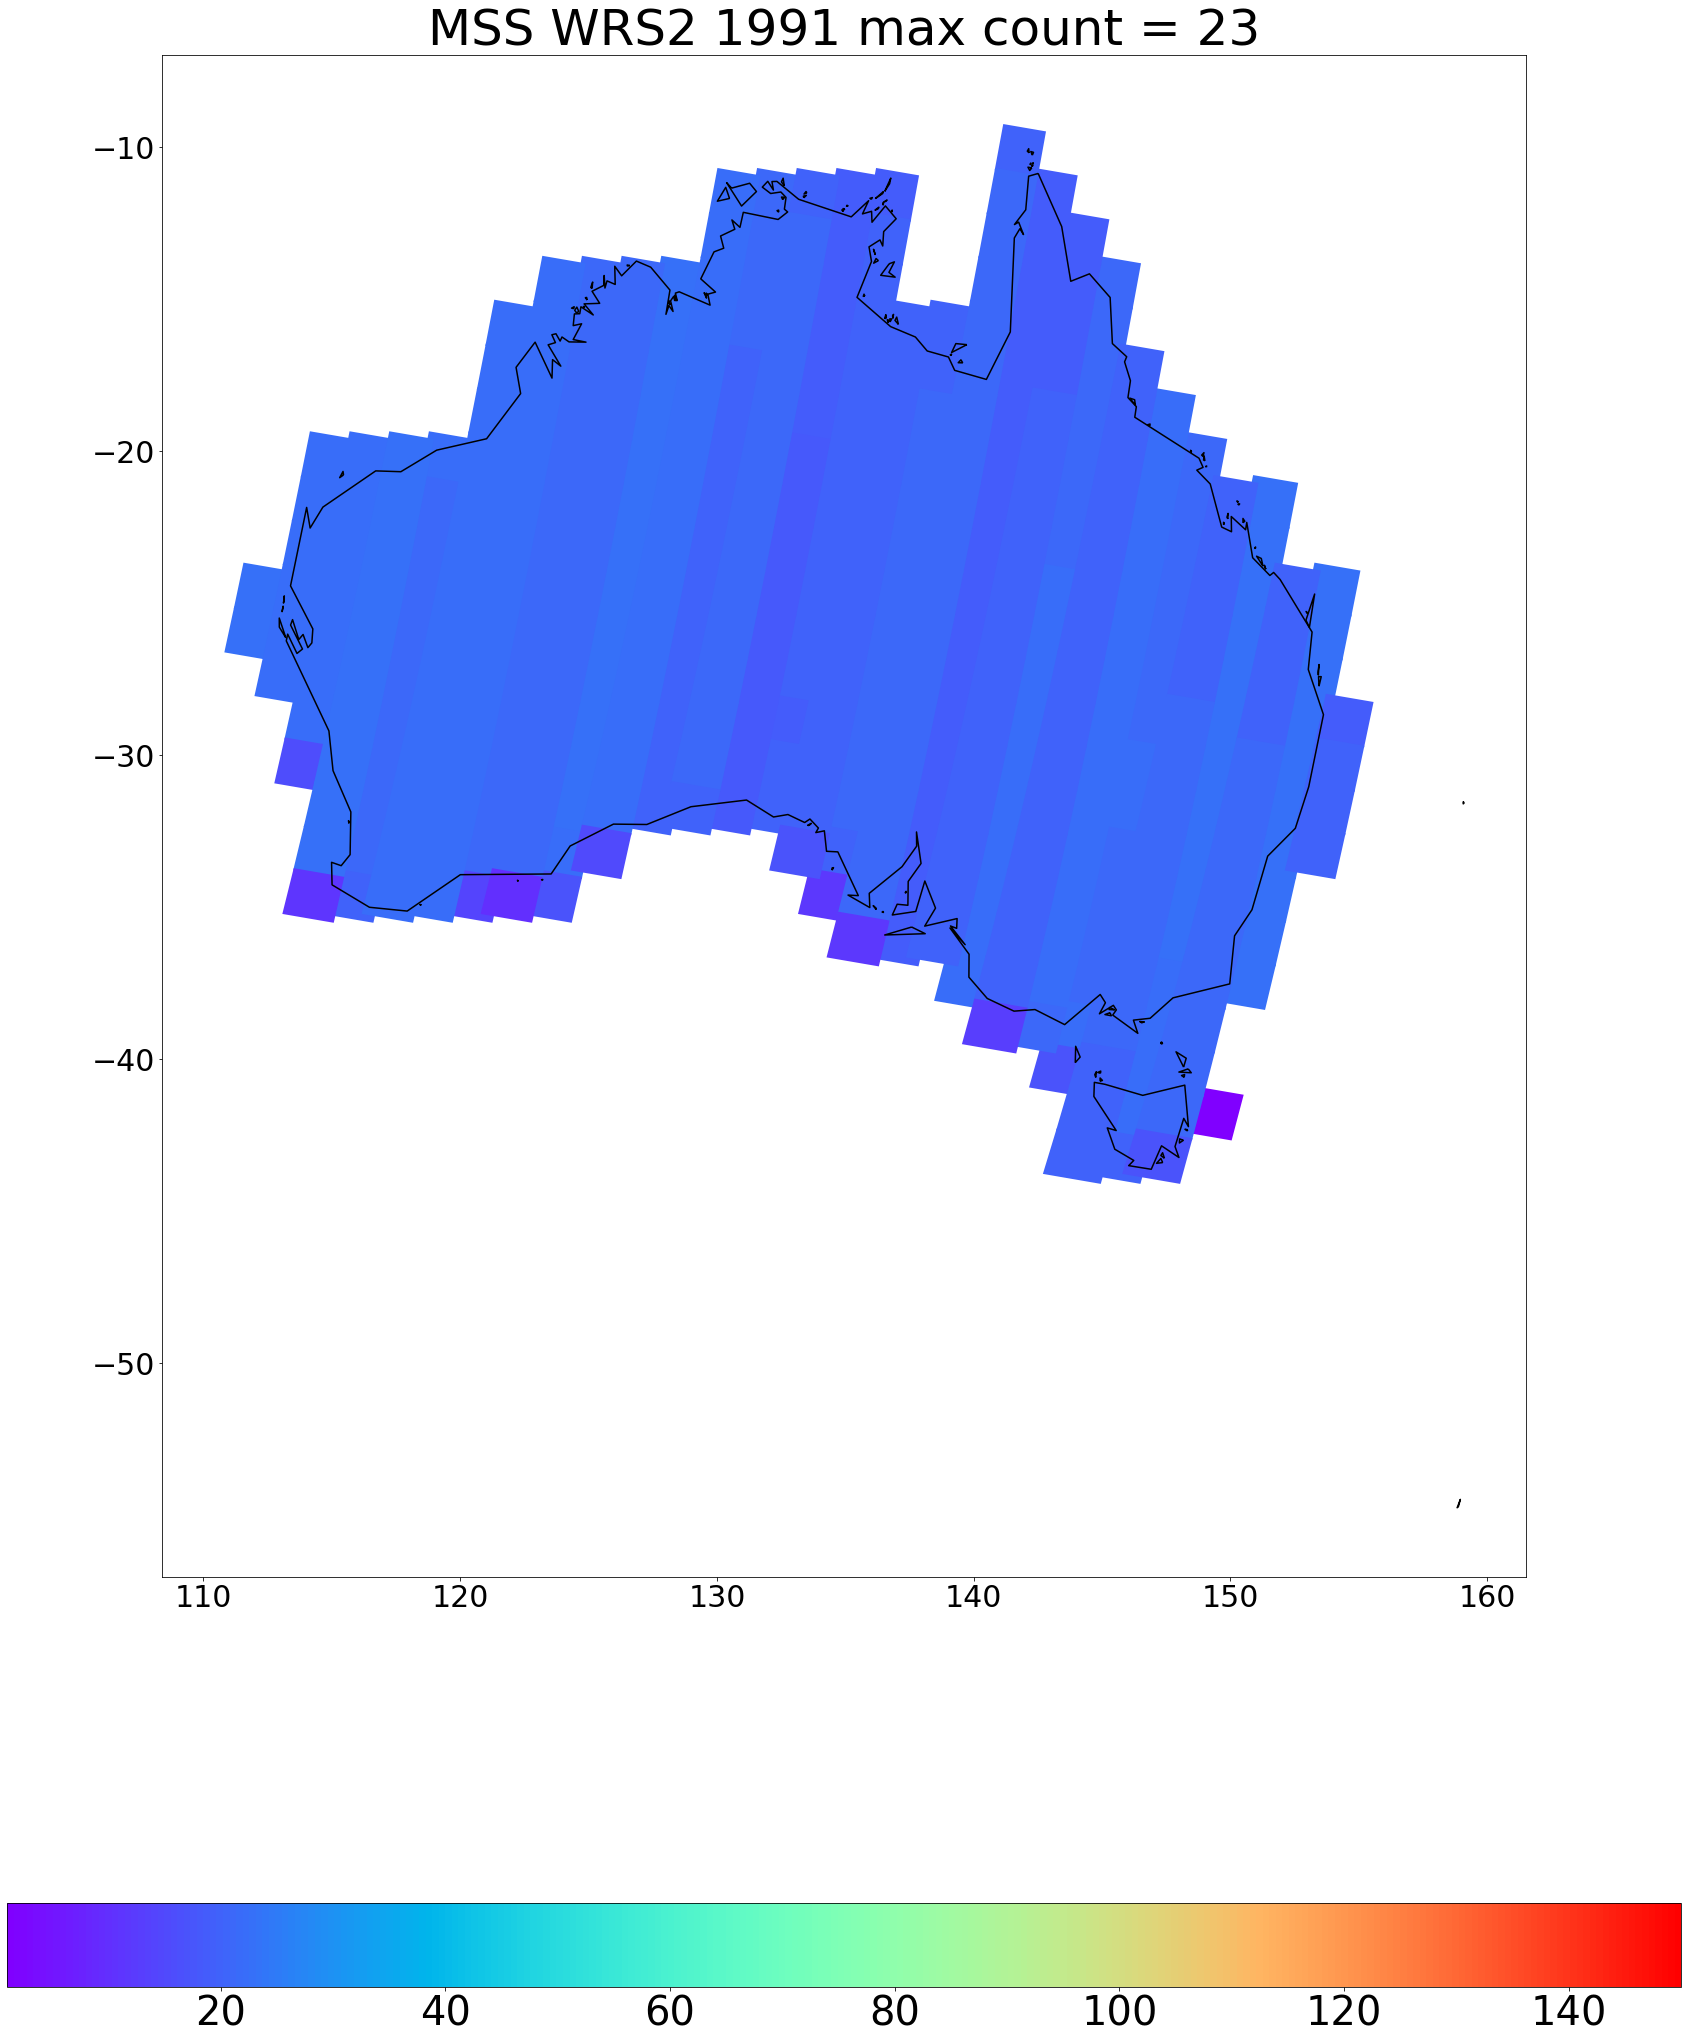

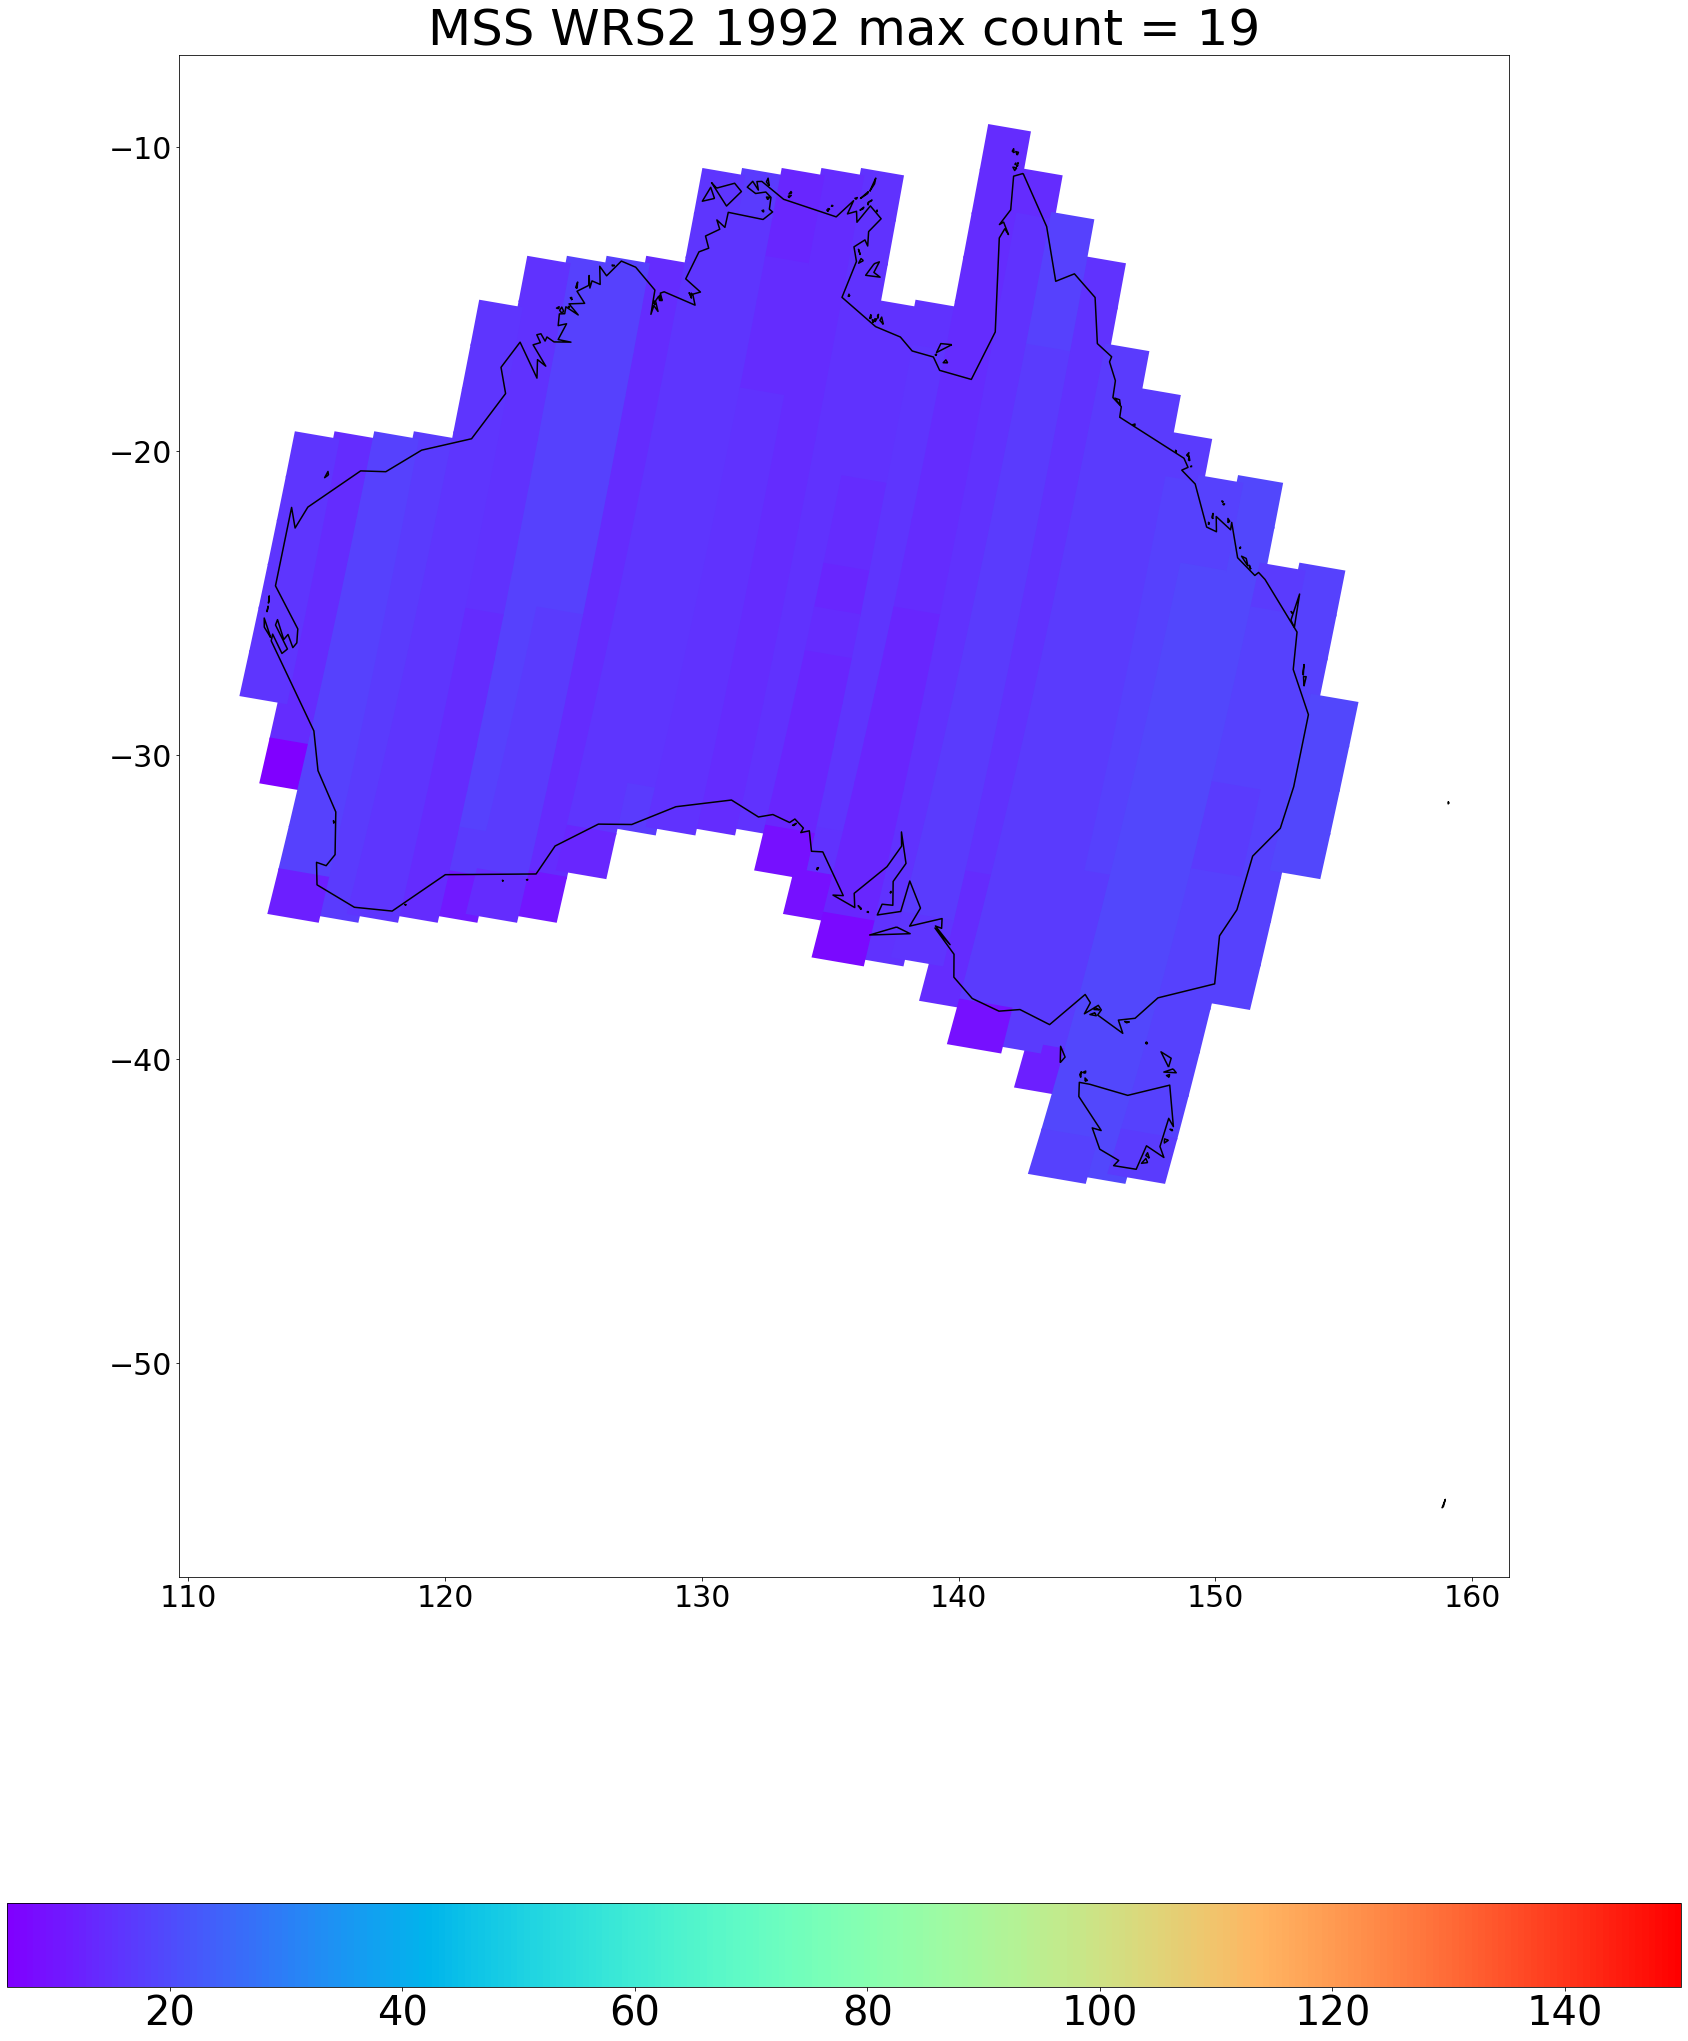

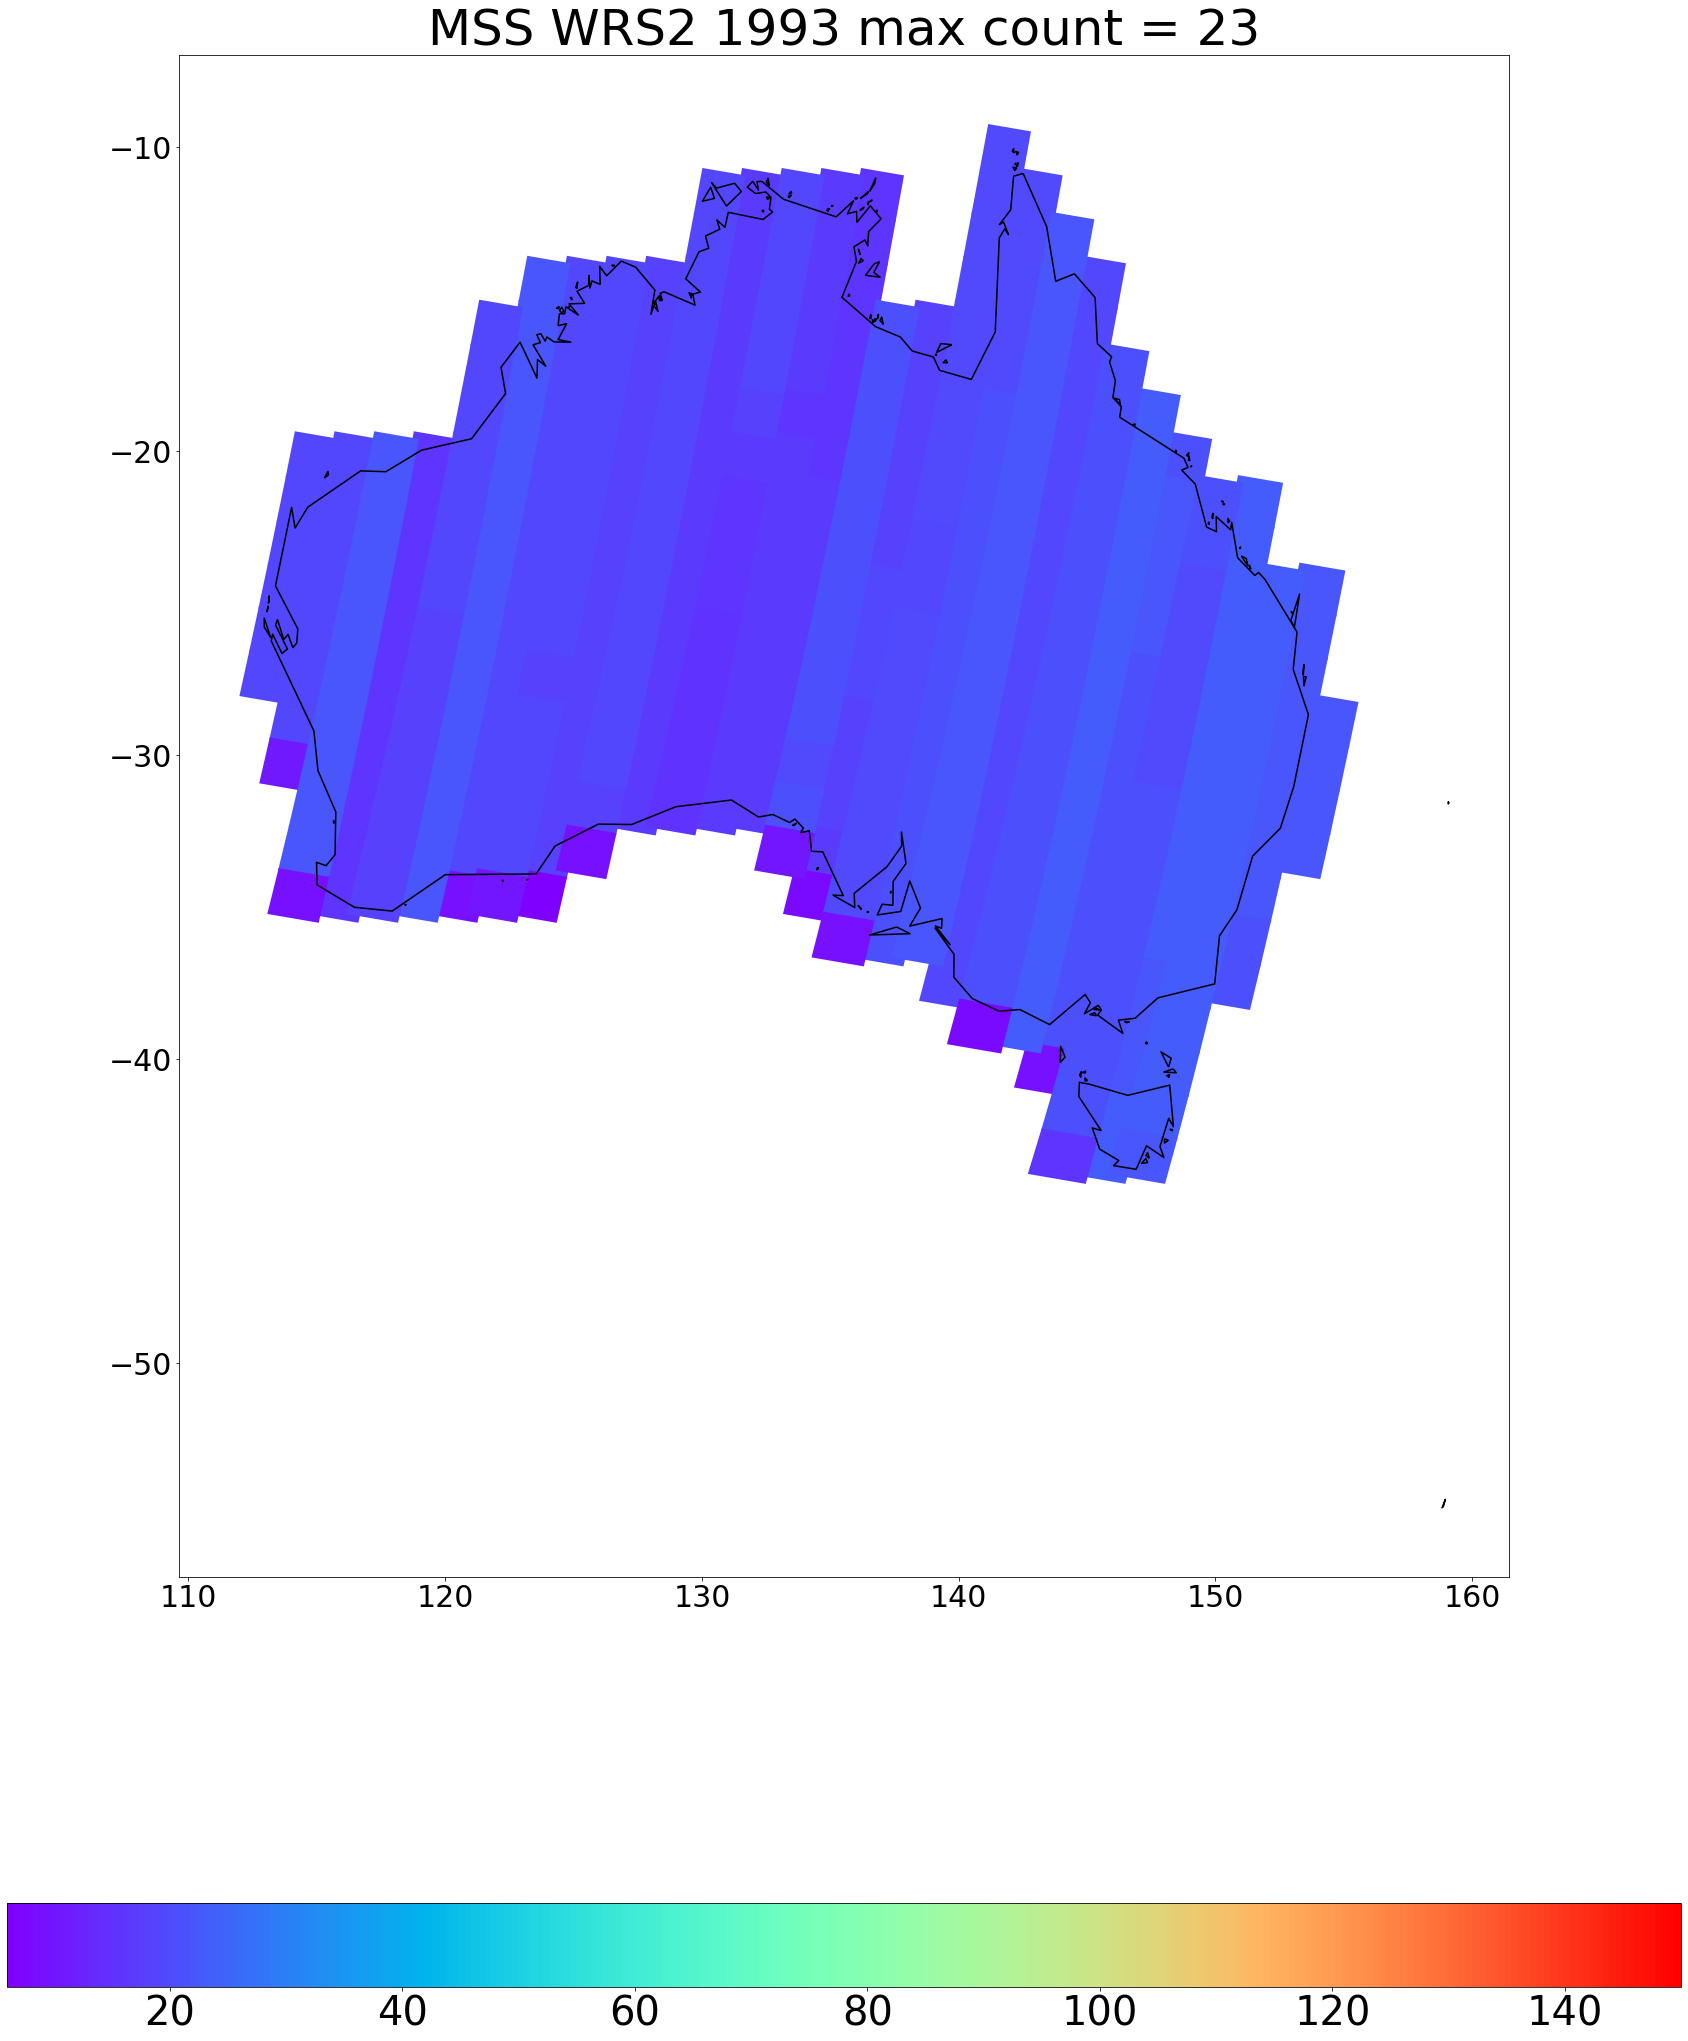

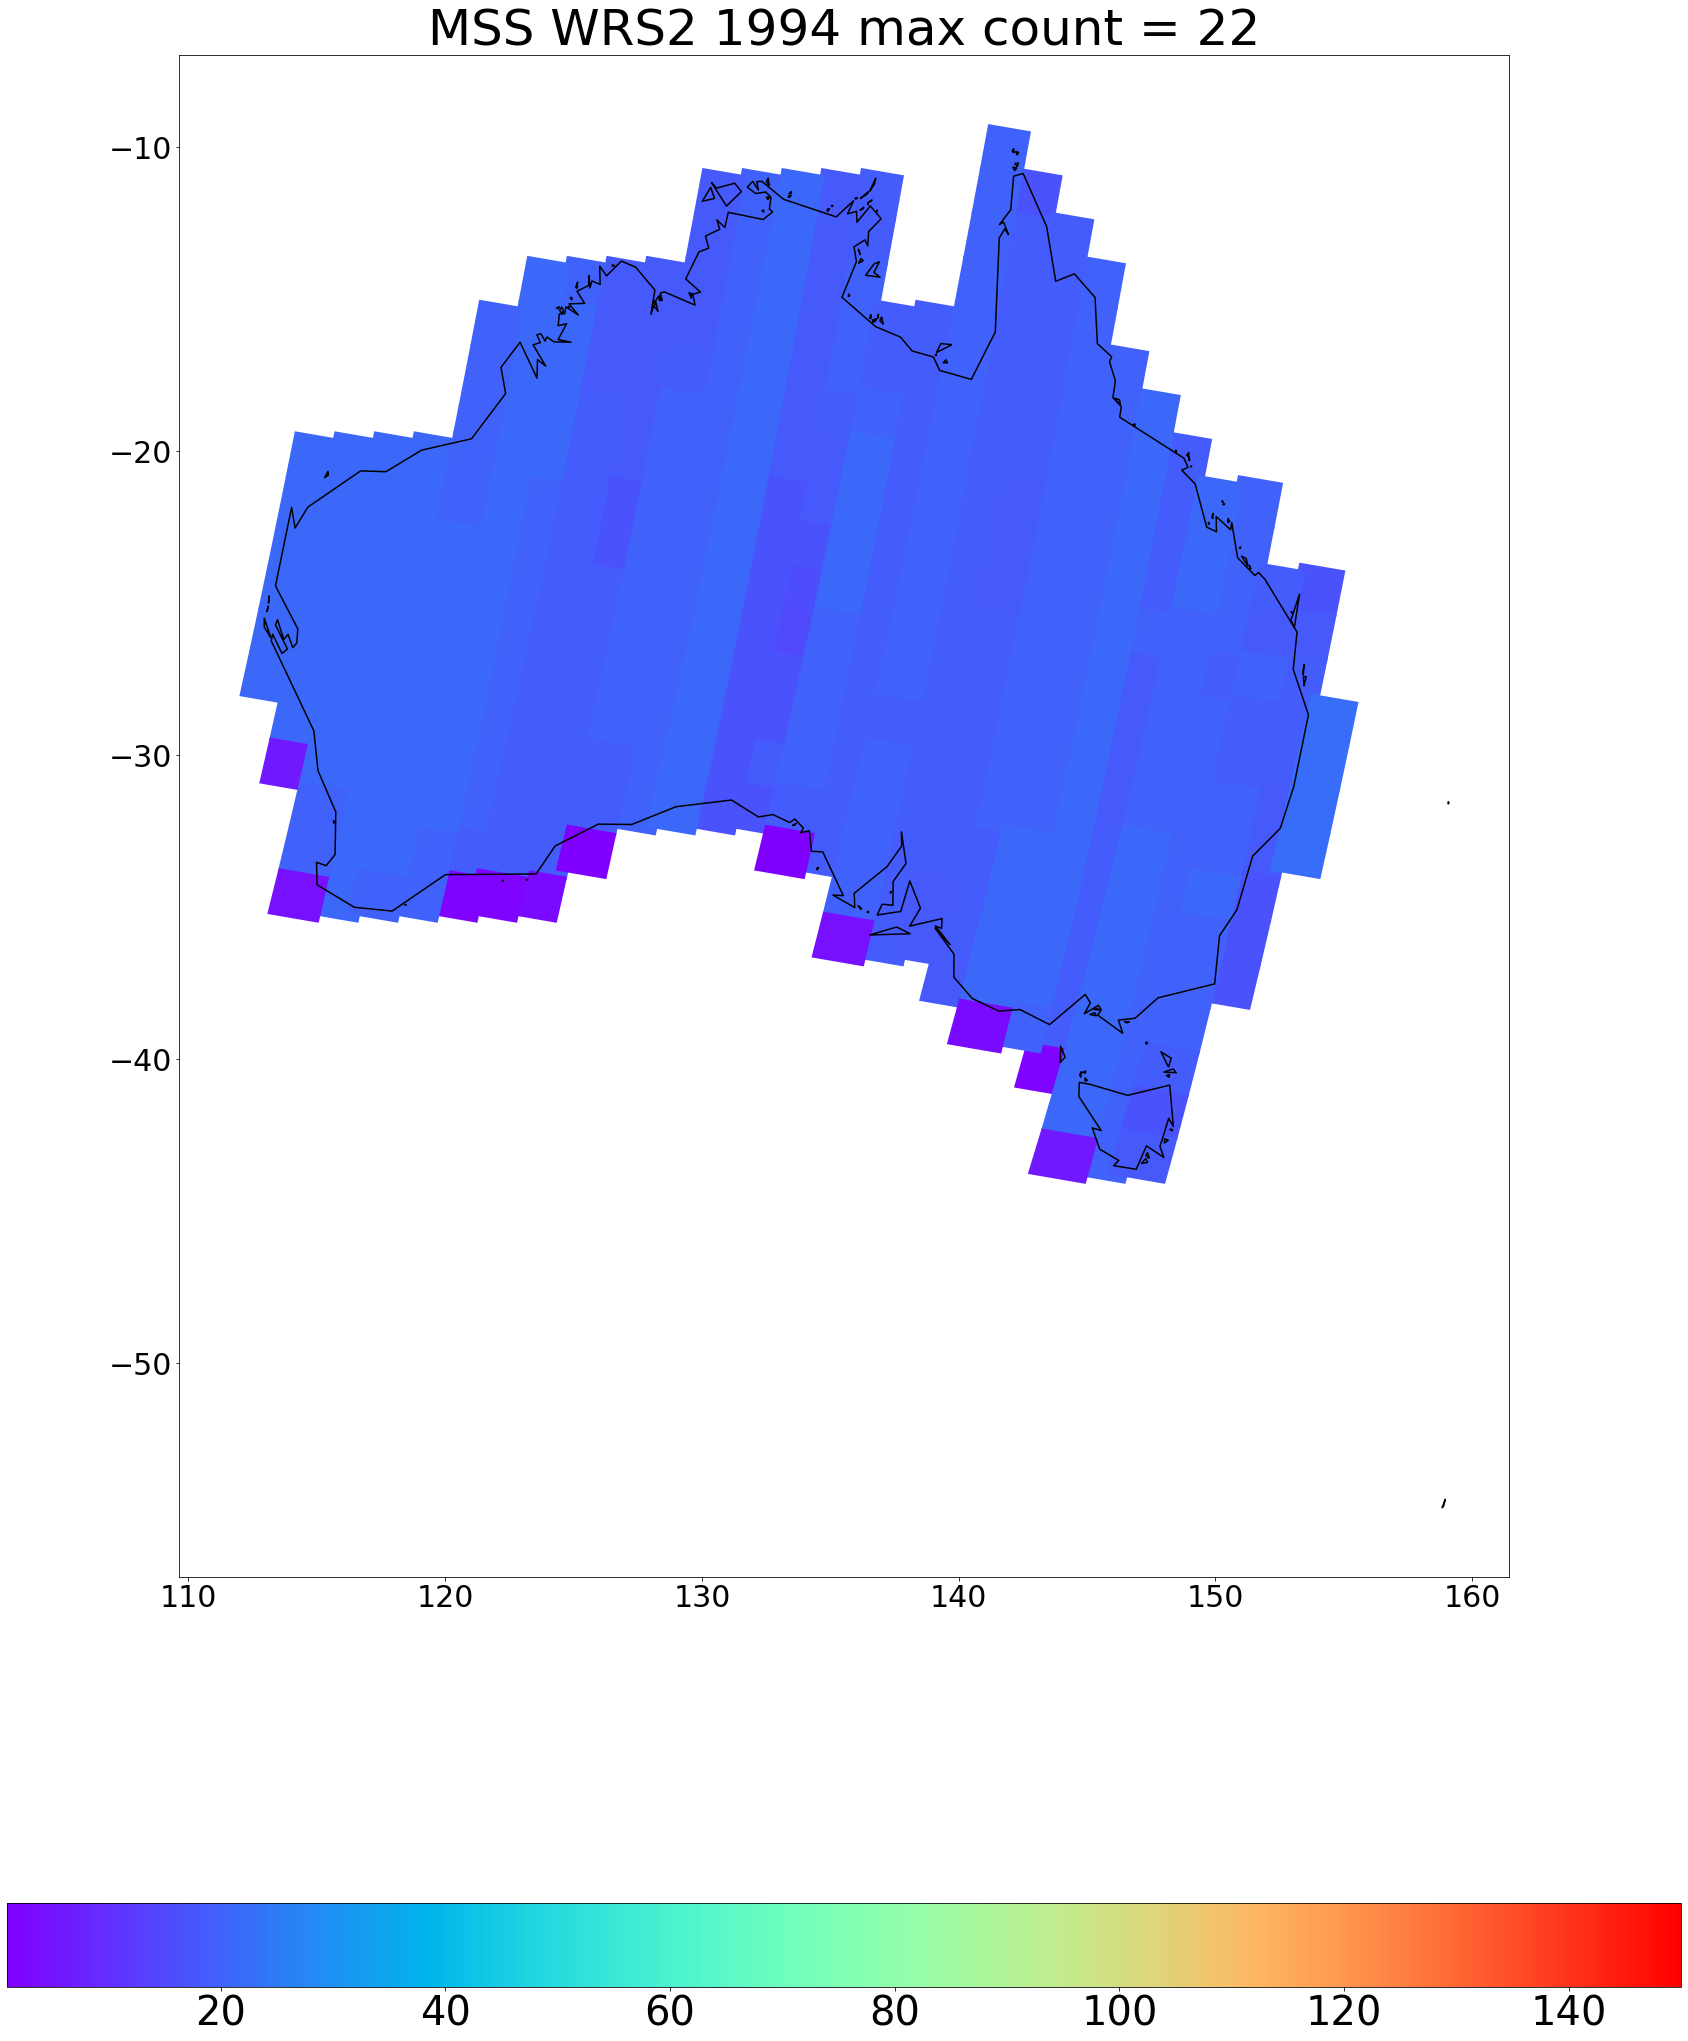

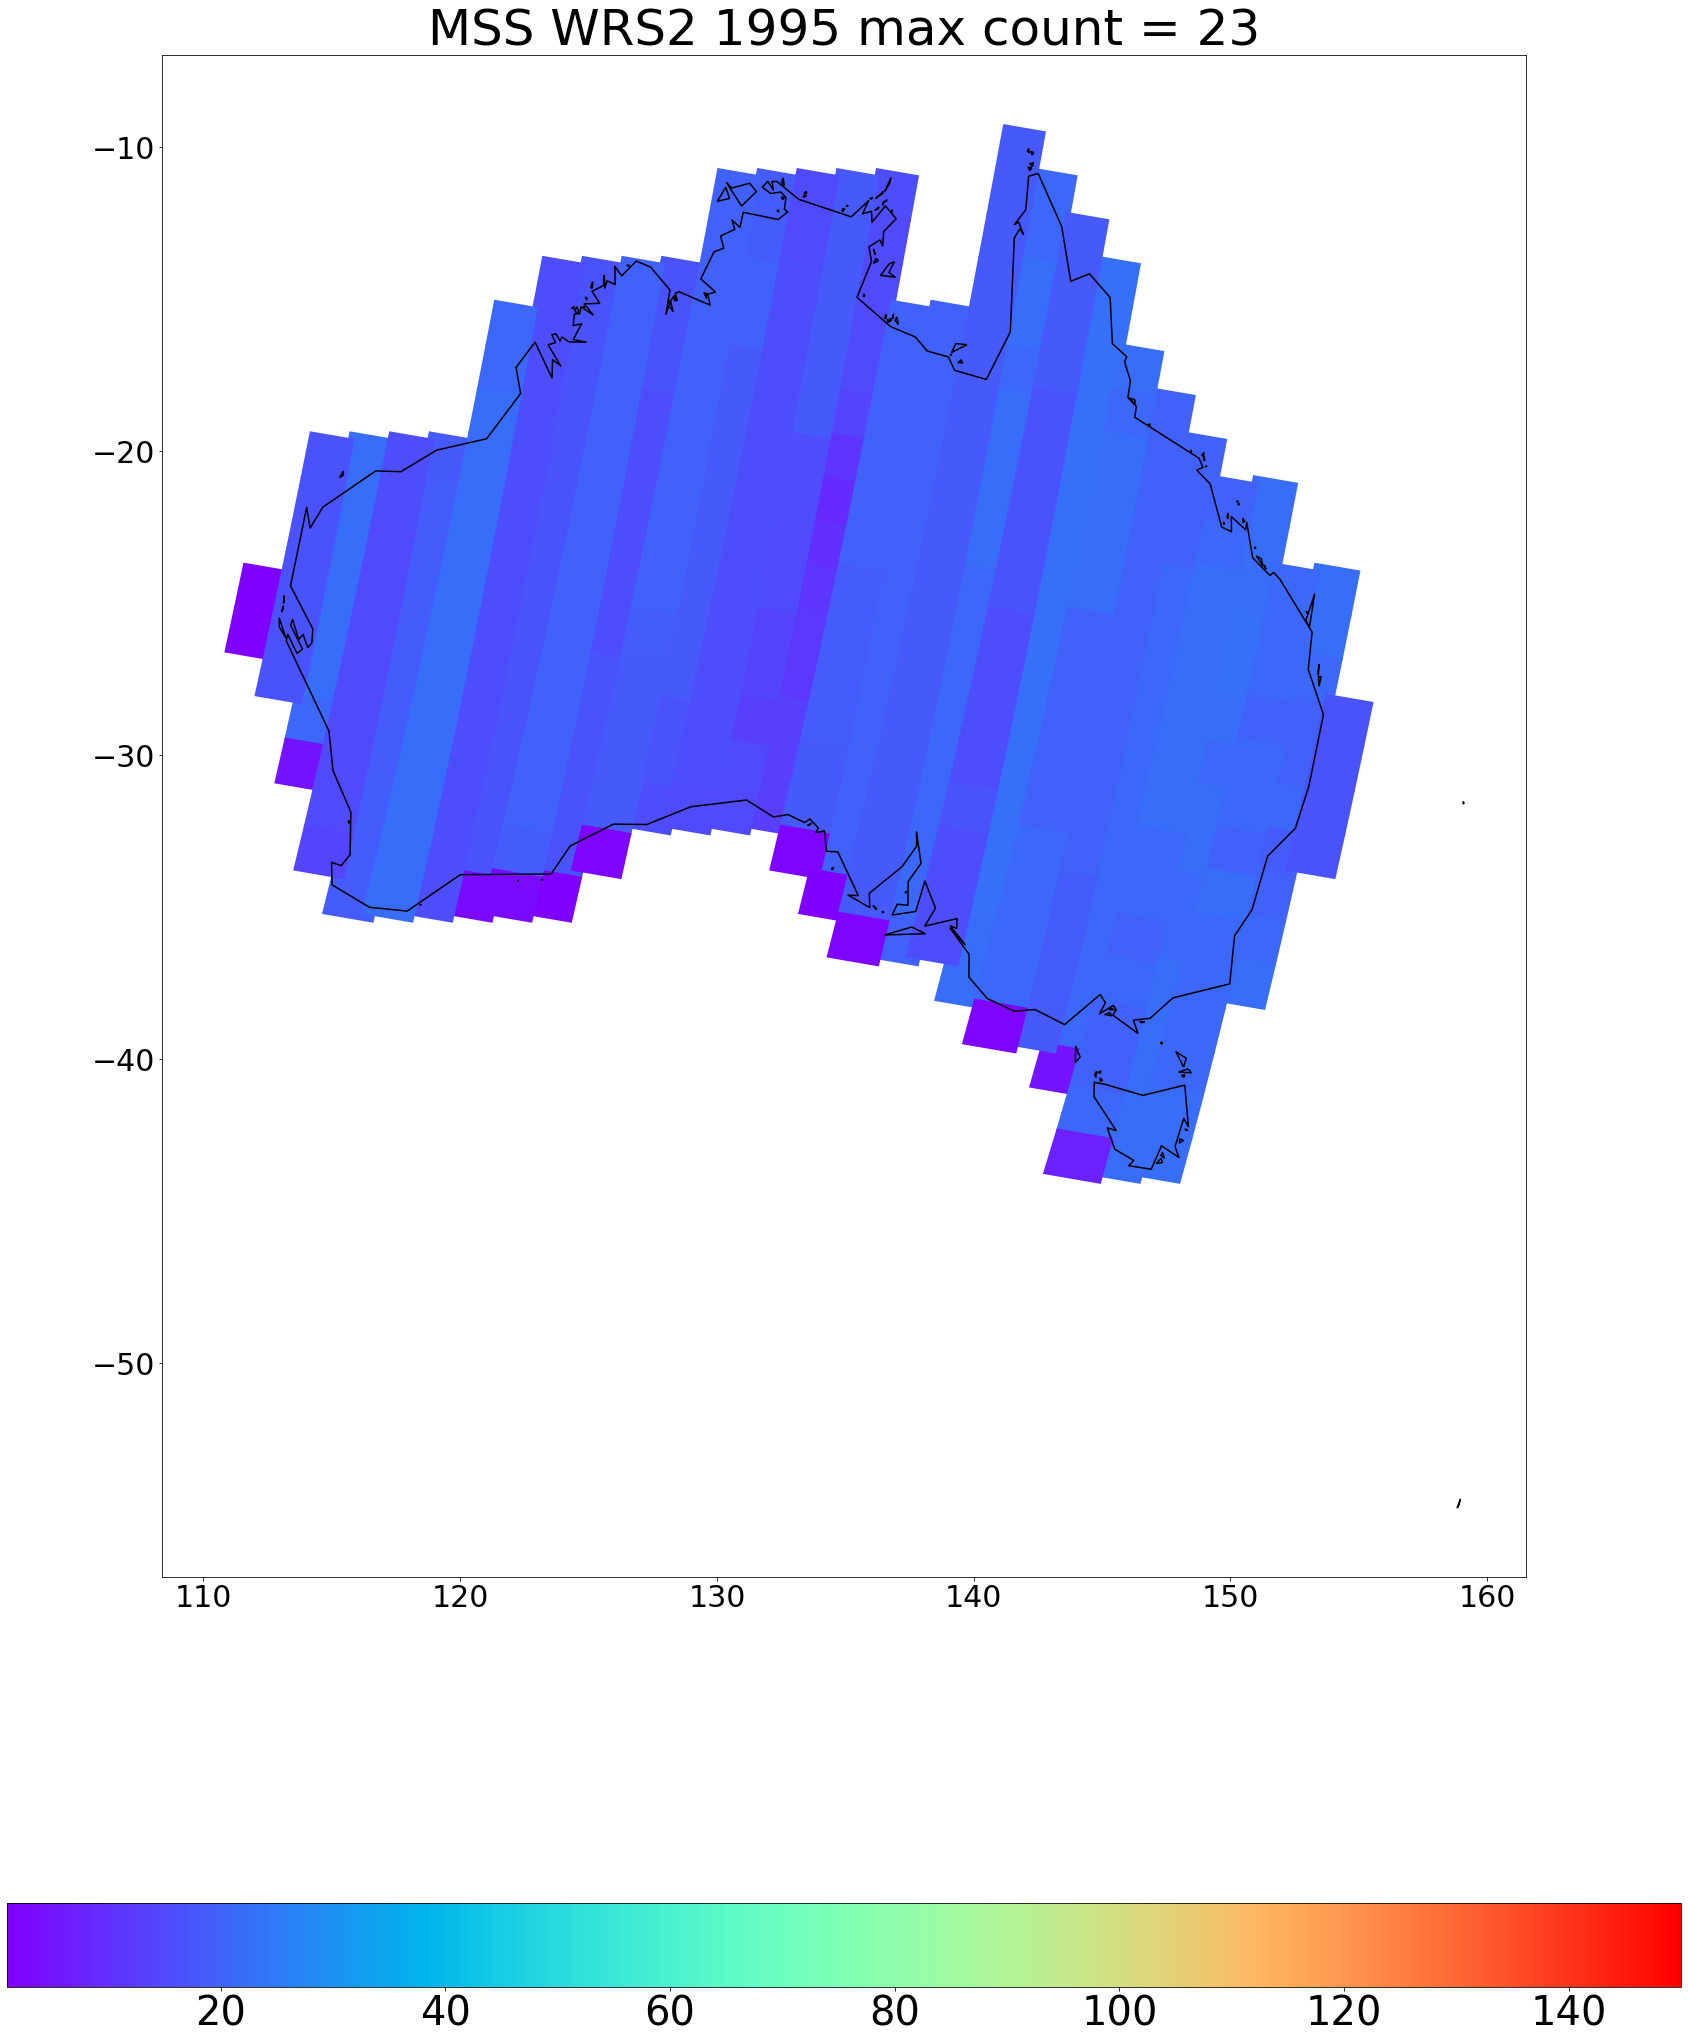

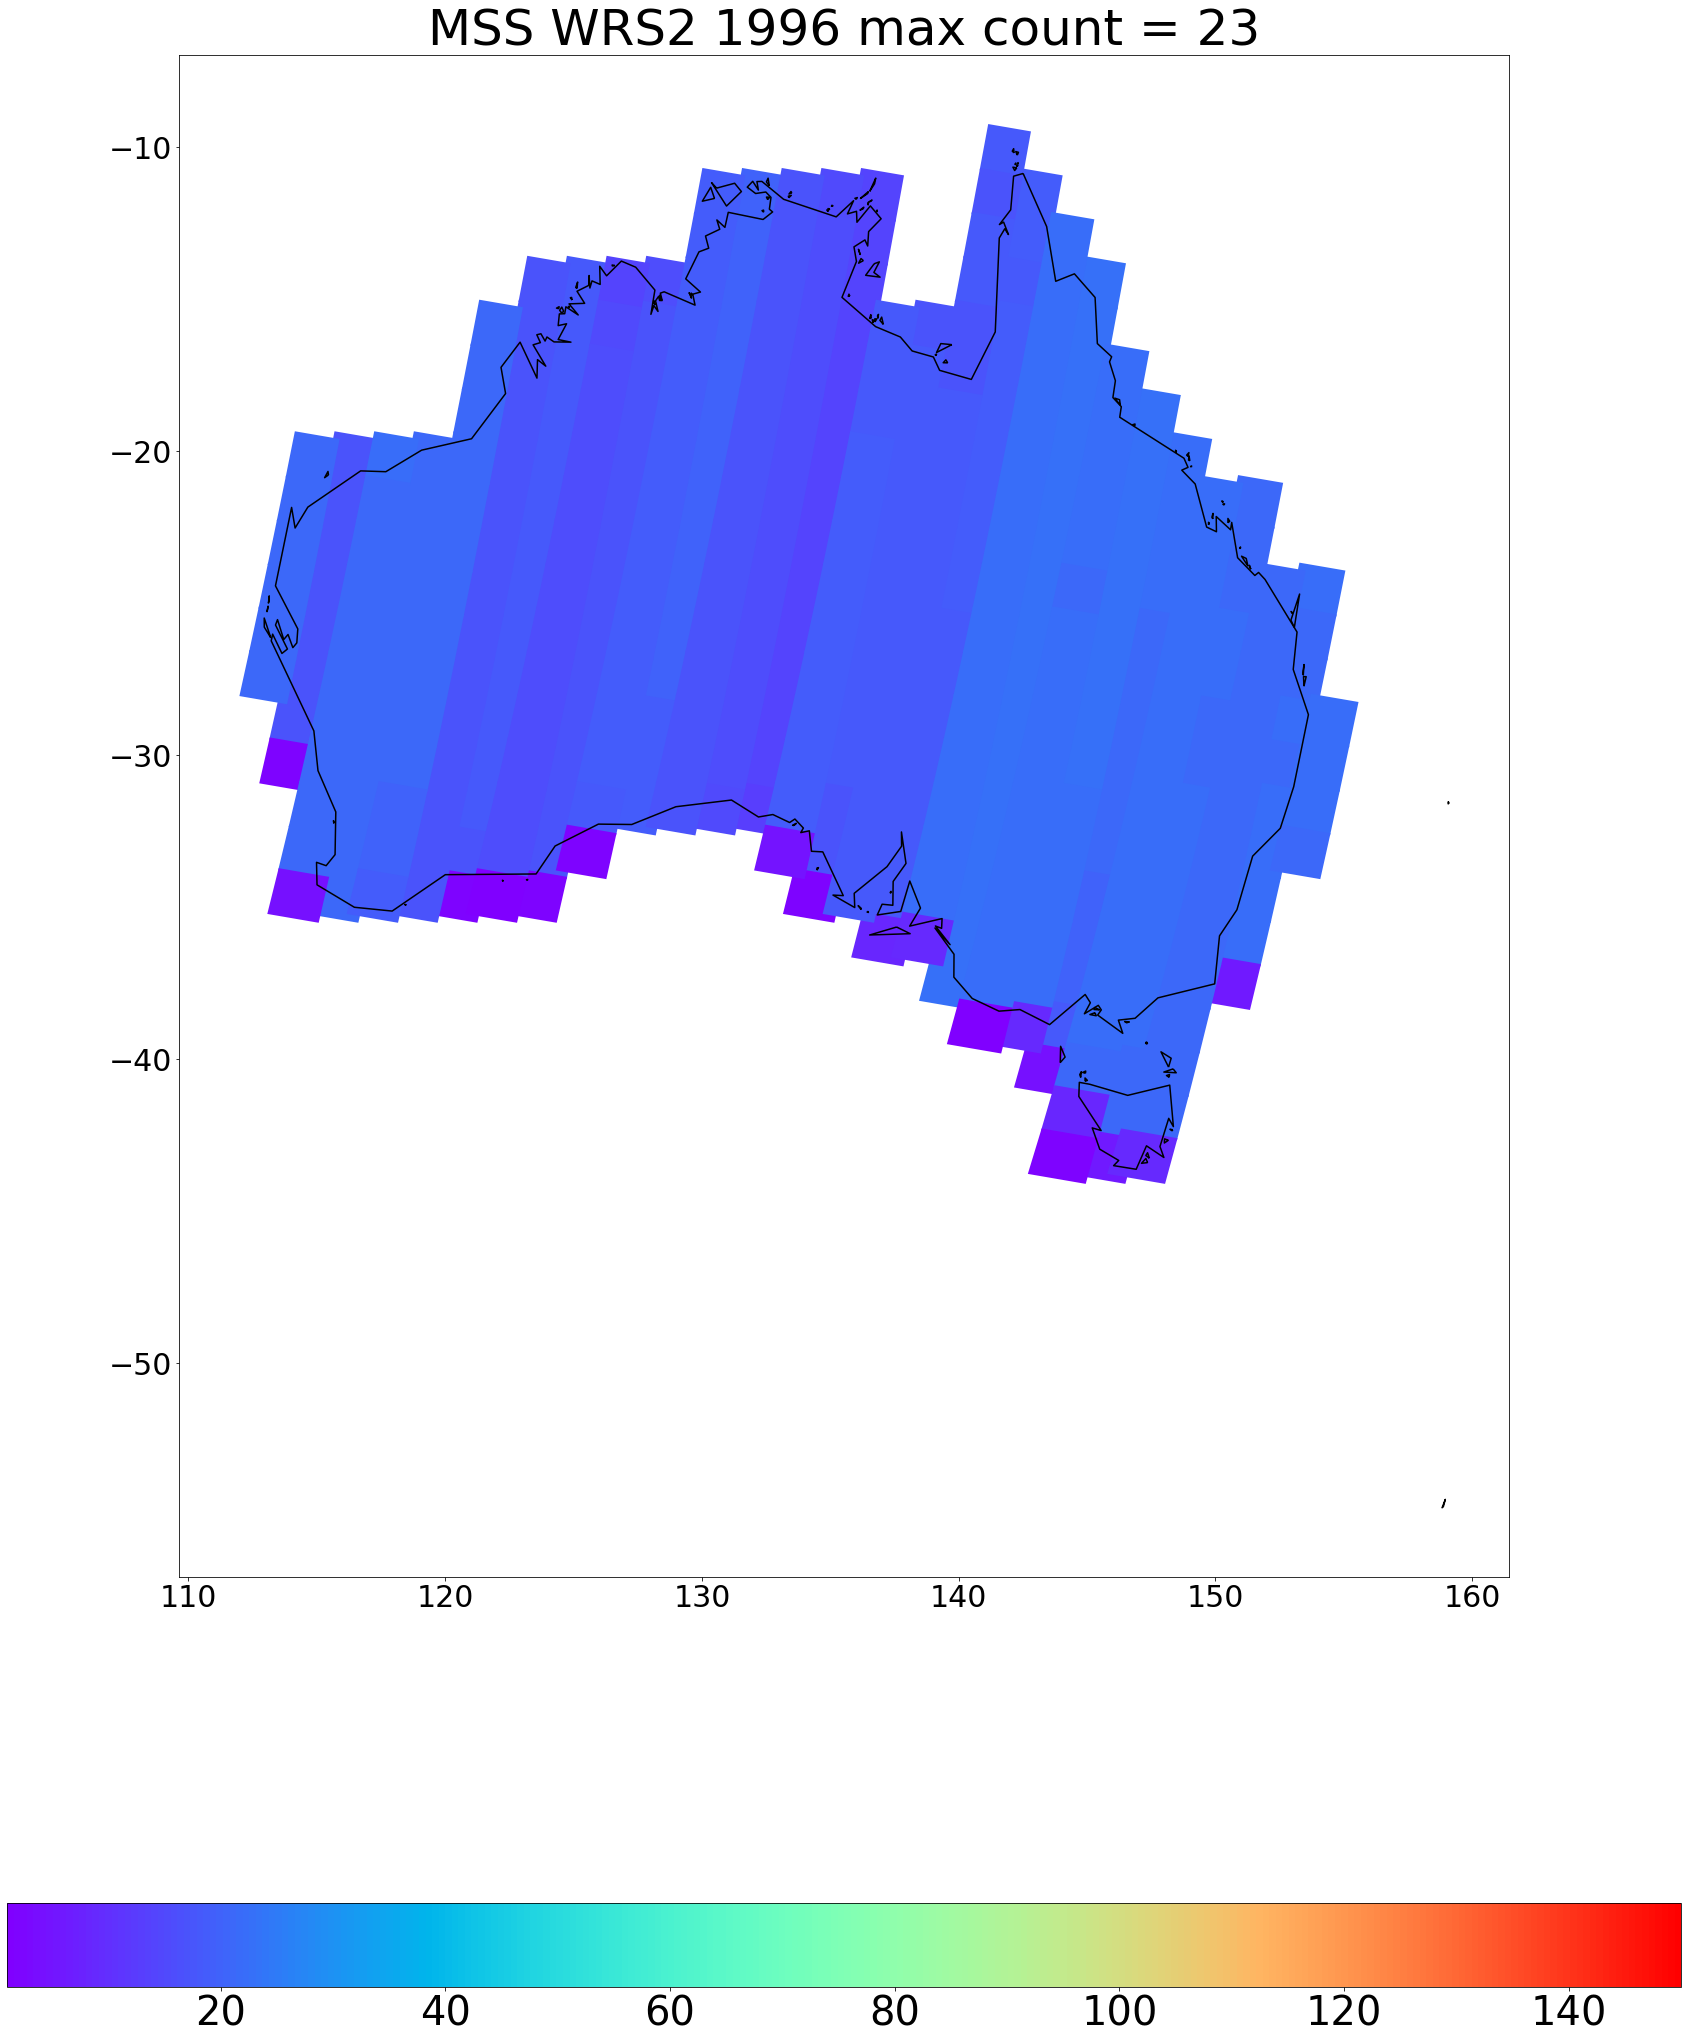

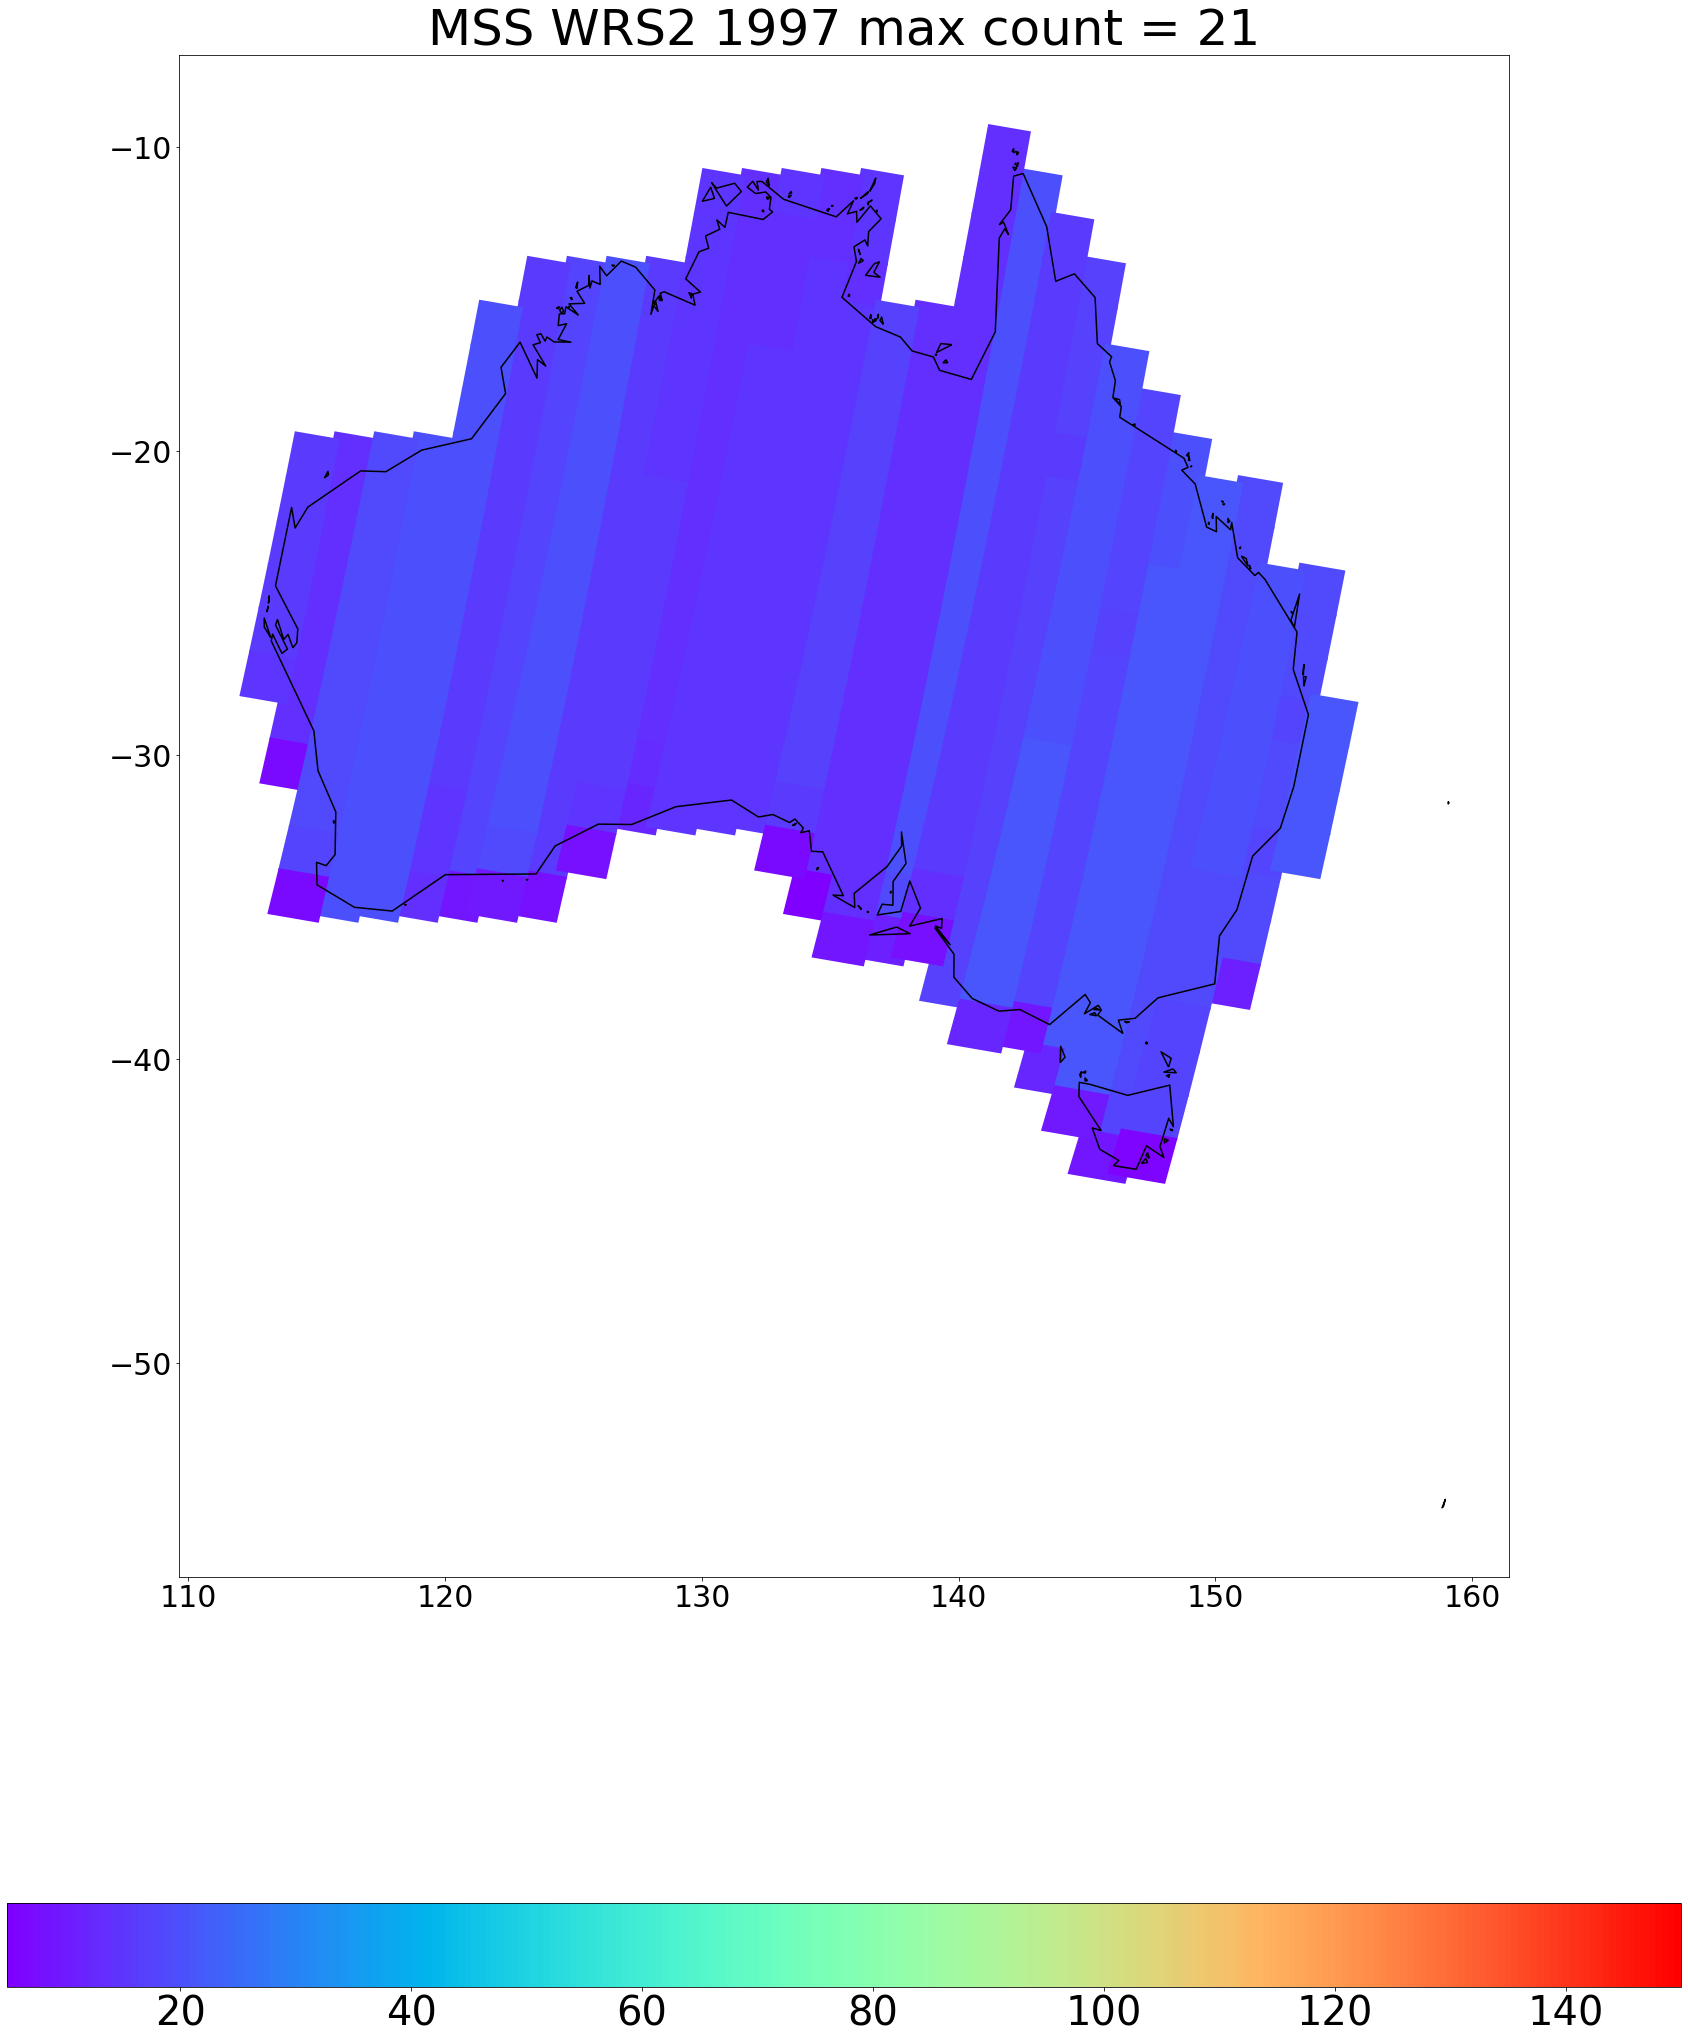

In [92]:
mss_c2_Australia_wrs1
for wrs in ['WRS1', 'WRS2']:
    if wrs == 'WRS1':
        wrsselect = mss_c2_Australia_wrs1
        wrsdesc = Australia_wrs1desc
    else:
        wrsselect = mss_c2_Australia_wrs2
        wrsdesc = Australia_wrs2desc
        
    years = sorted(set(wrsselect['Date Acquired'].dt.year))
    for year in years:
        byyear = wrsselect[wrsselect['Date Acquired'].dt.year == year]
        yearly_pivot = byyear.pivot_table(index='PR', aggfunc={"count": np.sum})

        yearly_pivot_wrsdesc = wrsdesc.join(yearly_pivot, on ='PR')
        ax = yearly_pivot_wrsdesc.to_crs('EPSG:4326').plot("count", cmap='rainbow', vmax=max, legend=True, figsize=(30, 40), legend_kwds={'orientation': "horizontal"})
        
        ax.set_title('MSS '+wrs+' '+str(year)+' max count = '+str(yearly_pivot['count'].max()))
        ax.figure.axes[0].title.set_fontsize(50) 
        ax.figure.axes[1].tick_params(labelsize=40)
        ax.figure.axes[0].tick_params(labelsize=30)
        Australia.boundary.to_crs('EPSG:4326').plot( ax=ax, edgecolor='black')